# Fitting dNdEta Distribution $n_{BC}$ Depandence $\Delta \eta$ 

## 熵密度分布的形式

### $$
% \begin{equation}
\begin{split}
e(\mathbf{x}_{\perp},\eta)
&=f_L(\eta) \, \left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \alpha}\\
&+f_R(\eta) \, \left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \alpha}\\
&+ F_{L,R}(\eta) \, \left(\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)\right)^{\large \beta}
\end{split}
% \end{equation}
$$

### $$F_{L,R}(\eta)=\left\{\begin{array}{ll}1,&\mathrm{if} |\eta|\leq\eta_\mathrm{flat}\\\exp\biggl(-\frac{(|\eta|-\eta_\mathrm{flat})^2}{2\eta_\mathrm{gw}^2}\biggr),&\mathrm{if} |\eta|>\eta_\mathrm{flat}\end{array}\right.$$

### $$f_{L,R}(\eta) = \exp\left(-\frac{(|\eta| \pm \eta_0)^2}{2 \sigma^2}\right)$$

### 这里 $f_L(\eta)$ 以及 $\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{left}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$为左侧向右侧运动的d核的纵向分布函数；  
### $f_R(\eta)$ 以及 $\sum_{i=1}^{N_{\mathrm{part}}^{\mathrm{right}}}\exp\left(-\frac{(\mathbf{x}_\perp-\mathbf{x}_i)^2}{2\sigma^2}\right)$为右侧向左侧运动的Au核的纵向分布函数

# 一、定义计算熵的类，对每个事件添加一个$n_{BC}^{i}$依赖的快度损失
### $$\Delta \eta_{i}= \frac{n_{BC}^{i}-n_{BC}^{min}}{n_{BC}^{max}-n_{BC}^{min}} + 2$$

In [1]:
import os
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.integrate import trapezoid, simpson
import matplotlib.pyplot as plt
import mplhep as hep
# Setting the plot style
hep.style.use('ATLAS')

from tqdm import tqdm
import h5py


In [2]:
class EntropyAndDSdEtaCalculator:
    """
    A class to calculate the dS/dEta distribution for different events.

    Parameters:
        eta (float): Maximum pseudorapidity value.
        slices (int): Number of slices in the pseudorapidity range.
        y_0 (float): Initial rapidity.
        sigma (float): Gaussian width.
        eta_flat (float): Flat region extent in the plateau function.
        eta_gw (float): Gaussian fall-off width in the plateau function.
        P_factor (float): Plateau scaling factor.
        L_factor (float): Left Gaussian scaling factor.
        R_factor (float): Right Gaussian scaling factor.
        alpha (float): Exponent for the left and right entropy.
        beta (float): Exponent for the plateau entropy.
    """

    def __init__(self, eta=6.9, slices=121, y_0=3.78, sigma=0.6, 
                 eta_flat=1.5, eta_gw=1.3, P_factor=1, L_factor=1, R_factor=1, alpha=2.0, beta=0.5):
        self.eta = eta
        self.slices = slices
        self.y_0 = y_0
        self.sigma = sigma
        self.L_factor = L_factor
        self.R_factor = R_factor
        self.P_factor = P_factor
        self.alpha = alpha
        self.beta = beta
        self.eta_flat = eta_flat
        self.eta_gw = eta_gw

    def gaussian_function(self, x=0, center=0, width=1):
        """Compute a Gaussian function."""
        return np.exp(-((x - center)**2) / (2 * width**2))

    def plateau_function(self, eta=np.linspace(-6.9, 6.9, 121)):
        """Compute the plateau function based on pseudorapidity."""
        heta = np.ones_like(eta)
        fall_off = np.abs(eta) > self.eta_flat
        eta_fall = np.abs(eta[fall_off])
        heta[fall_off] = np.exp(-(eta_fall - self.eta_flat)**2 / (2.0 * self.eta_gw**2))
        return heta

    def save_longitudinal_dis_coef(self, y_loss):
        """
        Compute the longitudinal distribution coefficients for left, right, and plateau.

        Parameters:
            y_loss (float): Rapidity loss.

        Returns:
            coef_l, coef_r, coef_lr: Arrays of coefficients.
        """
        etas = np.linspace(-self.eta, self.eta, self.slices)
        coef_l = self.L_factor * self.gaussian_function(x=etas, center=self.y_0-y_loss, width=self.sigma)
        coef_r = self.R_factor * self.gaussian_function(x=etas, center=-self.y_0, width=self.sigma)
        coef_p = self.P_factor * self.plateau_function(eta=etas)
        return coef_l, coef_r, coef_p

    def calc_dSdEta_part(self, entropy_200x200, coef_list):
        """
        Compute part of the dS/dEta distribution for a specific component.

        Parameters:
            entropy_200x200 (ndarray): 2D entropy data.
            coef_list (ndarray): Coefficient list.

        Returns:
            dSdEta_half: Part of the dS/dEta distribution.
        """
        # 我们选定x-y范围为-10 fm - 10 fm 的 200*200 网格，dx=dy=0.1 fm
        # 我们选定-6.9 - 6.9 的 121 个 eta 切片，deta=0.115
        
        dtau0 = 0.6
        dx = 0.1
        dy = 0.1
        deta = 0.115
        dtau = dtau0 * dx * dy * deta
        dSdEta_half = np.zeros(len(coef_list))
        for i, coef in enumerate(coef_list):
            dSdEta_half[i] = np.sum(entropy_200x200) * dtau * coef
        return dSdEta_half

    def calc_dSdEta(self, entropy_200x200_L, entropy_200x200_R, y_loss):
        """
        Calculate the total dS/dEta distribution.

        Parameters:
            entropy_200x200_L (ndarray): Left entropy data.
            entropy_200x200_R (ndarray): Right entropy data.
            y_loss (float): Rapidity loss.

        Returns:
            dSdEta: Total dS/dEta distribution.
        """
        self.coef_L, self.coef_R, self.coef_P = self.save_longitudinal_dis_coef(y_loss)
        entropy2d_plat = entropy_200x200_L * entropy_200x200_R
        dSdEta_L = self.calc_dSdEta_part(entropy_200x200_L**self.alpha, self.coef_L)
        dSdEta_R = self.calc_dSdEta_part(entropy_200x200_R**self.alpha, self.coef_R)
        dSdEta_P = self.calc_dSdEta_part(entropy2d_plat**self.beta, self.coef_P)
        dSdEta = dSdEta_L + dSdEta_R + dSdEta_P
        return dSdEta
    
    def calc_3D_entropy_part(self, entropy_2D, coef_list):
        """
        Calculate entropy 3D for a specific part
        Multiply a 2D matrix with a 1D coefficient list to produce a 3D matrix.
        """
        entropy_3D = np.zeros((len(coef_list), *entropy_2D.shape))
        for i, coef in enumerate(coef_list):
            entropy_3D[i] = entropy_2D * coef
        
        return entropy_3D

    def calc_entropy3D(self, entropy_200x200_L, entropy_200x200_R, y_loss):
        """
        Calculate the sum of three 3D entropy distribution.
        """
        self.coef_L, self.coef_R, self.coef_P = self.save_longitudinal_dis_coef(y_loss)
        entropy2d_combined = entropy_200x200_L * entropy_200x200_R
        entropy_L = self.calc_3D_entropy_part(entropy_200x200_L ** self.alpha, self.coef_L)
        entropy_R = self.calc_3D_entropy_part(entropy_200x200_R ** self.alpha, self.coef_R)
        entropy_P = self.calc_3D_entropy_part(entropy2d_combined ** self.beta, self.coef_P)
        return entropy_L + entropy_R + entropy_P


### 对每个事件添加一个$n_{BC}^{i}$依赖的快度损失
### $$\Delta \eta_{i}=\frac{n_{BC}^{i}-n_{BC}^{min}}{n_{BC}^{max}-n_{BC}^{min}} + 2$$

In [4]:
def calculate_event_dSdEta(event, input_dir, calculator, n_bc_min, n_bc_max):
    """
    Calculate dS/dEta for a specific event.

    Parameters:
        event (int): Event number.
        input_dir (str): Directory containing input files.
        calculator (dSdEtaCalculator): Calculator instance.
        n_bc_min (float): Minimum n_bc value.
        n_bc_max (float): Maximum n_bc value.

    Returns:
        dSdEta: Calculated dS/dEta distribution.
    """
    projectile_file = os.path.join(input_dir, f'entropy2d/projectile_entropy_event_{event}.dat')
    target_file = os.path.join(input_dir, f'entropy2d/target_entropy_event_{event}.dat')
    info_file = os.path.join(input_dir, f'information_of_d_Au_collision/event_{event}/information_of_output.dat')

    if os.path.exists(projectile_file) and os.path.exists(target_file) and os.path.exists(info_file):
        sum_gaussian_L = np.loadtxt(projectile_file)
        sum_gaussian_R = np.loadtxt(target_file)

        n_bc = np.loadtxt(info_file, usecols=5)
        # 使用1+2的形式
        y_loss = 1 * (n_bc - n_bc_min) / (n_bc_max - n_bc_min) + 2.0     

        dSdEta = calculator.calc_dSdEta(sum_gaussian_L, sum_gaussian_R, y_loss)
        return dSdEta, y_loss
    else:
        print(f"Warning: Files for event {event} not found.")
        return None
    

def get_n_bc_range(input_dir, event_range):
    """
    Get the range of n_bc values from input files.

    Parameters:
        input_dir (str): Directory containing input files.
        event_range (list): Range of event numbers.

    Returns:
        n_bc_min, n_bc_max: Minimum and maximum n_bc values.
    """
    n_bc_values = []
    for event in range(event_range[0], event_range[1]):
        info_file = os.path.join(input_dir, f'information_of_d_Au_collision/event_{event}/information_of_output.dat')
        if os.path.exists(info_file):
            n_bc = np.loadtxt(info_file, usecols=5)
            n_bc_values.append(n_bc)
    return min(n_bc_values), max(n_bc_values)

def calculate_integral_dS(dsdeta,eta_range=[3.0,5.4], method="trapezoid"):
    """
    Calculate the integral of the dS/dEta distribution.

    Parameters:
        dsdeta (ndarray): dS/dEta distribution.
        etas (ndarray): Pseudorapidity values.
        method (str): Integration method ("trapezoid" or "simpson").

    Returns:
        integral_dS: Integrated value of dS/dEta.
    """
    etas = np.linspace(-6.9, 6.9, 121)
    mask1 = (etas >= -eta_range[1]) & (etas <= -eta_range[0])
    mask2 = (etas >=  eta_range[0]) & (etas <=  eta_range[1])
    if method == "trapezoid":
        integral_dS = trapezoid(dsdeta[mask1], etas[mask1]) + trapezoid(dsdeta[mask2], etas[mask2])
    elif method == "simpson":
        integral_dS = simpson(dsdeta[mask1], x=etas[mask1]) + simpson(dsdeta[mask2], x=etas[mask2])
    else:
        raise ValueError("Unsupported method: choose 'trapezoid' or 'simpson'")
    return integral_dS



In [5]:
def calc_dSdEta_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                    eta_flat=1.5, eta_gw=1.3, event_range=[0, 300],
                    L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                    HWF_or_DWF='HWF', num_workers=4):
    from tqdm import tqdm
    
    calculator = EntropyAndDSdEtaCalculator(
        eta=eta, slices=slices, eta_flat=eta_flat, eta_gw=eta_gw,
        y_0=y_0, sigma=sigma, alpha=alpha, beta=beta,
        L_factor=L_factor, R_factor=R_factor, P_factor=P_factor
    )
    
    disk_2T = 'west16'
    input_dir = f'/media/mengzhu/{disk_2T}/d_Au_work/d_Au_{HWF_or_DWF}/'
    n_bc_min, n_bc_max = get_n_bc_range(input_dir, event_range)
    
    dSdEta_event_all = []
    total_events = event_range[1] - event_range[0]
    
    # 修改后的进度条设置
    progress_bar = tqdm(
        total=total_events, 
        desc="处理事件", 
        unit="事件",
        mininterval=0.5,  # 降低刷新频率
        ncols=80,         # 固定宽度
        ascii=True        # 使用简单字符
    )

    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {
            executor.submit(calculate_event_dSdEta, event, input_dir, calculator, n_bc_min, n_bc_max): event
            for event in range(event_range[0], event_range[1])
        }

        for future in as_completed(futures):
            event = futures[future]
            try:
                dSdEta_result, y_loss = future.result()
                if dSdEta_result is not None:
                    ds_total = calculate_integral_dS(dsdeta=dSdEta_result, method="trapezoid")
                    dSdEta_event_all.append([dSdEta_result, y_loss, event, ds_total])
            except Exception as e:
                print(f"\n事件 {event} 错误: {str(e)}")
            finally:
                progress_bar.update(1)
                # 减少postfix更新频率
#                 if progress_bar.n % 10 == 0:  
#                     progress_bar.set_postfix({'最新事件': event})

    progress_bar.close()
    
    if dSdEta_event_all:
        dSdEta_event_array = np.array(dSdEta_event_all, dtype=object)
        return dSdEta_event_array[np.argsort(dSdEta_event_array[:, 3])[::-1]]
    return np.array([])

In [6]:
def plot_dSdEta_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                    eta_flat=1.5, eta_gw=1.3, event_range=[0, 300],
                    L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                    HWF_or_DWF='HWF', num_workers=4, plot_dSdEta=True):
   
    # 计算该参数下ds_totall排序后的 dSdEta、y_loss、event、ds_totall 的结果
    dSdEta_event_array=calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                       eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                       L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                       alpha=alpha, beta=beta,
                                       HWF_or_DWF=HWF_or_DWF, num_workers=num_workers)
    
    if plot_dSdEta:
        plt.figure(figsize=(8, 6))
        eta_values = np.linspace(-eta, eta, slices)

        for dSdEta, y_loss, event, dS in dSdEta_event_array:
            plt.plot(eta_values, dSdEta, label=f'Event {event} (dS ={dS:.2f},dy={y_loss:.2f})', alpha=0.6)

        plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
        plt.ylabel(r'$\rm dS/d\eta$', fontsize=20, ha='center')
        plt.title(r'$\rm dS/d\eta$ Distribution'
                  + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
                  + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}', fontsize=20)
        plt.legend(fontsize=12, loc='upper right', ncol=1)
        plt.grid()

    return dSdEta_event_array


处理事件: 100%|#################################| 5/5 [00:00<00:00, 35.95事件/s]


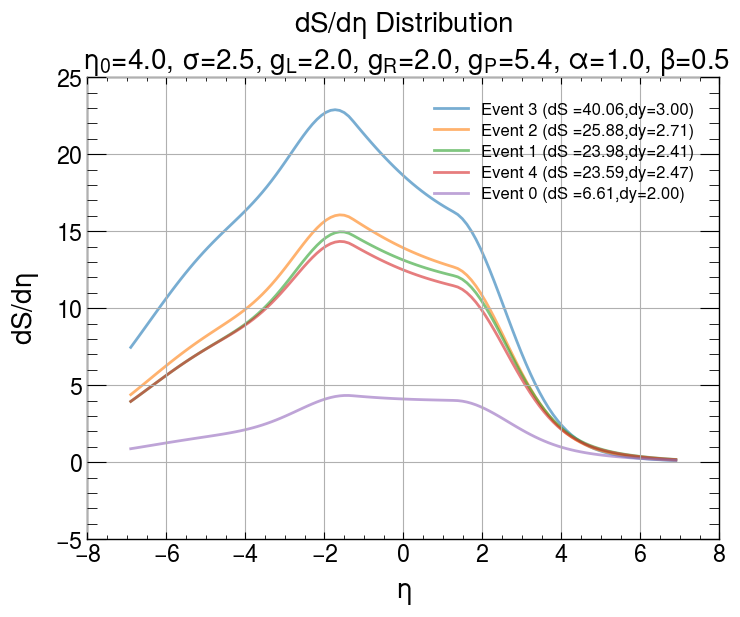

In [7]:
dSdEta_event_array =plot_dSdEta_ebe(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                    eta_flat=1.3, eta_gw=1.3, event_range=[0, 5],
                                    L_factor=2.0, R_factor=2.0, P_factor=5.4, alpha=1.0, beta=0.5,
                                    HWF_or_DWF='DWF', num_workers=4, plot_dSdEta=True)

In [8]:
dSdEta_event_array[:][:,-1]

array([40.060636699166594, 25.8768190541873, 23.9779887697679,
       23.591208812778927, 6.611148787559234], dtype=object)

In [9]:
def subplot_dSdEta_centrality_ebe(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                                  eta_flat=1.5, eta_gw=1.3, event_range=[0, 300],
                                  L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                                  percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                                  HWF_or_DWF='HWF', num_workers=4, plot_dSdEta=True,save_fig=False):
    """
    逐事件并行计算 dSdEta，并按积分值排序后，按百分比绘制不同中心度区间的 dSdEta 分布图。

    :param eta: 纵向快度范围
    :param slices: 快度切片个数
    :param y_0: 高斯分布中心参数
    :param sigma: 高斯分布宽度参数
    :param eta_flat: 平坦区域范围参数
    :param eta_gw: 平坦区域衰减宽度参数
    :param event_range: 要处理的事件范围
    :param L_factor, R_factor, P_factor: 理论模型参数
    :param alpha, beta: 指数参数
    :param percentiles: 百分比区间列表
    :param HWF_or_DWF: 数据类型 ('HWF' 或 'DWF')
    :param num_workers: 并行线程数量
    :param plot_dSdEta: 是否绘制图像

    :return: 按中心度排序的事件数据数组 (dSdEta, event_index, integral_value)
    """
    # 计算该参数下ds_totall排序后的 dSdEta、y_loss、event、ds_totall 的结果

    dSdEta_event_array=calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                       eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                       L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                       alpha=alpha, beta=beta,
                                       HWF_or_DWF=HWF_or_DWF, num_workers=num_workers)


    if plot_dSdEta:
        # 绘制不同中心度区间的图像
        eta_values = np.linspace(-eta, eta, slices)
        total_events = len(dSdEta_event_array)

        # 创建 2x3 的子图布局
        fig, axes = plt.subplots(2, 3, figsize=(16, 10))
        axes = axes.flatten()

        for idx, (start, end) in enumerate(percentiles):
            start_idx = int(total_events * start / 100)
            end_idx = int(total_events * end / 100)

            # 获取当前区间的所有事件的 dSdEta
            for i in range(start_idx, end_idx):
                dSdEta = dSdEta_event_array[i, 0]
                axes[idx].plot(eta_values, dSdEta, alpha=0.6)

            # 添加图例
            axes[idx].plot([], [], linestyle=' ', label=f'{start}-{end}%')
            axes[idx].legend(loc='upper right', fontsize=20)
            axes[idx].set_xlabel(r'$\rm \eta$', fontsize=20,ha='center')
            axes[idx].set_ylabel(r'$\rm dS/d\eta}$', fontsize=20,ha='center')
            axes[idx].set_xlim(-eta, eta)
            axes[idx].grid(True, alpha=0.3)
            axes[idx].set_xlim(-8,8)  # 设置统一纵轴范围
            axes[idx].set_ylim(0,40)  # 设置统一纵轴范围
            axes[idx].grid(True,alpha=0.3)

        # 隐藏多余子图
        for ax in axes[len(percentiles):]:
            ax.axis('off')

#         plt.suptitle(r'Distribution of $\rm dS/d\eta$ by Centrality'
#                    + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
#                    + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}',fontsize=25)
        plt.suptitle(r'Distribution of $\rm dS/d\eta$ by Centrality',fontsize=25)
        plt.tight_layout()
        if save_fig:
            plt.savefig(f'fig/dSdeta_ebe_P_factor_{str(P_factor).replace(".", "p")}_beta_{str(beta).replace(".", "p")}_5000.pdf', bbox_inches='tight',dpi=100)
        plt.show()

#     return dSdEta_event_array


处理事件: 100%|###########################| 5000/5000 [06:09<00:00, 13.53事件/s]


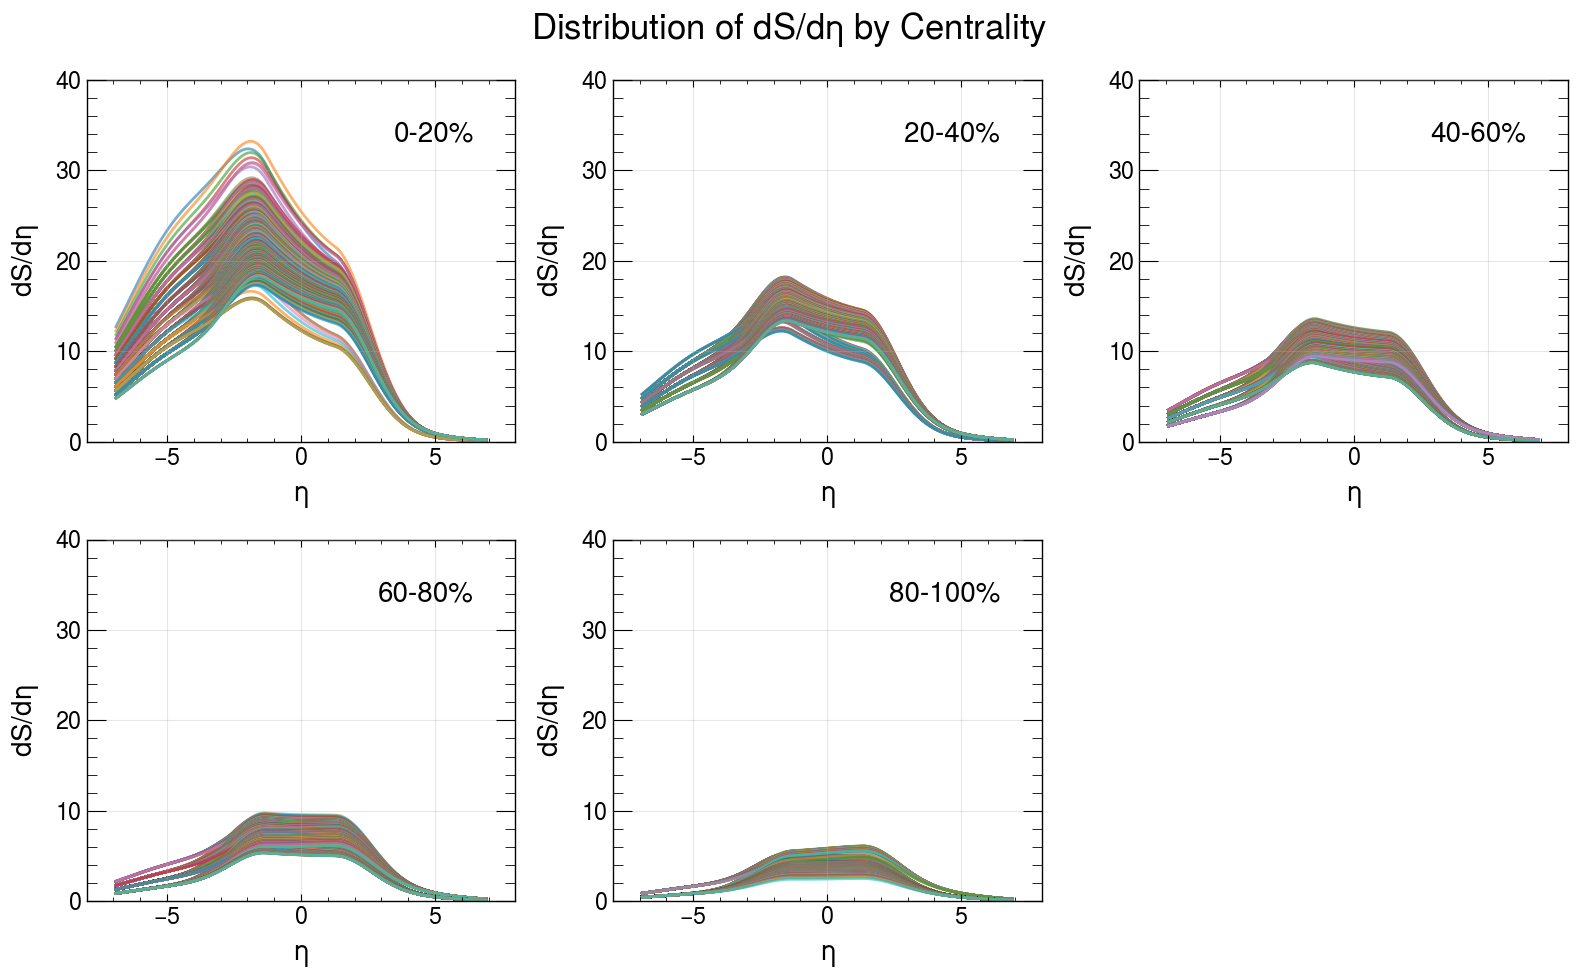

In [9]:
subplot_dSdEta_centrality_ebe(eta=6.9, slices=121, y_0=4, sigma=2.5,
                              eta_flat=1.3, eta_gw=1.3, event_range=[0, 5000],
                              L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.35,
                              percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                              HWF_or_DWF='DWF', num_workers=12, plot_dSdEta=True,save_fig=False)

In [10]:
def plot_avg_dSdEta_centrality(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                               eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300],
                               L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                               percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                               HWF_or_DWF='HWF', num_workers=4):
    """
    逐事件并行计算 dSdEta 和积分结果，将结果保存为数组，并计算每个中心度区间的平均 dSdEta。

    返回值包含每个事件的 dSdEta, 事件序号，以及积分值。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向能量沉积的参数
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param y_loss: 损失参数
    :param L_factor, R_factor, P_factor, alpha, beta: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF
    :param num_workers: 并行线程数量
    :param percentiles: 划分的百分位区间，默认为 [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]。
    """
    # 计算该参数下ds_totall排序后的 dSdEta、y_loss、event、ds_totall 的结果

    dSdEta_event_array=calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                       eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                       L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                       alpha=alpha, beta=beta,
                                       HWF_or_DWF=HWF_or_DWF, num_workers=num_workers)

    # 绘制不同中心度区间的平均分布图像
    eta_values = np.linspace(-eta, eta, slices)
    total_events = len(dSdEta_event_array)

    average_distributions = []  # 用于保存每个中心度区间的平均分布

    for start, end in percentiles:
        start_idx = int(total_events * start / 100)
        end_idx = int(total_events * end / 100)

        # 获取当前区间的所有事件的 dSdEta
        dSdEta_subset = dSdEta_event_array[start_idx:end_idx, 0]

        # 计算平均分布
        avg_dSdEta = np.mean(np.vstack(dSdEta_subset), axis=0)
        average_distributions.append((avg_dSdEta, f'{start}-{end}%'))

    # 绘图
    plt.figure(figsize=(8, 6))
    colors = ['red', 'blue', 'green', 'orange', 'black']

    for idx, (avg_dist, label) in enumerate(average_distributions):
        plt.plot(eta_values, avg_dist, color=colors[idx % len(colors)], label=label, alpha=0.8)

    plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
    plt.ylabel(r'$\rm dS/d\eta}$', fontsize=20, ha='center')
    plt.title(r'Averaged $\rm dS/d\eta$ Distribution by Centrality'
              + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
              + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}', fontsize=25)
    plt.legend(fontsize=20, loc='upper right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



处理事件: 100%|#########################| 5000/5000 [00:03<00:00, 1274.14事件/s]


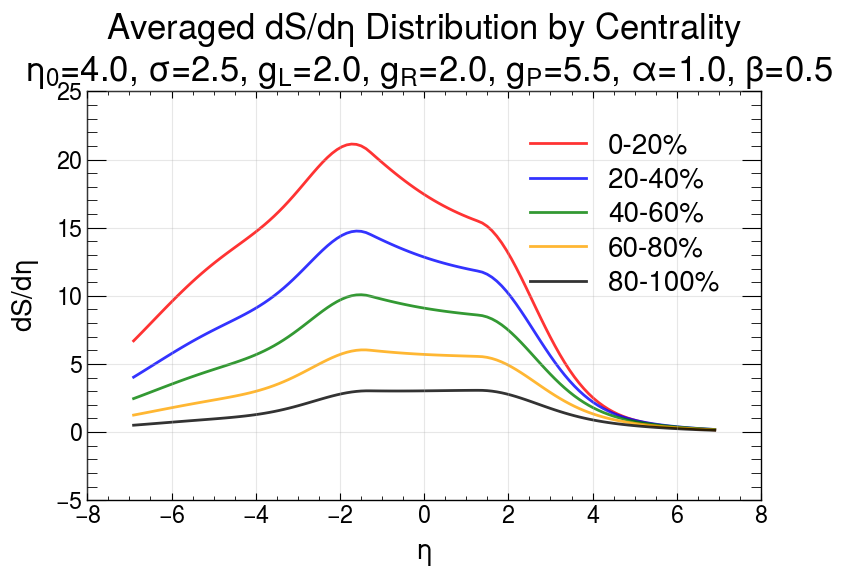

In [11]:
plot_avg_dSdEta_centrality(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                           eta_flat=1.3, eta_gw=1.3, event_range=[0, 5000],
                           L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.5,
                           percentiles = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                           HWF_or_DWF='DWF', num_workers=16)

# 导入先验的熵密度分布的数据：

In [11]:
dSdEta_average_distributions = np.loadtxt("./data/dSdEta_average_distributions.dat")

In [12]:
def plot_avg_dSdEta_centrality_comparison(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                                          eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300],
                                          L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                                          percentiles=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                                          HWF_or_DWF='HWF', num_workers=4, IC_events=1000):
    """
    逐事件并行计算 dSdEta 和积分结果，将结果保存为数组，并计算每个中心度区间的平均 dSdEta。

    返回值包含每个事件的 dSdEta, 事件序号，以及积分值。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向能量沉积的参数
    :param eta_flat, eta_gw: 参数影响平坦区域和高斯宽度
    :param y_loss: 损失参数
    :param L_factor, R_factor, P_factor, alpha, beta: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF
    :param num_workers: 并行线程数量
    :param percentiles: 划分的百分位区间，默认为 [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]。
    :param IC_events: 每个中心度随机选择的事件数量
    """
    # 计算该参数下ds_totall排序后的 dSdEta、y_loss、event、ds_totall 的结果

    dSdEta_event_array=calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                       eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                       L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                       alpha=alpha, beta=beta,
                                       HWF_or_DWF=HWF_or_DWF, num_workers=num_workers)

    # 绘制不同中心度区间的平均分布图像
    eta_values = np.linspace(-eta, eta, slices)
    total_events = len(dSdEta_event_array)

    average_distributions = []  # 用于保存每个中心度区间的平均分布

    for start, end in percentiles:
        start_idx = int(total_events * start / 100)
        end_idx = int(total_events * end / 100)

        # 获取当前区间的所有事件的 dSdEta
        dSdEta_subset = dSdEta_event_array[start_idx:end_idx, 0]

        # 随机选择事件
        if len(dSdEta_subset) >= IC_events:
            selected_indices = np.random.choice(len(dSdEta_subset), size=IC_events, replace=False)
            dSdEta_subset = [dSdEta_subset[i] for i in selected_indices]
        else:
            print(f"Warning: Events in range {start}-{end} are less than {IC_events}. Using all available events.")

        # 计算平均分布
        avg_dSdEta = np.mean(np.vstack(dSdEta_subset), axis=0)
        average_distributions.append((avg_dSdEta, f'{start}-{end}'))

    # 绘图
    plt.figure(figsize=(8, 8))
    colors = ['red', 'blue', 'green', 'orange', 'black']

    for idx, (avg_dist, label) in enumerate(average_distributions):
        plt.plot(eta_values, avg_dist, color=colors[idx % len(colors)], linestyle='-', label=label, alpha=0.8)
        plt.plot(eta_values, dSdEta_average_distributions[idx], color=colors[idx % len(colors)],linestyle='--', label=(label + " prior"), alpha=0.8)

    plt.xlabel(r'$\rm \eta$', fontsize=20, ha='center')
    plt.ylabel(r'$\rm dS/d\eta$', fontsize=20, ha='center')
    plt.title(r'Averaged $\rm dS/d\eta$ Distribution by Centrality'
              + f'\n $\\rm \\eta_0$={y_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
              + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}', fontsize=20)
    plt.legend(fontsize=16, loc='upper right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


处理事件: 100%|#########################| 50000/50000 [20:17<00:00, 41.06事件/s]


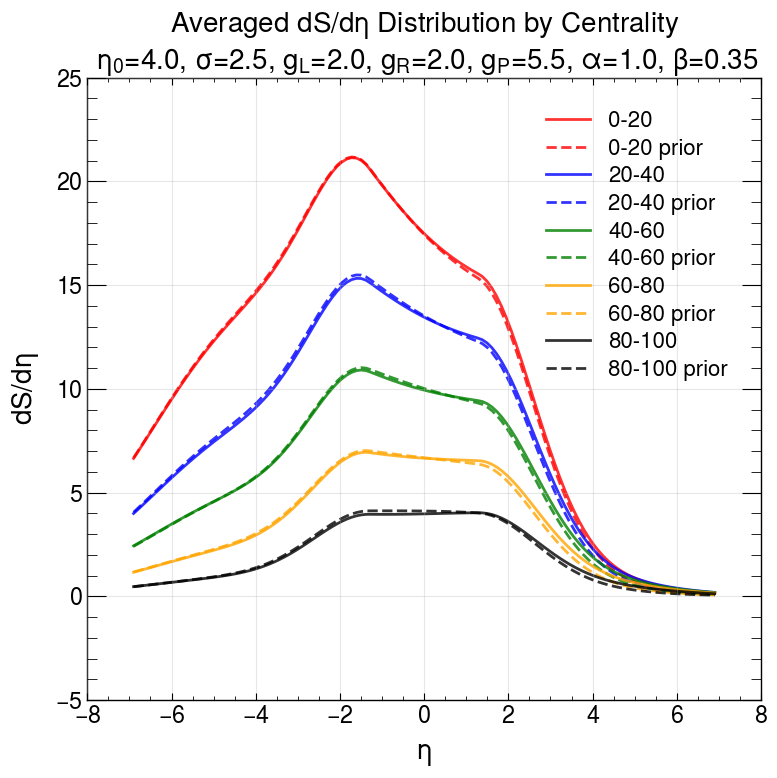

In [14]:
plot_avg_dSdEta_centrality_comparison(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                                      eta_flat=1.3, eta_gw=1.3, 
                                      event_range=[0, 50000],IC_events=1000,
                                      L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.35,
                                      percentiles = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                                      HWF_or_DWF='DWF', num_workers=16)

# 计算用于流体的Entropy3D

In [13]:
def calc_event_indices_random(eta=6.9, slices=121, y_0=3.78, sigma=0.6,
                              eta_flat=1.5, eta_gw=1.3, y_loss=0.5, event_range=[0, 300], IC_events=1000,
                              L_factor=1.0, R_factor=1.0, P_factor=1, alpha=2.0, beta=0.5,
                              cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                              HWF_or_DWF='HWF', num_workers=4):
    """
    并行计算 dSdEta distribution 和相应 eta 区间的 dSdEta 对 eta 积分结果，
    并返回指定中心度区间内随机挑选的事件序号和 y_loss 值。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param y_0, sigma: 调节纵向 gaussian distribution 能量沉积的参数
    :param eta_flat, eta_gw: 参数影响 plateau 平坦区域和高斯宽度
    :param y_loss: 损失参数，d核核子碰撞后可能会有纵向停滞
    :param L_factor, R_factor, P_factor, alpha=1, beta=0.5: 理论参数
    :param HWF_or_DWF: 区分 HWF 和 DWF两种核结构
    :param num_workers: 并行线程数量
    :param cents: 划分的百分位区间，默认为 [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]。
    :return: 字典，包含每个中心度区间内的随机事件序号和对应的 y_loss 值。
    """
    dSdEta_event_array = calc_dSdEta_ebe(eta=eta, slices=slices, y_0=y_0, sigma=sigma,
                                         eta_flat=eta_flat, eta_gw=eta_gw, event_range=event_range,
                                         L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
                                         alpha=alpha, beta=beta,
                                         HWF_or_DWF=HWF_or_DWF, num_workers=num_workers)

    # 提取每个中心度区间的事件序号和 y_loss 值
    total_events = len(dSdEta_event_array)
    centrality_results = {}

    for start, end in cents:
        print(f"Computing event numbers for centrality range {start}-{end}!")
        start_idx = int(total_events * start / 100)
        end_idx = int(total_events * end / 100)
        selected_data = dSdEta_event_array[start_idx:end_idx, 1:3]  # 提取 y_loss 和事件序号

        # 随机选择事件
        if len(selected_data) >= IC_events:
            random_samples = np.random.choice(len(selected_data), size=IC_events, replace=False)
            selected_samples = selected_data[random_samples]
        else:
            print(f"区间 {start}-{end} 的事件数量不足 {IC_events} 个！")
            selected_samples = selected_data

        # 保存随机挑选的事件信息
        centrality_results[f'{start}_{end}'] = {
            'y_loss': selected_samples[:, 0].tolist(),
            'event_indices': selected_samples[:, 1].astype(int).tolist()
        }

    return centrality_results


In [14]:
event_indices= calc_event_indices_random(
                    eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                    eta_flat=1.3, eta_gw=1.3, event_range=[0, 10],IC_events = 2,
                    L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.33,
                    cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                    HWF_or_DWF='DWF', num_workers=16
)

处理事件: 100%|###############################| 10/10 [00:00<00:00, 65.49事件/s]

Computing event numbers for centrality range 0-20!
Computing event numbers for centrality range 20-40!
Computing event numbers for centrality range 40-60!
Computing event numbers for centrality range 60-80!
Computing event numbers for centrality range 80-100!


In [15]:
event_indices= calc_event_indices_random(
                    eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                    eta_flat=1.3, eta_gw=1.3, event_range=[0, 10],IC_events = 2,
                    L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.33,
                    cents=[(0, 20)],
                    HWF_or_DWF='DWF', num_workers=16
)

处理事件: 100%|##############################| 10/10 [00:00<00:00, 202.48事件/s]

Computing event numbers for centrality range 0-20!


In [16]:
event_indices

{'0_20': {'y_loss': [3.0, 2.8823529411764706], 'event_indices': [3, 9]}}

In [17]:
for centrality, data in event_indices.items():
    print(centrality)
    print(data["y_loss"])
    print(data["event_indices"])    

0_20
[3.0, 2.8823529411764706]
[3, 9]


In [18]:
event_indices= calc_event_indices_random(
                    eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                    eta_flat=1.3, eta_gw=1.3, event_range=[0, 10],IC_events = 3,
                    L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.33,
                    cents=[(0, 30)],
                    HWF_or_DWF='DWF', num_workers=16
)

处理事件: 100%|##############################| 10/10 [00:00<00:00, 198.06事件/s]

Computing event numbers for centrality range 0-30!


In [19]:
event_indices

{'0_30': {'y_loss': [2.6470588235294117, 2.8823529411764706, 3.0],
  'event_indices': [8, 9, 3]}}

In [20]:
for centrality, data in event_indices.items():
    print(centrality)
    print(data["y_loss"])
    print(data["event_indices"])    

0_30
[2.6470588235294117, 2.8823529411764706, 3.0]
[8, 9, 3]


In [21]:
def calc_save_entropy3D_random(eta=6.9, slices=121, event_range=[0, 100], IC_events=10,
                               y_0=3.78, sigma=0.6, eta_flat=1.5, eta_gw=1.3,
                               P_factor=1, L_factor=1.0, R_factor=1.0, alpha=0.5, beta=2.0,  
                               cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)], 
                               HWF_or_DWF='HWF', save_entropy3d=False, num_workers=4):
    """
    保存不同中心度的 entropy3D 文件，从 event_0 开始编号。

    :param eta: 纵向快度扩展区间
    :param slices: 快度切片个数
    :param event_range: 事件范围1000*5
    :param y_0, sigma, eta_flat, eta_gw, P_factor, L_factor, R_factor, alpha, beta: 理论参数
    :param save_entropy3d: 是否保存文件
    :param HWF_or_DWF: 指定 HWF 或 DWF
    :param cents: 中心度划分
    :param num_workers: 并行线程数量
    """
    # 按中心度区间保存 entropy3D 文件
    if save_entropy3d:
        # 实例化计算器
        calculator = EntropyAndDSdEtaCalculator(eta=eta, slices=slices, 
                                                eta_flat=eta_flat, eta_gw=eta_gw, 
                                                y_0=y_0, sigma=sigma, 
                                                P_factor=P_factor, L_factor=L_factor, R_factor=R_factor, 
                                                alpha=alpha, beta=beta)

        # 计算中心度区间的事件序号
        print("centrality_event_indices is computing!")
        centrality_event_indices = calc_event_indices_random(
            eta=eta, slices=slices, y_0=y_0, sigma=sigma, 
            eta_flat=eta_flat, eta_gw=eta_gw,
            L_factor=L_factor, R_factor=R_factor, P_factor=P_factor, 
            alpha=alpha, beta=beta, cents=cents, HWF_or_DWF=HWF_or_DWF, 
            num_workers=num_workers, event_range=event_range, IC_events=IC_events
        )
        print("centrality_event_indices has computed!")

        # 准备entropy3D输出路径参数
        base_output_dir = (f'/media/mengzhu/west16/d_Au_work/d_Au_{HWF_or_DWF}/'
                           f'entropy3d/entropy3d_ebe_n_BC/plat_{str(eta_flat).replace(".", "p")}_gw_{str(eta_gw).replace(".", "p")}/')

        # 遍历中心度计算
        for centrality, centrality_data in tqdm(centrality_event_indices.items()):
            event_indices = centrality_data['event_indices']
            y_losses = centrality_data['y_loss']

            # 创建中心度子目录
            centrality_dir = os.path.join(base_output_dir, f'entropy_cent_{centrality}')
            os.makedirs(centrality_dir, exist_ok=True)

            # 构造输出文件名
            filename = (f"entropy3D_y0_{str(y_0).replace('.', 'p')}_sigma_{str(sigma).replace('.', 'p')}_"
                        f"L_factor_{str(L_factor).replace('.', 'p')}_R_factor_{str(R_factor).replace('.', 'p')}_"
                        f"P_factor_{str(P_factor).replace('.', 'p')}_alpha_{str(alpha).replace('.', 'p')}_"
                        f"beta_{str(beta).replace('.', 'p')}.h5")
            output_path = os.path.join(centrality_dir, filename)

            # 检查文件是否已经存在，避免覆盖
            if os.path.exists(output_path):
                print(f"File {output_path} already exists, skipping...")
                continue  # 跳过当前中心度的保存

            # 打印信息确认所计算的内容
            event_indices_len = len(event_indices)
            y_losses_len = len(y_losses)
            
            print(f"Centrality range {centrality} is computing! \n"
                  f"Included events with lens {event_indices_len}: \n {event_indices} \n"
                  f"Included y_loss with lens {y_losses_len}: \n {y_losses} \n")

            # 新建并打开 HDF5 文件
            with h5py.File(output_path, 'w') as f:  # 使用写模式 'w'
                for i, (event, y_loss) in tqdm(enumerate(zip(event_indices, y_losses))):
                    # entropy2d 输入路径
                    input_dir = (f'/media/mengzhu/west16/d_Au_work/d_Au_{HWF_or_DWF}/entropy2d/')
                    input_filename_L = f"projectile_entropy_event_{event}.dat"
                    input_filename_R = f"target_entropy_event_{event}.dat"
                    input_path_L = os.path.join(input_dir, input_filename_L)
                    input_path_R = os.path.join(input_dir, input_filename_R)

                    # 读取输入文件
                    gaussian_L = np.loadtxt(input_path_L)
                    gaussian_R = np.loadtxt(input_path_R)

                    # 计算 entropy3D
                    entropy3D = calculator.calc_entropy3D(gaussian_L, gaussian_R, y_loss)

                    # 保存到文件，从 event_0 开始编号
                    dataset_name = f'event_{i}'  # 从 0 开始编号
                    f.create_dataset(dataset_name, data=entropy3D)
                    print(f"event_{event} renamed {dataset_name} added to {centrality_dir}.")
            print(f"entropy3D for {centrality} saved at {centrality_dir}\n")

    else:
        print("Please keep 'save_entropy3d=True'")


In [24]:
calc_save_entropy3D_random(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                           eta_flat=1.3, eta_gw=1.3,event_range=[0, 50000],IC_events=1000,
                           L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.35,
                           cents=[(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)],
                           HWF_or_DWF='DWF', num_workers=16,save_entropy3d=True)

centrality_event_indices is computing!


处理事件: 100%|#########################| 50000/50000 [19:45<00:00, 42.18事件/s]


Computing event numbers for centrality range 0-20!
Computing event numbers for centrality range 20-40!
Computing event numbers for centrality range 40-60!
Computing event numbers for centrality range 60-80!
Computing event numbers for centrality range 80-100!
centrality_event_indices has computed!


  0%|                                                     | 0/5 [00:00<?, ?it/s]

Centrality range 0_20 is computing! 
Included events with lens 1000: 
 [43394, 21284, 7410, 43220, 18388, 13801, 43189, 8456, 41817, 42326, 3386, 39330, 3795, 47404, 13236, 9175, 43513, 29721, 13776, 9741, 29211, 2672, 30979, 6244, 44316, 2714, 30357, 38999, 33390, 37156, 12408, 33285, 45495, 26829, 33298, 39051, 29332, 36761, 7854, 20553, 45346, 43050, 19478, 8459, 10753, 42784, 30772, 36687, 17921, 15452, 25204, 39368, 7729, 18026, 39493, 24914, 14616, 37788, 7140, 21155, 4711, 15637, 47795, 16793, 1274, 18267, 4914, 47329, 30893, 31132, 40718, 30225, 36813, 48204, 10554, 37693, 12234, 11868, 21174, 8510, 14626, 42882, 22477, 18133, 15647, 37168, 34862, 10994, 28246, 35728, 48236, 1850, 21038, 27844, 49411, 7224, 7171, 1939, 30260, 47925, 23316, 32753, 9054, 24199, 7148, 23727, 15606, 24488, 32666, 1585, 35137, 44711, 32172, 39897, 24653, 30203, 12618, 317, 339, 33419, 31969, 30957, 41895, 45180, 9956, 47006, 31117, 978, 15102, 2481, 32216, 18832, 48063, 898, 25807, 35079, 48307, 171


0it [00:00, ?it/s]
2it [00:00, 12.65it/s]

event_43394 renamed event_0 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21284 renamed event_1 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7410 renamed event_2 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



4it [00:00, 13.05it/s]

event_43220 renamed event_3 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18388 renamed event_4 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



6it [00:00, 12.91it/s]

event_13801 renamed event_5 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



8it [00:00, 13.63it/s]

event_43189 renamed event_6 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8456 renamed event_7 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41817 renamed event_8 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



10it [00:00, 15.29it/s]

event_42326 renamed event_9 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



12it [00:00, 13.95it/s]

event_3386 renamed event_10 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39330 renamed event_11 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



14it [00:01, 14.14it/s]

event_3795 renamed event_12 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47404 renamed event_13 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13236 renamed event_14 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



16it [00:01, 13.67it/s]

event_9175 renamed event_15 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43513 renamed event_16 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



18it [00:01, 13.79it/s]

event_29721 renamed event_17 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



20it [00:01, 13.92it/s]

event_13776 renamed event_18 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9741 renamed event_19 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29211 renamed event_20 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



22it [00:01, 13.91it/s]

event_2672 renamed event_21 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30979 renamed event_22 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



24it [00:01, 13.46it/s]

event_6244 renamed event_23 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



26it [00:01, 14.35it/s]

event_44316 renamed event_24 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2714 renamed event_25 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30357 renamed event_26 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.


event_38999 renamed event_27 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.


28it [00:02, 14.53it/s]
30it [00:02, 15.73it/s]

event_33390 renamed event_28 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37156 renamed event_29 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12408 renamed event_30 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



32it [00:02, 15.33it/s]

event_33285 renamed event_31 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



34it [00:02, 13.29it/s]

event_45495 renamed event_32 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26829 renamed event_33 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33298 renamed event_34 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



36it [00:02, 14.69it/s]
38it [00:02, 14.39it/s]

event_39051 renamed event_35 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29332 renamed event_36 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36761 renamed event_37 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



40it [00:02, 14.14it/s]
42it [00:02, 15.25it/s]

event_7854 renamed event_38 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20553 renamed event_39 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45346 renamed event_40 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43050 renamed event_41 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



44it [00:03, 14.97it/s]
46it [00:03, 15.50it/s]

event_19478 renamed event_42 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8459 renamed event_43 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10753 renamed event_44 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42784 renamed event_45 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



48it [00:03, 15.68it/s]
50it [00:03, 15.64it/s]

event_30772 renamed event_46 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36687 renamed event_47 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17921 renamed event_48 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15452 renamed event_49 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



52it [00:03, 15.00it/s]
54it [00:03, 15.13it/s]

event_25204 renamed event_50 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39368 renamed event_51 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7729 renamed event_52 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18026 renamed event_53 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



56it [00:03, 15.32it/s]
58it [00:03, 15.63it/s]

event_39493 renamed event_54 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24914 renamed event_55 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14616 renamed event_56 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37788 renamed event_57 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



60it [00:04, 14.94it/s]

event_7140 renamed event_58 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21155 renamed event_59 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4711 renamed event_60 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



62it [00:04, 14.65it/s]
64it [00:04, 15.35it/s]

event_15637 renamed event_61 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47795 renamed event_62 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16793 renamed event_63 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



66it [00:04, 13.93it/s]
68it [00:04, 14.55it/s]

event_1274 renamed event_64 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18267 renamed event_65 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4914 renamed event_66 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47329 renamed event_67 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



70it [00:04, 14.69it/s]

event_30893 renamed event_68 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31132 renamed event_69 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40718 renamed event_70 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



72it [00:04, 14.17it/s]
74it [00:05, 14.99it/s]

event_30225 renamed event_71 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36813 renamed event_72 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48204 renamed event_73 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



76it [00:05, 14.47it/s]

event_10554 renamed event_74 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37693 renamed event_75 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12234 renamed event_76 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



78it [00:05, 14.36it/s]
80it [00:05, 13.53it/s]

event_11868 renamed event_77 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21174 renamed event_78 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8510 renamed event_79 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



82it [00:05, 13.91it/s]

event_14626 renamed event_80 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42882 renamed event_81 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22477 renamed event_82 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



84it [00:05, 13.87it/s]
86it [00:05, 14.63it/s]

event_18133 renamed event_83 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15647 renamed event_84 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37168 renamed event_85 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34862 renamed event_86 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



88it [00:06, 14.98it/s]
90it [00:06, 15.37it/s]

event_10994 renamed event_87 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28246 renamed event_88 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35728 renamed event_89 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48236 renamed event_90 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



92it [00:06, 14.81it/s]
94it [00:06, 14.16it/s]

event_1850 renamed event_91 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21038 renamed event_92 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27844 renamed event_93 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



96it [00:06, 14.64it/s]

event_49411 renamed event_94 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7224 renamed event_95 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7171 renamed event_96 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



98it [00:06, 14.38it/s]
100it [00:06, 14.67it/s]

event_1939 renamed event_97 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30260 renamed event_98 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47925 renamed event_99 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



102it [00:07, 14.54it/s]

event_23316 renamed event_100 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32753 renamed event_101 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9054 renamed event_102 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



104it [00:07, 14.33it/s]
106it [00:07, 14.38it/s]

event_24199 renamed event_103 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7148 renamed event_104 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23727 renamed event_105 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15606 renamed event_106 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



108it [00:07, 10.99it/s]

event_24488 renamed event_107 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32666 renamed event_108 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



110it [00:08,  6.82it/s]
112it [00:08,  8.44it/s]

event_1585 renamed event_109 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35137 renamed event_110 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44711 renamed event_111 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



114it [00:08,  5.72it/s]

event_32172 renamed event_112 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39897 renamed event_113 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



115it [00:09,  4.82it/s]

event_24653 renamed event_114 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



116it [00:09,  4.25it/s]

event_30203 renamed event_115 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



117it [00:09,  4.25it/s]

event_12618 renamed event_116 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



118it [00:10,  4.16it/s]

event_317 renamed event_117 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



119it [00:12,  1.19it/s]

event_339 renamed event_118 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



120it [00:15,  1.39s/it]

event_33419 renamed event_119 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



121it [00:20,  2.30s/it]

event_31969 renamed event_120 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



122it [00:25,  3.07s/it]
124it [00:25,  1.72s/it]

event_30957 renamed event_121 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41895 renamed event_122 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45180 renamed event_123 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



125it [00:30,  2.49s/it]
127it [00:30,  1.50s/it]

event_9956 renamed event_124 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47006 renamed event_125 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31117 renamed event_126 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_978 renamed event_127 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



129it [00:30,  1.03it/s]
130it [00:30,  1.24it/s]

event_15102 renamed event_128 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2481 renamed event_129 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



132it [00:30,  1.89it/s]

event_32216 renamed event_130 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18832 renamed event_131 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48063 renamed event_132 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



134it [00:30,  2.67it/s]
136it [00:31,  3.69it/s]

event_898 renamed event_133 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25807 renamed event_134 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35079 renamed event_135 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48307 renamed event_136 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



138it [00:31,  4.92it/s]
140it [00:31,  6.31it/s]

event_17158 renamed event_137 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24570 renamed event_138 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38782 renamed event_139 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22889 renamed event_140 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



142it [00:31,  7.60it/s]
144it [00:31,  9.01it/s]

event_5780 renamed event_141 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3439 renamed event_142 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41387 renamed event_143 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9087 renamed event_144 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



146it [00:31, 10.48it/s]
148it [00:31, 11.75it/s]

event_42988 renamed event_145 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48843 renamed event_146 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29823 renamed event_147 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12370 renamed event_148 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



150it [00:31, 12.90it/s]
152it [00:32, 13.48it/s]

event_48862 renamed event_149 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4671 renamed event_150 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25258 renamed event_151 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46008 renamed event_152 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



154it [00:32, 14.71it/s]
156it [00:32, 14.82it/s]

event_48939 renamed event_153 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15030 renamed event_154 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17780 renamed event_155 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



158it [00:32, 15.26it/s]
160it [00:32, 15.44it/s]

event_20730 renamed event_156 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41814 renamed event_157 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46376 renamed event_158 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19491 renamed event_159 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



162it [00:32, 15.58it/s]
164it [00:32, 15.79it/s]

event_35621 renamed event_160 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34064 renamed event_161 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38099 renamed event_162 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12811 renamed event_163 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



166it [00:32, 15.37it/s]
168it [00:33, 16.26it/s]

event_26032 renamed event_164 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28052 renamed event_165 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48655 renamed event_166 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35683 renamed event_167 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



170it [00:33, 16.91it/s]
172it [00:33, 15.93it/s]

event_45998 renamed event_168 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38876 renamed event_169 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30782 renamed event_170 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24141 renamed event_171 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



174it [00:33, 15.56it/s]
176it [00:33, 15.66it/s]

event_28816 renamed event_172 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29517 renamed event_173 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11467 renamed event_174 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47845 renamed event_175 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



178it [00:33, 15.33it/s]
180it [00:33, 15.43it/s]

event_31249 renamed event_176 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18324 renamed event_177 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8844 renamed event_178 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48863 renamed event_179 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



182it [00:33, 15.04it/s]
184it [00:34, 15.39it/s]

event_13301 renamed event_180 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24722 renamed event_181 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47034 renamed event_182 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22660 renamed event_183 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



186it [00:34, 16.20it/s]
188it [00:34, 15.51it/s]

event_49180 renamed event_184 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38796 renamed event_185 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25614 renamed event_186 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21247 renamed event_187 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



190it [00:34, 14.45it/s]

event_28775 renamed event_188 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8625 renamed event_189 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20332 renamed event_190 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



192it [00:34, 14.80it/s]
194it [00:34, 15.71it/s]

event_41709 renamed event_191 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42200 renamed event_192 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47693 renamed event_193 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40286 renamed event_194 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



196it [00:34, 15.23it/s]
198it [00:35, 13.84it/s]

event_19044 renamed event_195 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12925 renamed event_196 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34209 renamed event_197 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



200it [00:35, 12.95it/s]

event_34696 renamed event_198 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30573 renamed event_199 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12288 renamed event_200 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



202it [00:35, 12.77it/s]
204it [00:35, 13.21it/s]

event_2391 renamed event_201 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30277 renamed event_202 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8929 renamed event_203 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



206it [00:35, 13.92it/s]

event_9 renamed event_204 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40340 renamed event_205 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20445 renamed event_206 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



208it [00:35, 12.83it/s]
210it [00:35, 13.62it/s]

event_34527 renamed event_207 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39096 renamed event_208 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19444 renamed event_209 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



212it [00:36, 13.67it/s]

event_9958 renamed event_210 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28531 renamed event_211 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42324 renamed event_212 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



214it [00:36, 13.89it/s]
216it [00:36, 14.75it/s]

event_22845 renamed event_213 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42036 renamed event_214 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41061 renamed event_215 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49610 renamed event_216 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



218it [00:36, 15.66it/s]

event_44375 renamed event_217 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7470 renamed event_218 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



220it [00:36, 13.33it/s]
222it [00:36, 14.45it/s]

event_2268 renamed event_219 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39380 renamed event_220 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41283 renamed event_221 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



224it [00:36, 13.63it/s]

event_3303 renamed event_222 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5369 renamed event_223 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14515 renamed event_224 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



226it [00:37, 13.94it/s]
228it [00:37, 13.18it/s]

event_6365 renamed event_225 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27816 renamed event_226 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39028 renamed event_227 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



230it [00:37, 13.53it/s]

event_35630 renamed event_228 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39254 renamed event_229 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



232it [00:38,  6.42it/s]

event_2478 renamed event_230 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44536 renamed event_231 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25340 renamed event_232 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



234it [00:38,  4.82it/s]
236it [00:38,  5.90it/s]

event_11827 renamed event_233 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21421 renamed event_234 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3416 renamed event_235 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18818 renamed event_236 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



238it [00:39,  4.78it/s]

event_6553 renamed event_237 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27191 renamed event_238 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



240it [00:40,  4.25it/s]
241it [00:40,  4.71it/s]

event_3385 renamed event_239 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9285 renamed event_240 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26017 renamed event_241 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



243it [00:40,  6.04it/s]

event_49953 renamed event_242 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



244it [00:45,  1.12s/it]
246it [00:45,  1.35it/s]

event_280 renamed event_243 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38431 renamed event_244 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49531 renamed event_245 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



247it [00:52,  2.02s/it]

event_12761 renamed event_246 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



248it [00:58,  2.97s/it]

event_6430 renamed event_247 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41785 renamed event_248 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



250it [01:00,  2.06s/it]
252it [01:00,  1.34s/it]

event_33194 renamed event_249 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40482 renamed event_250 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40922 renamed event_251 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2271 renamed event_252 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



254it [01:00,  1.08it/s]
256it [01:00,  1.56it/s]

event_30403 renamed event_253 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4809 renamed event_254 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42147 renamed event_255 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



258it [01:00,  2.14it/s]

event_10564 renamed event_256 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11195 renamed event_257 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35829 renamed event_258 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



260it [01:00,  2.92it/s]
262it [01:01,  3.77it/s]

event_14790 renamed event_259 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26964 renamed event_260 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48064 renamed event_261 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



264it [01:01,  4.79it/s]

event_43494 renamed event_262 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35914 renamed event_263 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3911 renamed event_264 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



266it [01:01,  5.85it/s]
268it [01:01,  7.20it/s]

event_14901 renamed event_265 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48683 renamed event_266 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31065 renamed event_267 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



270it [01:01,  8.25it/s]

event_6343 renamed event_268 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9729 renamed event_269 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9710 renamed event_270 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



272it [01:01,  9.41it/s]
274it [01:02, 10.00it/s]

event_16035 renamed event_271 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6539 renamed event_272 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8998 renamed event_273 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



276it [01:02, 11.62it/s]

event_42059 renamed event_274 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38389 renamed event_275 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12231 renamed event_276 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



278it [01:02, 11.90it/s]

event_31199 renamed event_277 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1234 renamed event_278 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



280it [01:02, 11.21it/s]
282it [01:02, 12.00it/s]

event_14791 renamed event_279 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11542 renamed event_280 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34168 renamed event_281 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



284it [01:02, 13.01it/s]

event_20545 renamed event_282 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42944 renamed event_283 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22634 renamed event_284 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



286it [01:02, 12.92it/s]
288it [01:03, 13.52it/s]

event_17538 renamed event_285 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43891 renamed event_286 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17280 renamed event_287 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45359 renamed event_288 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



290it [01:03, 14.18it/s]
292it [01:03, 13.15it/s]

event_8068 renamed event_289 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30135 renamed event_290 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23103 renamed event_291 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



294it [01:03, 13.59it/s]

event_45965 renamed event_292 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32482 renamed event_293 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6704 renamed event_294 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



296it [01:03, 12.65it/s]
298it [01:03, 13.78it/s]

event_15840 renamed event_295 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10866 renamed event_296 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45961 renamed event_297 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16084 renamed event_298 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



300it [01:03, 14.33it/s]
302it [01:04, 13.36it/s]

event_38175 renamed event_299 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32370 renamed event_300 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5713 renamed event_301 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



304it [01:04, 14.15it/s]

event_3948 renamed event_302 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46385 renamed event_303 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17036 renamed event_304 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



306it [01:04, 13.46it/s]
308it [01:04, 14.15it/s]

event_6621 renamed event_305 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10985 renamed event_306 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39877 renamed event_307 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



310it [01:04, 13.01it/s]

event_3134 renamed event_308 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27449 renamed event_309 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14612 renamed event_310 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



312it [01:04, 13.30it/s]
314it [01:05, 13.37it/s]

event_15577 renamed event_311 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_622 renamed event_312 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37243 renamed event_313 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



316it [01:05, 12.82it/s]

event_25388 renamed event_314 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36335 renamed event_315 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12815 renamed event_316 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



318it [01:05, 12.27it/s]
320it [01:05, 13.75it/s]

event_18222 renamed event_317 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38713 renamed event_318 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44387 renamed event_319 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



322it [01:05, 13.51it/s]
324it [01:05, 14.22it/s]

event_41343 renamed event_320 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42790 renamed event_321 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42483 renamed event_322 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27663 renamed event_323 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



326it [01:05, 14.93it/s]
328it [01:05, 14.98it/s]

event_43834 renamed event_324 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33564 renamed event_325 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48469 renamed event_326 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36986 renamed event_327 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



330it [01:06, 14.86it/s]

event_2609 renamed event_328 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29861 renamed event_329 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22863 renamed event_330 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



332it [01:06, 13.61it/s]
334it [01:06, 14.38it/s]

event_16376 renamed event_331 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3469 renamed event_332 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39817 renamed event_333 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19332 renamed event_334 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



336it [01:06, 14.31it/s]
338it [01:06, 13.48it/s]

event_8655 renamed event_335 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38062 renamed event_336 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24108 renamed event_337 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



340it [01:06, 13.70it/s]

event_37396 renamed event_338 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11050 renamed event_339 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37574 renamed event_340 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



342it [01:07, 13.58it/s]
344it [01:07, 13.76it/s]

event_29188 renamed event_341 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8332 renamed event_342 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21717 renamed event_343 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



346it [01:07, 13.26it/s]

event_5358 renamed event_344 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30477 renamed event_345 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13937 renamed event_346 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



348it [01:07, 13.73it/s]
350it [01:07, 13.46it/s]

event_17426 renamed event_347 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27447 renamed event_348 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43369 renamed event_349 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



352it [01:07, 12.46it/s]

event_42048 renamed event_350 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12971 renamed event_351 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44114 renamed event_352 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



354it [01:07, 13.17it/s]

event_35141 renamed event_353 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_101 renamed event_354 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



356it [01:08,  6.67it/s]
358it [01:08,  7.81it/s]

event_31180 renamed event_355 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31715 renamed event_356 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34212 renamed event_357 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



360it [01:09,  5.19it/s]

event_33245 renamed event_358 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23769 renamed event_359 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15676 renamed event_360 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



362it [01:10,  4.35it/s]
364it [01:10,  5.51it/s]

event_19219 renamed event_361 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18997 renamed event_362 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18420 renamed event_363 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



365it [01:12,  1.73it/s]

event_12244 renamed event_364 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



366it [01:14,  1.29it/s]

event_17855 renamed event_365 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



367it [01:16,  1.10s/it]

event_37479 renamed event_366 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



368it [01:19,  1.56s/it]

event_35350 renamed event_367 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49169 renamed event_368 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



370it [01:23,  1.82s/it]

event_29263 renamed event_369 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



371it [01:29,  2.78s/it]

event_19285 renamed event_370 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23107 renamed event_371 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



373it [01:30,  1.73s/it]
375it [01:30,  1.13s/it]

event_8709 renamed event_372 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6318 renamed event_373 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29304 renamed event_374 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46746 renamed event_375 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



377it [01:30,  1.30it/s]
379it [01:30,  1.84it/s]

event_36538 renamed event_376 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25643 renamed event_377 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13456 renamed event_378 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



381it [01:30,  2.55it/s]

event_13599 renamed event_379 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20749 renamed event_380 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



383it [01:30,  3.32it/s]

event_25761 renamed event_381 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17873 renamed event_382 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20570 renamed event_383 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



385it [01:30,  4.30it/s]
387it [01:31,  5.55it/s]

event_18296 renamed event_384 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36526 renamed event_385 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48577 renamed event_386 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



389it [01:31,  6.31it/s]

event_598 renamed event_387 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10362 renamed event_388 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16685 renamed event_389 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



391it [01:31,  7.65it/s]
393it [01:31,  8.81it/s]

event_19290 renamed event_390 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38245 renamed event_391 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34042 renamed event_392 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



395it [01:31, 10.20it/s]

event_26430 renamed event_393 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47960 renamed event_394 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49876 renamed event_395 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



397it [01:31, 10.50it/s]
399it [01:32, 11.34it/s]

event_20043 renamed event_396 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17116 renamed event_397 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27104 renamed event_398 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



401it [01:32, 12.14it/s]

event_14506 renamed event_399 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9047 renamed event_400 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37524 renamed event_401 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



403it [01:32, 12.68it/s]
405it [01:32, 13.27it/s]

event_12698 renamed event_402 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21 renamed event_403 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49630 renamed event_404 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



407it [01:32, 13.14it/s]

event_21206 renamed event_405 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24643 renamed event_406 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38637 renamed event_407 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



409it [01:32, 13.46it/s]
411it [01:32, 13.88it/s]

event_32519 renamed event_408 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49872 renamed event_409 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15401 renamed event_410 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



413it [01:33, 14.38it/s]
415it [01:33, 14.88it/s]

event_38452 renamed event_411 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44036 renamed event_412 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20007 renamed event_413 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45440 renamed event_414 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



417it [01:33, 14.75it/s]

event_27692 renamed event_415 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47021 renamed event_416 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11525 renamed event_417 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



419it [01:33, 14.35it/s]
421it [01:33, 14.42it/s]

event_22260 renamed event_418 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5720 renamed event_419 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35708 renamed event_420 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41340 renamed event_421 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



423it [01:33, 14.74it/s]
425it [01:33, 14.49it/s]

event_13590 renamed event_422 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23680 renamed event_423 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10346 renamed event_424 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42940 renamed event_425 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



427it [01:33, 15.38it/s]
429it [01:34, 14.55it/s]

event_49383 renamed event_426 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45288 renamed event_427 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_906 renamed event_428 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



431it [01:34, 14.31it/s]
433it [01:34, 14.80it/s]

event_33851 renamed event_429 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38021 renamed event_430 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7974 renamed event_431 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49065 renamed event_432 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



435it [01:34, 14.52it/s]

event_34427 renamed event_433 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36366 renamed event_434 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3133 renamed event_435 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



437it [01:34, 14.14it/s]
439it [01:34, 14.64it/s]

event_23033 renamed event_436 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13408 renamed event_437 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49864 renamed event_438 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38961 renamed event_439 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



441it [01:34, 14.77it/s]
443it [01:35, 14.75it/s]

event_23300 renamed event_440 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9549 renamed event_441 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17442 renamed event_442 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



445it [01:35, 13.88it/s]

event_2953 renamed event_443 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3860 renamed event_444 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15251 renamed event_445 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



447it [01:35, 14.34it/s]
449it [01:35, 14.86it/s]

event_42222 renamed event_446 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6510 renamed event_447 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42328 renamed event_448 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34559 renamed event_449 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



451it [01:35, 14.90it/s]
453it [01:35, 14.32it/s]

event_40157 renamed event_450 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7839 renamed event_451 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11009 renamed event_452 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



455it [01:35, 14.15it/s]

event_12898 renamed event_453 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6933 renamed event_454 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_857 renamed event_455 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



457it [01:36, 13.80it/s]
459it [01:36, 14.89it/s]

event_23237 renamed event_456 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46752 renamed event_457 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48929 renamed event_458 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9612 renamed event_459 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



461it [01:36, 14.43it/s]
463it [01:36, 14.81it/s]

event_18155 renamed event_460 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21917 renamed event_461 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49204 renamed event_462 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12650 renamed event_463 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



465it [01:36, 15.08it/s]
467it [01:36, 15.96it/s]

event_47764 renamed event_464 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48648 renamed event_465 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42037 renamed event_466 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22053 renamed event_467 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



469it [01:36, 15.27it/s]
471it [01:37, 14.20it/s]

event_41675 renamed event_468 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3890 renamed event_469 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37561 renamed event_470 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



473it [01:37, 14.44it/s]

event_17569 renamed event_471 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27288 renamed event_472 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9467 renamed event_473 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



475it [01:37, 14.22it/s]

event_4326 renamed event_474 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42429 renamed event_475 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



477it [01:37,  7.11it/s]
479it [01:38,  8.10it/s]

event_38869 renamed event_476 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12119 renamed event_477 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11302 renamed event_478 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



481it [01:38,  5.50it/s]

event_30265 renamed event_479 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4541 renamed event_480 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19261 renamed event_481 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



483it [01:39,  4.55it/s]
485it [01:39,  5.73it/s]

event_21285 renamed event_482 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18573 renamed event_483 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5129 renamed event_484 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46510 renamed event_485 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



487it [01:39,  4.96it/s]

event_23789 renamed event_486 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



488it [01:40,  3.01it/s]

event_37337 renamed event_487 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



489it [01:42,  1.55it/s]

event_36013 renamed event_488 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



490it [01:47,  1.49s/it]

event_37627 renamed event_489 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



491it [01:51,  2.23s/it]

event_8596 renamed event_490 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



492it [01:57,  3.08s/it]

event_30150 renamed event_491 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



493it [02:00,  3.02s/it]
495it [02:00,  1.74s/it]

event_38040 renamed event_492 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18914 renamed event_493 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46267 renamed event_494 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



497it [02:00,  1.11s/it]

event_35467 renamed event_495 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_452 renamed event_496 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22132 renamed event_497 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



499it [02:00,  1.34it/s]
501it [02:00,  1.92it/s]

event_206 renamed event_498 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8209 renamed event_499 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19699 renamed event_500 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



503it [02:01,  2.53it/s]
505it [02:01,  3.46it/s]

event_4575 renamed event_501 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16312 renamed event_502 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33907 renamed event_503 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49099 renamed event_504 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



507it [02:01,  4.56it/s]

event_11575 renamed event_505 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49798 renamed event_506 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47398 renamed event_507 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



509it [02:01,  5.45it/s]
511it [02:01,  6.60it/s]

event_19566 renamed event_508 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38585 renamed event_509 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36349 renamed event_510 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



513it [02:01,  8.03it/s]

event_27701 renamed event_511 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47477 renamed event_512 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14641 renamed event_513 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



515it [02:01,  8.88it/s]
517it [02:02,  9.95it/s]

event_2138 renamed event_514 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21436 renamed event_515 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24205 renamed event_516 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



519it [02:02, 10.96it/s]
521it [02:02, 12.11it/s]

event_40839 renamed event_517 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34250 renamed event_518 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42650 renamed event_519 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4038 renamed event_520 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



523it [02:02, 12.57it/s]

event_33932 renamed event_521 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24757 renamed event_522 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36939 renamed event_523 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



525it [02:02, 13.02it/s]
527it [02:02, 13.35it/s]

event_33145 renamed event_524 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41083 renamed event_525 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3916 renamed event_526 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



529it [02:02, 13.56it/s]

event_1328 renamed event_527 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39840 renamed event_528 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29451 renamed event_529 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



531it [02:03, 13.67it/s]
533it [02:03, 14.08it/s]

event_37656 renamed event_530 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36611 renamed event_531 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23915 renamed event_532 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



535it [02:03, 14.07it/s]
537it [02:03, 15.13it/s]

event_25103 renamed event_533 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11747 renamed event_534 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45382 renamed event_535 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49087 renamed event_536 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



539it [02:03, 14.30it/s]

event_9928 renamed event_537 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7173 renamed event_538 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41209 renamed event_539 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



541it [02:03, 14.22it/s]
543it [02:03, 14.27it/s]

event_26710 renamed event_540 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25526 renamed event_541 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22190 renamed event_542 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



545it [02:04, 14.21it/s]


event_27624 renamed event_543 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34450 renamed event_544 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21597 renamed event_545 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18410 renamed event_546 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.


547it [02:04, 14.46it/s]
549it [02:04, 14.22it/s]

event_2515 renamed event_547 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2302 renamed event_548 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42556 renamed event_549 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



551it [02:04, 14.30it/s]
553it [02:04, 14.07it/s]

event_12136 renamed event_550 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2272 renamed event_551 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17326 renamed event_552 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



555it [02:04, 14.07it/s]

event_29136 renamed event_553 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16060 renamed event_554 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18012 renamed event_555 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



557it [02:04, 14.11it/s]
559it [02:05, 14.23it/s]

event_33908 renamed event_556 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35695 renamed event_557 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15685 renamed event_558 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



561it [02:05, 14.13it/s]

event_20677 renamed event_559 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29121 renamed event_560 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1199 renamed event_561 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



563it [02:05, 14.06it/s]
565it [02:05, 14.08it/s]

event_30339 renamed event_562 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3950 renamed event_563 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5151 renamed event_564 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



567it [02:05, 14.67it/s]

event_2912 renamed event_565 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42925 renamed event_566 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31804 renamed event_567 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



569it [02:05, 13.95it/s]
571it [02:05, 13.57it/s]

event_17852 renamed event_568 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12281 renamed event_569 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31565 renamed event_570 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



573it [02:06, 14.17it/s]
575it [02:06, 15.21it/s]

event_44076 renamed event_571 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36295 renamed event_572 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44219 renamed event_573 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49438 renamed event_574 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



577it [02:06, 14.63it/s]
579it [02:06, 15.00it/s]

event_4533 renamed event_575 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16290 renamed event_576 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21428 renamed event_577 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39798 renamed event_578 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



581it [02:06, 14.75it/s]
583it [02:06, 15.18it/s]

event_33139 renamed event_579 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20612 renamed event_580 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35224 renamed event_581 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44952 renamed event_582 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



585it [02:06, 14.47it/s]

event_2926 renamed event_583 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6103 renamed event_584 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8976 renamed event_585 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



587it [02:06, 14.69it/s]
589it [02:07, 14.36it/s]

event_49135 renamed event_586 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47304 renamed event_587 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5962 renamed event_588 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



591it [02:07, 14.10it/s]

event_36884 renamed event_589 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8036 renamed event_590 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42845 renamed event_591 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



593it [02:07, 14.31it/s]
595it [02:07, 14.37it/s]

event_26285 renamed event_592 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23631 renamed event_593 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11188 renamed event_594 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



597it [02:07, 14.38it/s]

event_2326 renamed event_595 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37419 renamed event_596 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20930 renamed event_597 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



599it [02:08,  9.58it/s]

event_4405 renamed event_598 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27607 renamed event_599 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



601it [02:08,  4.98it/s]
603it [02:09,  6.25it/s]

event_16531 renamed event_600 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35875 renamed event_601 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11358 renamed event_602 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



605it [02:09,  5.01it/s]

event_14024 renamed event_603 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29376 renamed event_604 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42305 renamed event_605 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



607it [02:10,  4.34it/s]
609it [02:10,  5.40it/s]

event_6442 renamed event_606 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2397 renamed event_607 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24700 renamed event_608 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



610it [02:15,  1.14s/it]

event_11275 renamed event_609 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



611it [02:21,  2.07s/it]

event_19994 renamed event_610 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



612it [02:25,  2.46s/it]

event_28379 renamed event_611 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



613it [02:27,  2.35s/it]

event_26772 renamed event_612 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



614it [02:30,  2.59s/it]

event_34547 renamed event_613 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5501 renamed event_614 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



616it [02:31,  1.56s/it]
618it [02:31,  1.00s/it]

event_37688 renamed event_615 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41698 renamed event_616 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25291 renamed event_617 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



620it [02:31,  1.47it/s]

event_39393 renamed event_618 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4441 renamed event_619 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29311 renamed event_620 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



622it [02:31,  2.09it/s]
623it [02:31,  2.47it/s]

event_44821 renamed event_621 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16379 renamed event_622 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10787 renamed event_623 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



625it [02:31,  3.37it/s]
627it [02:32,  4.49it/s]

event_26051 renamed event_624 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3528 renamed event_625 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24746 renamed event_626 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



629it [02:32,  5.75it/s]

event_11581 renamed event_627 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_681 renamed event_628 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8098 renamed event_629 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



631it [02:32,  6.94it/s]
633it [02:32,  8.44it/s]

event_14121 renamed event_630 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39859 renamed event_631 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46899 renamed event_632 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



635it [02:32,  9.24it/s]

event_14908 renamed event_633 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11404 renamed event_634 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23268 renamed event_635 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



637it [02:32,  9.20it/s]
639it [02:33, 10.02it/s]

event_23565 renamed event_636 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32993 renamed event_637 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39386 renamed event_638 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



641it [02:33, 11.11it/s]

event_40304 renamed event_639 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12202 renamed event_640 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



643it [02:33, 10.60it/s]

event_15100 renamed event_641 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9975 renamed event_642 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34718 renamed event_643 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



645it [02:33, 11.11it/s]

event_6404 renamed event_644 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8082 renamed event_645 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



647it [02:33, 10.10it/s]
649it [02:33, 11.04it/s]

event_39385 renamed event_646 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29652 renamed event_647 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10108 renamed event_648 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



651it [02:34, 11.81it/s]

event_2884 renamed event_649 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25224 renamed event_650 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18078 renamed event_651 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



653it [02:34, 10.53it/s]
655it [02:34, 11.32it/s]

event_33486 renamed event_652 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2939 renamed event_653 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22546 renamed event_654 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



657it [02:34, 12.25it/s]

event_15513 renamed event_655 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8838 renamed event_656 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36580 renamed event_657 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



659it [02:34, 12.48it/s]
661it [02:34, 13.07it/s]

event_10731 renamed event_658 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23999 renamed event_659 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24767 renamed event_660 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



663it [02:35, 12.18it/s]

event_40496 renamed event_661 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29816 renamed event_662 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43695 renamed event_663 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



665it [02:35, 13.07it/s]
667it [02:35, 12.42it/s]

event_49931 renamed event_664 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5319 renamed event_665 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2354 renamed event_666 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



669it [02:35, 13.06it/s]

event_44794 renamed event_667 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12438 renamed event_668 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12173 renamed event_669 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



671it [02:35, 13.39it/s]

event_191 renamed event_670 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11893 renamed event_671 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



673it [02:35, 11.91it/s]
675it [02:36, 12.03it/s]

event_1187 renamed event_672 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40147 renamed event_673 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20281 renamed event_674 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



677it [02:36, 12.57it/s]

event_35952 renamed event_675 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3131 renamed event_676 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26299 renamed event_677 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



679it [02:36, 12.67it/s]
681it [02:36, 13.09it/s]

event_41187 renamed event_678 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35450 renamed event_679 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_594 renamed event_680 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



683it [02:36, 13.33it/s]

event_24346 renamed event_681 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20825 renamed event_682 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14338 renamed event_683 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



685it [02:36, 12.96it/s]
687it [02:36, 12.74it/s]

event_46864 renamed event_684 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25652 renamed event_685 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16428 renamed event_686 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



689it [02:37, 13.20it/s]

event_48189 renamed event_687 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17746 renamed event_688 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43943 renamed event_689 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



691it [02:37, 12.74it/s]
693it [02:37, 13.06it/s]

event_37012 renamed event_690 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15940 renamed event_691 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25056 renamed event_692 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



695it [02:37, 13.74it/s]

event_31261 renamed event_693 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46511 renamed event_694 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5423 renamed event_695 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



697it [02:37, 13.43it/s]
699it [02:37, 13.56it/s]

event_40982 renamed event_696 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35133 renamed event_697 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27333 renamed event_698 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



701it [02:37, 12.97it/s]

event_5400 renamed event_699 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47945 renamed event_700 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38138 renamed event_701 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



703it [02:38, 13.25it/s]
705it [02:38, 13.02it/s]

event_39087 renamed event_702 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31940 renamed event_703 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49886 renamed event_704 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



707it [02:38, 12.98it/s]

event_45762 renamed event_705 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27437 renamed event_706 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



709it [02:38, 11.61it/s]

event_8982 renamed event_707 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35066 renamed event_708 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9627 renamed event_709 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



711it [02:38, 11.57it/s]
713it [02:38, 12.12it/s]

event_36946 renamed event_710 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20019 renamed event_711 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20367 renamed event_712 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



715it [02:39,  9.78it/s]

event_46789 renamed event_713 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39083 renamed event_714 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



717it [02:39,  9.88it/s]

event_37373 renamed event_715 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24499 renamed event_716 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48093 renamed event_717 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



719it [02:39,  9.76it/s]

event_33453 renamed event_718 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



721it [02:40,  6.28it/s]

event_43209 renamed event_719 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19929 renamed event_720 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



722it [02:40,  4.10it/s]
723it [02:41,  4.60it/s]

event_17074 renamed event_721 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49952 renamed event_722 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



724it [02:41,  5.09it/s]

event_31813 renamed event_723 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



725it [02:46,  1.40s/it]

event_16575 renamed event_724 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



726it [02:51,  2.30s/it]

event_21962 renamed event_725 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



727it [02:54,  2.43s/it]

event_42253 renamed event_726 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



728it [03:00,  3.42s/it]

event_32284 renamed event_727 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



729it [03:01,  2.91s/it]
731it [03:01,  1.65s/it]

event_6315 renamed event_728 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23476 renamed event_729 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29480 renamed event_730 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



733it [03:01,  1.04s/it]

event_32955 renamed event_731 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25280 renamed event_732 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



734it [03:02,  1.18it/s]
736it [03:02,  1.82it/s]

event_27820 renamed event_733 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_49043 renamed event_734 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9490 renamed event_735 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



738it [03:02,  2.57it/s]

event_24498 renamed event_736 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33798 renamed event_737 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



739it [03:02,  2.99it/s]
741it [03:02,  4.10it/s]

event_46234 renamed event_738 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18961 renamed event_739 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26341 renamed event_740 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



743it [03:02,  5.30it/s]

event_8359 renamed event_741 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18229 renamed event_742 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19516 renamed event_743 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



745it [03:03,  6.60it/s]
747it [03:03,  7.95it/s]

event_13330 renamed event_744 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44000 renamed event_745 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33726 renamed event_746 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



749it [03:03,  9.28it/s]

event_7836 renamed event_747 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25890 renamed event_748 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



751it [03:03,  8.20it/s]

event_5900 renamed event_749 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36256 renamed event_750 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5682 renamed event_751 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



753it [03:03,  9.32it/s]

event_9562 renamed event_752 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



755it [03:04,  7.74it/s]

event_45281 renamed event_753 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22722 renamed event_754 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7970 renamed event_755 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



757it [03:04,  7.59it/s]
758it [03:04,  7.57it/s]

event_37198 renamed event_756 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2745 renamed event_757 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44577 renamed event_758 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



760it [03:04,  7.46it/s]
762it [03:05,  8.79it/s]

event_47592 renamed event_759 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18918 renamed event_760 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26524 renamed event_761 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



763it [03:05,  7.64it/s]
765it [03:05,  8.57it/s]

event_49732 renamed event_762 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15711 renamed event_763 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27896 renamed event_764 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



767it [03:05,  9.93it/s]

event_12463 renamed event_765 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30140 renamed event_766 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



769it [03:05,  7.76it/s]

event_36876 renamed event_767 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34283 renamed event_768 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



770it [03:06,  7.67it/s]

event_1682 renamed event_769 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32349 renamed event_770 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



772it [03:06,  8.19it/s]
774it [03:06,  8.87it/s]

event_4597 renamed event_771 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37839 renamed event_772 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_5493 renamed event_773 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



776it [03:06,  8.98it/s]

event_29041 renamed event_774 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16124 renamed event_775 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



778it [03:06,  8.51it/s]

event_12284 renamed event_776 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3731 renamed event_777 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



779it [03:07,  8.64it/s]

event_45959 renamed event_778 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16885 renamed event_779 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



781it [03:07,  8.93it/s]
783it [03:07,  9.68it/s]

event_43783 renamed event_780 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33328 renamed event_781 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2567 renamed event_782 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



785it [03:07, 10.37it/s]

event_26154 renamed event_783 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28581 renamed event_784 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



787it [03:07,  8.93it/s]
788it [03:07,  9.02it/s]

event_44279 renamed event_785 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3405 renamed event_786 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1946 renamed event_787 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



790it [03:08,  9.92it/s]

event_46266 renamed event_788 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48776 renamed event_789 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4744 renamed event_790 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



792it [03:08, 10.92it/s]
794it [03:08, 11.55it/s]

event_35840 renamed event_791 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33288 renamed event_792 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2394 renamed event_793 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



796it [03:08, 12.06it/s]

event_47206 renamed event_794 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_18215 renamed event_795 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35819 renamed event_796 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



798it [03:08, 11.95it/s]
800it [03:08, 12.09it/s]

event_8023 renamed event_797 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28468 renamed event_798 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45282 renamed event_799 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



802it [03:09, 11.76it/s]

event_27464 renamed event_800 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_9981 renamed event_801 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_17524 renamed event_802 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



804it [03:09, 11.90it/s]
806it [03:09, 11.91it/s]

event_22290 renamed event_803 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37347 renamed event_804 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30512 renamed event_805 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



808it [03:09, 12.14it/s]

event_33002 renamed event_806 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34520 renamed event_807 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31364 renamed event_808 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



810it [03:09, 12.81it/s]
812it [03:09, 13.12it/s]

event_43409 renamed event_809 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1893 renamed event_810 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21744 renamed event_811 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



814it [03:09, 13.64it/s]

event_21736 renamed event_812 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34646 renamed event_813 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20427 renamed event_814 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



816it [03:10, 12.82it/s]
818it [03:10, 13.00it/s]

event_45611 renamed event_815 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20443 renamed event_816 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32226 renamed event_817 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



820it [03:10, 13.22it/s]

event_23187 renamed event_818 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15753 renamed event_819 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_45372 renamed event_820 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



822it [03:10, 12.95it/s]
824it [03:10, 13.42it/s]

event_41573 renamed event_821 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38554 renamed event_822 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12901 renamed event_823 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



826it [03:10, 13.61it/s]

event_17678 renamed event_824 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44056 renamed event_825 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32400 renamed event_826 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



828it [03:11, 13.79it/s]
830it [03:11, 13.98it/s]

event_32382 renamed event_827 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14004 renamed event_828 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_14114 renamed event_829 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



832it [03:11, 14.01it/s]

event_49185 renamed event_830 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22610 renamed event_831 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16787 renamed event_832 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



834it [03:12,  6.60it/s]
836it [03:12,  7.68it/s]

event_2100 renamed event_833 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21424 renamed event_834 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41182 renamed event_835 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16579 renamed event_836 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



836it [03:30,  7.68it/s]
838it [03:30,  2.89s/it]

event_7290 renamed event_837 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



839it [03:31,  2.51s/it]
841it [03:31,  1.70s/it]

event_39796 renamed event_838 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38198 renamed event_839 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23173 renamed event_840 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



842it [03:31,  1.39s/it]
843it [03:31,  1.11s/it]

event_29809 renamed event_841 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33646 renamed event_842 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



845it [03:32,  1.37it/s]

event_36877 renamed event_843 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33067 renamed event_844 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



847it [03:32,  2.00it/s]

event_22357 renamed event_845 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16832 renamed event_846 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34374 renamed event_847 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



849it [03:32,  2.80it/s]
851it [03:32,  3.74it/s]

event_31214 renamed event_848 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4766 renamed event_849 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32295 renamed event_850 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



853it [03:32,  4.85it/s]

event_5436 renamed event_851 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15342 renamed event_852 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8238 renamed event_853 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



855it [03:32,  6.06it/s]

event_2632 renamed event_854 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41412 renamed event_855 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



857it [03:33,  5.92it/s]
859it [03:33,  7.09it/s]

event_18856 renamed event_856 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29230 renamed event_857 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46883 renamed event_858 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



861it [03:33,  8.25it/s]

event_35625 renamed event_859 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42445 renamed event_860 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11593 renamed event_861 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



863it [03:33,  8.26it/s]
865it [03:33,  9.45it/s]

event_41328 renamed event_862 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26506 renamed event_863 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38199 renamed event_864 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



867it [03:34, 10.29it/s]

event_39287 renamed event_865 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2277 renamed event_866 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



869it [03:34,  9.31it/s]

event_36925 renamed event_867 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_31930 renamed event_868 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48935 renamed event_869 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



871it [03:34, 10.33it/s]
873it [03:34, 11.20it/s]

event_19594 renamed event_870 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_28206 renamed event_871 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7496 renamed event_872 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



875it [03:34, 12.08it/s]

event_3088 renamed event_873 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24826 renamed event_874 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2094 renamed event_875 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



877it [03:34, 12.85it/s]
879it [03:35, 13.34it/s]

event_48486 renamed event_876 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_46430 renamed event_877 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_3452 renamed event_878 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



881it [03:35, 13.35it/s]

event_14491 renamed event_879 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30994 renamed event_880 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_34103 renamed event_881 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



883it [03:35, 13.26it/s]
885it [03:35, 13.01it/s]

event_3721 renamed event_882 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38950 renamed event_883 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35550 renamed event_884 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



887it [03:35, 12.93it/s]

event_28077 renamed event_885 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24788 renamed event_886 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40688 renamed event_887 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



889it [03:35, 13.15it/s]
891it [03:35, 13.60it/s]

event_44453 renamed event_888 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36489 renamed event_889 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36474 renamed event_890 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



893it [03:36, 13.61it/s]

event_27603 renamed event_891 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19195 renamed event_892 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_24135 renamed event_893 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



895it [03:36, 12.40it/s]
897it [03:36, 13.10it/s]

event_38477 renamed event_894 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38947 renamed event_895 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38485 renamed event_896 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



899it [03:36, 13.44it/s]


event_39387 renamed event_897 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_727 renamed event_898 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_35744 renamed event_899 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1155 renamed event_900 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.


901it [03:36, 13.88it/s]
903it [03:36, 14.19it/s]

event_40583 renamed event_901 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6214 renamed event_902 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44260 renamed event_903 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



905it [03:37, 14.20it/s]
907it [03:37, 14.38it/s]

event_45384 renamed event_904 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16144 renamed event_905 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32657 renamed event_906 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37816 renamed event_907 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



909it [03:37, 14.72it/s]
911it [03:37, 14.53it/s]

event_4228 renamed event_908 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_1310 renamed event_909 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26816 renamed event_910 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



913it [03:37, 14.51it/s]
915it [03:37, 14.88it/s]

event_3473 renamed event_911 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7066 renamed event_912 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12711 renamed event_913 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39756 renamed event_914 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



917it [03:37, 14.90it/s]
919it [03:37, 15.03it/s]

event_32874 renamed event_915 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37020 renamed event_916 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37610 renamed event_917 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_294 renamed event_918 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



921it [03:38, 14.92it/s]

event_42720 renamed event_919 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20742 renamed event_920 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_26117 renamed event_921 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



923it [03:38, 14.98it/s]
925it [03:38, 14.97it/s]

event_39311 renamed event_922 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_21053 renamed event_923 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2847 renamed event_924 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



927it [03:38, 14.84it/s]

event_24773 renamed event_925 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13789 renamed event_926 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19673 renamed event_927 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



929it [03:38, 14.68it/s]
931it [03:38, 14.53it/s]

event_45551 renamed event_928 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_41575 renamed event_929 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_40533 renamed event_930 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



933it [03:38, 14.85it/s]
935it [03:39, 14.85it/s]

event_42227 renamed event_931 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7994 renamed event_932 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38882 renamed event_933 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_22604 renamed event_934 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



937it [03:39, 14.98it/s]
939it [03:39, 15.00it/s]

event_19796 renamed event_935 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6618 renamed event_936 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_43390 renamed event_937 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33488 renamed event_938 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



941it [03:39, 14.87it/s]

event_1729 renamed event_939 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42386 renamed event_940 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_10805 renamed event_941 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



943it [03:39, 14.58it/s]

event_2715 renamed event_942 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



945it [03:40,  7.08it/s]

event_23695 renamed event_943 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42361 renamed event_944 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_47958 renamed event_945 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



947it [03:40,  5.17it/s]

event_16622 renamed event_946 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13964 renamed event_947 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



949it [03:41,  4.21it/s]
951it [03:41,  5.31it/s]

event_24175 renamed event_948 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2836 renamed event_949 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_25958 renamed event_950 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



952it [03:45,  1.27it/s]

event_16594 renamed event_951 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



953it [03:51,  1.97s/it]

event_42985 renamed event_952 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



954it [03:56,  2.65s/it]

event_47676 renamed event_953 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



955it [04:00,  2.96s/it]
957it [04:01,  1.78s/it]

event_41671 renamed event_954 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36191 renamed event_955 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_20615 renamed event_956 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



959it [04:01,  1.15s/it]

event_6083 renamed event_957 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_37247 renamed event_958 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13735 renamed event_959 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



961it [04:01,  1.28it/s]
963it [04:01,  1.83it/s]

event_20389 renamed event_960 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_30888 renamed event_961 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_15634 renamed event_962 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27417 renamed event_963 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



965it [04:01,  2.55it/s]
967it [04:01,  3.43it/s]

event_48740 renamed event_964 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_29139 renamed event_965 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12705 renamed event_966 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



969it [04:01,  4.48it/s]

event_30050 renamed event_967 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_16463 renamed event_968 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_38898 renamed event_969 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



971it [04:01,  5.67it/s]
973it [04:02,  7.01it/s]

event_31469 renamed event_970 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_12270 renamed event_971 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6028 renamed event_972 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_11833 renamed event_973 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



975it [04:02,  8.38it/s]
977it [04:02,  9.61it/s]

event_33398 renamed event_974 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_2245 renamed event_975 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_42680 renamed event_976 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_33435 renamed event_977 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



979it [04:02, 10.83it/s]
981it [04:02, 11.79it/s]

event_14873 renamed event_978 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_27397 renamed event_979 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39981 renamed event_980 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



983it [04:02, 12.52it/s]

event_31885 renamed event_981 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8592 renamed event_982 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_39320 renamed event_983 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



985it [04:02, 11.52it/s]
987it [04:03, 12.17it/s]

event_15298 renamed event_984 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_36834 renamed event_985 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_32875 renamed event_986 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



989it [04:03, 12.22it/s]

event_7943 renamed event_987 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_44775 renamed event_988 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_8692 renamed event_989 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



991it [04:03, 12.85it/s]
993it [04:03, 13.51it/s]

event_10948 renamed event_990 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_4410 renamed event_991 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_13831 renamed event_992 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_19475 renamed event_993 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



995it [04:03, 13.86it/s]
997it [04:03, 13.96it/s]

event_17530 renamed event_994 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_23756 renamed event_995 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_6041 renamed event_996 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



1000it [04:04,  4.10it/s][A

event_20388 renamed event_997 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_48437 renamed event_998 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.
event_7505 renamed event_999 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20.



 20%|████████▊                                   | 1/5 [04:04<16:16, 244.24s/it]

entropy3D for 0_20 saved at /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_0_20

Centrality range 20_40 is computing! 
Included events with lens 1000: 
 [9458, 4594, 40130, 29619, 33224, 42477, 32399, 17339, 8800, 5530, 8953, 45544, 31810, 43210, 17292, 10720, 29740, 15740, 79, 44154, 7008, 7040, 1381, 37978, 18747, 2798, 24140, 23737, 29243, 22461, 6268, 22366, 21986, 3014, 32055, 16003, 36002, 3923, 7408, 29921, 49895, 35860, 28597, 33935, 5076, 42123, 26018, 25625, 27631, 11761, 10000, 18260, 30167, 37613, 46792, 44476, 27358, 48401, 33377, 13954, 9469, 41860, 23081, 33748, 47204, 4213, 35093, 28840, 5614, 6946, 24087, 38091, 8731, 2656, 16397, 43115, 63, 10824, 22431, 33322, 31123, 7963, 15392, 23894, 9022, 1637, 28706, 13723, 30917, 24779, 38294, 11125, 20, 5402, 32898, 45222, 40657, 21221, 17592, 17727, 2758, 30663, 13755, 17860, 3874, 33986, 60, 49319, 49658, 34712, 34674, 44820, 39212, 40366, 18081, 16468, 41139, 29560, 38809


0it [00:00, ?it/s]
2it [00:00, 11.30it/s]

event_9458 renamed event_0 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4594 renamed event_1 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40130 renamed event_2 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



4it [00:00, 11.75it/s]

event_29619 renamed event_3 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33224 renamed event_4 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



6it [00:00, 13.12it/s]

event_42477 renamed event_5 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32399 renamed event_6 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



8it [00:00, 14.00it/s]

event_17339 renamed event_7 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8800 renamed event_8 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



10it [00:00, 14.23it/s]

event_5530 renamed event_9 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



12it [00:00, 14.35it/s]

event_8953 renamed event_10 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45544 renamed event_11 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31810 renamed event_12 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



14it [00:01, 14.58it/s]
16it [00:01, 14.73it/s]

event_43210 renamed event_13 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17292 renamed event_14 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10720 renamed event_15 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29740 renamed event_16 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



18it [00:01, 14.72it/s]

event_15740 renamed event_17 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_79 renamed event_18 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



20it [00:01, 14.82it/s]

event_44154 renamed event_19 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7008 renamed event_20 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



22it [00:01, 15.09it/s]

event_7040 renamed event_21 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1381 renamed event_22 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



24it [00:01, 14.91it/s]

event_37978 renamed event_23 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



26it [00:01, 14.79it/s]

event_18747 renamed event_24 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2798 renamed event_25 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24140 renamed event_26 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



28it [00:01, 14.29it/s]


event_23737 renamed event_27 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29243 renamed event_28 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22461 renamed event_29 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.


30it [00:02, 14.40it/s]
32it [00:02, 14.77it/s]
34it [00:02, 14.90it/s]

event_6268 renamed event_30 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22366 renamed event_31 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21986 renamed event_32 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3014 renamed event_33 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



36it [00:02, 14.90it/s]

event_32055 renamed event_34 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16003 renamed event_35 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36002 renamed event_36 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



38it [00:02, 14.82it/s]
40it [00:02, 14.56it/s]

event_3923 renamed event_37 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7408 renamed event_38 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29921 renamed event_39 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



42it [00:02, 14.40it/s]

event_49895 renamed event_40 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35860 renamed event_41 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28597 renamed event_42 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



44it [00:03, 14.50it/s]
46it [00:03, 14.79it/s]

event_33935 renamed event_43 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5076 renamed event_44 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42123 renamed event_45 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26018 renamed event_46 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



48it [00:03, 14.80it/s]
50it [00:03, 14.67it/s]

event_25625 renamed event_47 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27631 renamed event_48 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11761 renamed event_49 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



52it [00:03, 14.79it/s]

event_10000 renamed event_50 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18260 renamed event_51 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30167 renamed event_52 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



54it [00:03, 14.78it/s]
56it [00:03, 14.61it/s]

event_37613 renamed event_53 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46792 renamed event_54 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44476 renamed event_55 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



58it [00:04, 14.35it/s]

event_27358 renamed event_56 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48401 renamed event_57 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33377 renamed event_58 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



60it [00:04, 14.30it/s]

event_13954 renamed event_59 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



62it [00:04,  6.84it/s]

event_9469 renamed event_60 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41860 renamed event_61 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



64it [00:05,  4.96it/s]

event_23081 renamed event_62 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33748 renamed event_63 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



65it [00:06,  3.63it/s]
67it [00:06,  4.84it/s]

event_47204 renamed event_64 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4213 renamed event_65 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35093 renamed event_66 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



68it [00:06,  3.51it/s]
70it [00:06,  4.77it/s]

event_28840 renamed event_67 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5614 renamed event_68 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6946 renamed event_69 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



71it [00:11,  1.02it/s]

event_24087 renamed event_70 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



72it [00:17,  2.32s/it]

event_38091 renamed event_71 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



73it [00:26,  3.73s/it]
75it [00:26,  2.23s/it]

event_8731 renamed event_72 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2656 renamed event_73 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16397 renamed event_74 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



77it [00:26,  1.43s/it]

event_43115 renamed event_75 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_63 renamed event_76 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10824 renamed event_77 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



79it [00:26,  1.04it/s]
81it [00:26,  1.50it/s]

event_22431 renamed event_78 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33322 renamed event_79 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31123 renamed event_80 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



83it [00:26,  2.10it/s]

event_7963 renamed event_81 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15392 renamed event_82 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23894 renamed event_83 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



85it [00:26,  2.85it/s]
87it [00:27,  3.78it/s]

event_9022 renamed event_84 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1637 renamed event_85 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28706 renamed event_86 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



89it [00:27,  4.85it/s]

event_13723 renamed event_87 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30917 renamed event_88 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24779 renamed event_89 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



91it [00:27,  6.05it/s]
93it [00:27,  7.32it/s]

event_38294 renamed event_90 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11125 renamed event_91 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20 renamed event_92 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



95it [00:27,  8.46it/s]

event_5402 renamed event_93 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32898 renamed event_94 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45222 renamed event_95 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



97it [00:27,  8.54it/s]
99it [00:28,  9.73it/s]

event_40657 renamed event_96 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21221 renamed event_97 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17592 renamed event_98 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



101it [00:28, 10.84it/s]

event_17727 renamed event_99 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2758 renamed event_100 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30663 renamed event_101 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



103it [00:28, 11.77it/s]
105it [00:28, 12.40it/s]

event_13755 renamed event_102 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17860 renamed event_103 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3874 renamed event_104 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



107it [00:28, 12.76it/s]

event_33986 renamed event_105 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_60 renamed event_106 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49319 renamed event_107 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



109it [00:28, 12.99it/s]
111it [00:28, 13.49it/s]

event_49658 renamed event_108 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34712 renamed event_109 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34674 renamed event_110 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



113it [00:29, 13.59it/s]

event_44820 renamed event_111 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39212 renamed event_112 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40366 renamed event_113 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



115it [00:29, 13.55it/s]
117it [00:29, 13.67it/s]

event_18081 renamed event_114 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16468 renamed event_115 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41139 renamed event_116 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



119it [00:29, 13.79it/s]

event_29560 renamed event_117 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38809 renamed event_118 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14685 renamed event_119 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



121it [00:29, 13.67it/s]
123it [00:29, 13.69it/s]

event_45127 renamed event_120 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19783 renamed event_121 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18358 renamed event_122 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



125it [00:29, 13.08it/s]

event_3283 renamed event_123 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_99 renamed event_124 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26719 renamed event_125 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



127it [00:30, 13.09it/s]
129it [00:30, 12.94it/s]

event_48028 renamed event_126 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5012 renamed event_127 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14731 renamed event_128 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



131it [00:30, 13.07it/s]

event_41 renamed event_129 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4964 renamed event_130 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24368 renamed event_131 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



133it [00:30, 13.49it/s]
135it [00:30, 13.72it/s]

event_46653 renamed event_132 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19103 renamed event_133 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22035 renamed event_134 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



137it [00:30, 13.07it/s]

event_3607 renamed event_135 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43063 renamed event_136 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23944 renamed event_137 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



139it [00:30, 13.52it/s]
141it [00:31, 13.66it/s]

event_8137 renamed event_138 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41824 renamed event_139 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2450 renamed event_140 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



143it [00:31, 13.68it/s]

event_36402 renamed event_141 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11698 renamed event_142 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30267 renamed event_143 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



145it [00:31, 13.87it/s]
147it [00:31, 14.06it/s]

event_15394 renamed event_144 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14296 renamed event_145 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5527 renamed event_146 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



149it [00:31, 14.04it/s]

event_20779 renamed event_147 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47350 renamed event_148 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13781 renamed event_149 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



151it [00:31, 13.96it/s]
153it [00:31, 13.86it/s]

event_30309 renamed event_150 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22806 renamed event_151 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7598 renamed event_152 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



155it [00:32, 13.83it/s]

event_5634 renamed event_153 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10775 renamed event_154 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43938 renamed event_155 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



157it [00:32, 14.09it/s]
159it [00:32, 13.94it/s]

event_606 renamed event_156 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26453 renamed event_157 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20816 renamed event_158 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



161it [00:32, 14.11it/s]

event_36371 renamed event_159 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47009 renamed event_160 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10507 renamed event_161 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



163it [00:32, 14.08it/s]
165it [00:32, 13.58it/s]

event_49190 renamed event_162 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48393 renamed event_163 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3708 renamed event_164 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



167it [00:32, 13.40it/s]

event_1491 renamed event_165 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30335 renamed event_166 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28892 renamed event_167 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



169it [00:33, 13.82it/s]
171it [00:33, 13.88it/s]

event_11170 renamed event_168 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29958 renamed event_169 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21276 renamed event_170 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



173it [00:33, 13.84it/s]

event_2587 renamed event_171 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7987 renamed event_172 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33169 renamed event_173 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



175it [00:33, 13.93it/s]
177it [00:33, 13.06it/s]

event_39345 renamed event_174 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26692 renamed event_175 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45169 renamed event_176 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



179it [00:34,  6.63it/s]

event_13141 renamed event_177 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33133 renamed event_178 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



181it [00:35,  4.91it/s]

event_10337 renamed event_179 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3243 renamed event_180 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46679 renamed event_181 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



183it [00:35,  4.15it/s]
185it [00:35,  5.19it/s]

event_48473 renamed event_182 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30409 renamed event_183 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37269 renamed event_184 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



186it [00:36,  3.91it/s]
188it [00:36,  5.17it/s]

event_14395 renamed event_185 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22663 renamed event_186 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10996 renamed event_187 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



189it [00:40,  1.05it/s]

event_1584 renamed event_188 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



190it [00:49,  2.56s/it]

event_24014 renamed event_189 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



191it [00:55,  3.49s/it]
193it [00:55,  2.11s/it]

event_27556 renamed event_190 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3334 renamed event_191 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26089 renamed event_192 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



195it [00:55,  1.37s/it]

event_29554 renamed event_193 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34417 renamed event_194 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33431 renamed event_195 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



197it [00:55,  1.08it/s]
199it [00:56,  1.55it/s]

event_49973 renamed event_196 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14195 renamed event_197 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30243 renamed event_198 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



201it [00:56,  2.17it/s]
203it [00:56,  2.98it/s]

event_43123 renamed event_199 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4197 renamed event_200 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49781 renamed event_201 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45894 renamed event_202 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



205it [00:56,  3.90it/s]

event_10856 renamed event_203 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_149 renamed event_204 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2494 renamed event_205 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



207it [00:56,  5.03it/s]
209it [00:56,  6.04it/s]

event_42149 renamed event_206 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17093 renamed event_207 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1144 renamed event_208 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



211it [00:56,  7.31it/s]

event_39965 renamed event_209 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26943 renamed event_210 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43337 renamed event_211 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



213it [00:57,  8.46it/s]
215it [00:57,  9.50it/s]

event_45218 renamed event_212 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6669 renamed event_213 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4933 renamed event_214 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



217it [00:57, 10.45it/s]

event_47779 renamed event_215 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17316 renamed event_216 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32961 renamed event_217 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



219it [00:57, 11.32it/s]
221it [00:57, 11.88it/s]

event_350 renamed event_218 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10594 renamed event_219 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49466 renamed event_220 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



223it [00:57, 12.41it/s]

event_39725 renamed event_221 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39749 renamed event_222 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39634 renamed event_223 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



225it [00:58, 12.67it/s]
227it [00:58, 13.08it/s]

event_45190 renamed event_224 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37804 renamed event_225 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45786 renamed event_226 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



229it [00:58, 13.30it/s]

event_10248 renamed event_227 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24408 renamed event_228 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27651 renamed event_229 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



231it [00:58, 13.60it/s]
233it [00:58, 13.65it/s]

event_38528 renamed event_230 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21272 renamed event_231 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45591 renamed event_232 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



235it [00:58, 13.47it/s]

event_48981 renamed event_233 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36858 renamed event_234 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36284 renamed event_235 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



237it [00:58, 13.87it/s]
239it [00:59, 14.00it/s]

event_31118 renamed event_236 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41833 renamed event_237 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25725 renamed event_238 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



241it [00:59, 14.27it/s]

event_11057 renamed event_239 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37285 renamed event_240 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27505 renamed event_241 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



243it [00:59, 14.40it/s]
245it [00:59, 14.44it/s]

event_39234 renamed event_242 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33210 renamed event_243 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38271 renamed event_244 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



247it [00:59, 13.97it/s]

event_49400 renamed event_245 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11028 renamed event_246 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32762 renamed event_247 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



249it [00:59, 14.04it/s]
251it [00:59, 13.94it/s]

event_8888 renamed event_248 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13851 renamed event_249 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31687 renamed event_250 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



253it [00:59, 14.16it/s]

event_36057 renamed event_251 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11007 renamed event_252 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25379 renamed event_253 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



255it [01:00, 13.96it/s]
257it [01:00, 13.82it/s]

event_38250 renamed event_254 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25124 renamed event_255 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16421 renamed event_256 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



259it [01:00, 14.04it/s]

event_36859 renamed event_257 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40483 renamed event_258 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3489 renamed event_259 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



261it [01:00, 13.35it/s]
263it [01:00, 13.18it/s]

event_13686 renamed event_260 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47861 renamed event_261 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26950 renamed event_262 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



265it [01:00, 13.36it/s]

event_19127 renamed event_263 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48285 renamed event_264 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21040 renamed event_265 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



267it [01:01, 13.34it/s]
269it [01:01, 13.47it/s]

event_24838 renamed event_266 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48400 renamed event_267 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29481 renamed event_268 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



271it [01:01, 13.22it/s]

event_49806 renamed event_269 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18129 renamed event_270 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13091 renamed event_271 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



273it [01:01, 13.25it/s]
275it [01:01, 13.19it/s]

event_27911 renamed event_272 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17867 renamed event_273 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43173 renamed event_274 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



277it [01:01, 13.42it/s]

event_20100 renamed event_275 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13137 renamed event_276 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32629 renamed event_277 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



279it [01:01, 13.56it/s]
281it [01:02, 13.61it/s]

event_12924 renamed event_278 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11901 renamed event_279 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17276 renamed event_280 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



283it [01:02, 13.66it/s]

event_12372 renamed event_281 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37255 renamed event_282 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25261 renamed event_283 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



285it [01:02, 13.64it/s]
287it [01:02, 13.98it/s]

event_31435 renamed event_284 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41850 renamed event_285 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43992 renamed event_286 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



289it [01:02, 14.06it/s]

event_24312 renamed event_287 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20662 renamed event_288 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18824 renamed event_289 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



291it [01:02, 14.19it/s]
293it [01:02, 14.19it/s]

event_5683 renamed event_290 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19764 renamed event_291 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42876 renamed event_292 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



295it [01:03, 13.63it/s]

event_12926 renamed event_293 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5375 renamed event_294 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



297it [01:03,  6.66it/s]

event_19704 renamed event_295 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7546 renamed event_296 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



299it [01:04,  5.02it/s]

event_13448 renamed event_297 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22224 renamed event_298 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38218 renamed event_299 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



301it [01:05,  4.26it/s]
303it [01:05,  5.36it/s]

event_6945 renamed event_300 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39872 renamed event_301 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20579 renamed event_302 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



304it [01:05,  4.03it/s]
306it [01:05,  5.28it/s]

event_38195 renamed event_303 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27866 renamed event_304 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14307 renamed event_305 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



307it [01:13,  1.55s/it]

event_13033 renamed event_306 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



308it [01:18,  2.34s/it]

event_2220 renamed event_307 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



309it [01:19,  2.16s/it]

event_31304 renamed event_308 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



310it [01:22,  2.41s/it]

event_42939 renamed event_309 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



311it [01:25,  2.36s/it]

event_3570 renamed event_310 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49754 renamed event_311 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



313it [01:25,  1.40s/it]
315it [01:25,  1.12it/s]

event_17365 renamed event_312 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19091 renamed event_313 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28572 renamed event_314 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



317it [01:25,  1.64it/s]

event_18197 renamed event_315 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44148 renamed event_316 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5025 renamed event_317 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



319it [01:25,  2.33it/s]
321it [01:26,  3.15it/s]

event_22124 renamed event_318 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12063 renamed event_319 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13932 renamed event_320 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



323it [01:26,  4.17it/s]

event_6067 renamed event_321 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14810 renamed event_322 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7857 renamed event_323 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



325it [01:26,  5.31it/s]
327it [01:26,  6.59it/s]

event_4436 renamed event_324 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41378 renamed event_325 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36200 renamed event_326 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



329it [01:26,  7.82it/s]

event_41550 renamed event_327 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18196 renamed event_328 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32331 renamed event_329 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



331it [01:26,  9.03it/s]
333it [01:26, 10.18it/s]

event_17502 renamed event_330 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18646 renamed event_331 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42594 renamed event_332 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



335it [01:27, 11.18it/s]

event_19581 renamed event_333 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44417 renamed event_334 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43391 renamed event_335 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



337it [01:27, 12.00it/s]
339it [01:27, 12.51it/s]

event_15409 renamed event_336 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6036 renamed event_337 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11435 renamed event_338 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



341it [01:27, 12.98it/s]

event_32027 renamed event_339 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20496 renamed event_340 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15459 renamed event_341 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



343it [01:27, 13.45it/s]
345it [01:27, 13.50it/s]

event_4509 renamed event_342 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16349 renamed event_343 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7832 renamed event_344 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



347it [01:27, 13.43it/s]

event_11767 renamed event_345 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2558 renamed event_346 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37942 renamed event_347 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



349it [01:28, 13.58it/s]
351it [01:28, 12.68it/s]

event_49517 renamed event_348 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30549 renamed event_349 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25616 renamed event_350 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



353it [01:28, 13.18it/s]

event_37568 renamed event_351 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13171 renamed event_352 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12931 renamed event_353 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



355it [01:28, 13.69it/s]
357it [01:28, 13.81it/s]

event_47782 renamed event_354 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37719 renamed event_355 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49947 renamed event_356 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



359it [01:28, 13.57it/s]

event_20669 renamed event_357 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2732 renamed event_358 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32873 renamed event_359 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



361it [01:29, 13.70it/s]
363it [01:29, 13.71it/s]

event_17380 renamed event_360 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12996 renamed event_361 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16011 renamed event_362 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



365it [01:29, 13.47it/s]

event_41022 renamed event_363 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36659 renamed event_364 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13302 renamed event_365 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



367it [01:29, 13.81it/s]
369it [01:29, 13.89it/s]

event_31767 renamed event_366 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41596 renamed event_367 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17893 renamed event_368 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



371it [01:29, 13.78it/s]

event_32675 renamed event_369 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18350 renamed event_370 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36938 renamed event_371 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



373it [01:29, 13.66it/s]
375it [01:30, 13.90it/s]

event_38757 renamed event_372 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38864 renamed event_373 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31375 renamed event_374 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



377it [01:30, 13.52it/s]

event_9048 renamed event_375 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26317 renamed event_376 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15241 renamed event_377 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



379it [01:30, 13.66it/s]
381it [01:30, 14.02it/s]

event_35807 renamed event_378 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45423 renamed event_379 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45060 renamed event_380 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



383it [01:30, 13.84it/s]

event_40843 renamed event_381 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39861 renamed event_382 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39085 renamed event_383 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



385it [01:30, 14.05it/s]
387it [01:30, 13.96it/s]

event_12635 renamed event_384 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12839 renamed event_385 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25264 renamed event_386 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



389it [01:31, 14.11it/s]

event_11658 renamed event_387 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36443 renamed event_388 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49307 renamed event_389 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



391it [01:31, 14.16it/s]
393it [01:31, 14.31it/s]

event_46881 renamed event_390 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24884 renamed event_391 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26676 renamed event_392 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



395it [01:31, 14.46it/s]

event_21485 renamed event_393 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32927 renamed event_394 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4985 renamed event_395 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



397it [01:31, 14.42it/s]
399it [01:31, 14.44it/s]

event_8866 renamed event_396 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40525 renamed event_397 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34483 renamed event_398 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



401it [01:31, 13.97it/s]

event_1614 renamed event_399 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38167 renamed event_400 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34264 renamed event_401 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



403it [01:32, 14.08it/s]
405it [01:32, 13.98it/s]

event_15975 renamed event_402 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29576 renamed event_403 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14664 renamed event_404 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



407it [01:32, 14.09it/s]

event_47550 renamed event_405 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9993 renamed event_406 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36353 renamed event_407 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



409it [01:32, 13.98it/s]
411it [01:32, 13.02it/s]

event_14781 renamed event_408 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_659 renamed event_409 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37647 renamed event_410 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



413it [01:32, 13.77it/s]

event_38972 renamed event_411 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34587 renamed event_412 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42860 renamed event_413 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



415it [01:32, 13.75it/s]

event_22730 renamed event_414 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



417it [01:33,  6.09it/s]

event_40986 renamed event_415 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3445 renamed event_416 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



419it [01:34,  4.78it/s]

event_49437 renamed event_417 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8250 renamed event_418 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15265 renamed event_419 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



421it [01:34,  3.99it/s]
423it [01:35,  5.02it/s]

event_1523 renamed event_420 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26551 renamed event_421 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3279 renamed event_422 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



424it [01:35,  3.86it/s]
425it [01:35,  4.39it/s]

event_31547 renamed event_423 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37193 renamed event_424 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17516 renamed event_425 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



427it [01:40,  1.10s/it]

event_1107 renamed event_426 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



428it [01:43,  1.47s/it]

event_46970 renamed event_427 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



429it [01:51,  2.77s/it]

event_24881 renamed event_428 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



430it [01:53,  2.72s/it]

event_4610 renamed event_429 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



431it [01:55,  2.50s/it]
433it [01:55,  1.47s/it]

event_49628 renamed event_430 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9360 renamed event_431 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27365 renamed event_432 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



435it [01:55,  1.06it/s]

event_45820 renamed event_433 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15837 renamed event_434 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23896 renamed event_435 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



437it [01:55,  1.56it/s]
439it [01:56,  2.19it/s]

event_20300 renamed event_436 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14216 renamed event_437 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8096 renamed event_438 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



441it [01:56,  3.03it/s]

event_7311 renamed event_439 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38610 renamed event_440 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6374 renamed event_441 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



443it [01:56,  4.03it/s]
445it [01:56,  5.20it/s]

event_26019 renamed event_442 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16140 renamed event_443 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36856 renamed event_444 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



447it [01:56,  6.45it/s]

event_10510 renamed event_445 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28022 renamed event_446 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47715 renamed event_447 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



449it [01:56,  7.56it/s]
451it [01:57,  8.81it/s]

event_19279 renamed event_448 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38055 renamed event_449 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30539 renamed event_450 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



453it [01:57,  9.93it/s]

event_43718 renamed event_451 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32051 renamed event_452 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39730 renamed event_453 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



455it [01:57, 11.02it/s]
457it [01:57, 11.83it/s]

event_9404 renamed event_454 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5483 renamed event_455 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40650 renamed event_456 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



459it [01:57, 12.17it/s]

event_10892 renamed event_457 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1180 renamed event_458 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8749 renamed event_459 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



461it [01:57, 12.47it/s]
463it [01:57, 12.99it/s]

event_42974 renamed event_460 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15222 renamed event_461 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23563 renamed event_462 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



465it [01:58, 13.48it/s]

event_39966 renamed event_463 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29790 renamed event_464 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9303 renamed event_465 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



467it [01:58, 13.78it/s]

event_16550 renamed event_466 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1093 renamed event_467 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



469it [01:58, 10.80it/s]
471it [01:58, 11.69it/s]

event_43585 renamed event_468 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37182 renamed event_469 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35992 renamed event_470 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



473it [01:58, 12.31it/s]

event_2328 renamed event_471 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42395 renamed event_472 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29832 renamed event_473 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



475it [01:58, 12.93it/s]
477it [01:59, 12.48it/s]

event_25682 renamed event_474 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21356 renamed event_475 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19514 renamed event_476 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



479it [01:59, 13.13it/s]

event_13353 renamed event_477 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28999 renamed event_478 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28566 renamed event_479 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



481it [01:59, 13.70it/s]
483it [01:59, 13.78it/s]

event_39952 renamed event_480 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23508 renamed event_481 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48134 renamed event_482 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



485it [01:59, 14.29it/s]

event_36296 renamed event_483 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43163 renamed event_484 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_943 renamed event_485 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



487it [01:59, 14.16it/s]
489it [01:59, 14.07it/s]

event_25669 renamed event_486 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41008 renamed event_487 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17786 renamed event_488 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



491it [01:59, 14.00it/s]

event_8008 renamed event_489 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34837 renamed event_490 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29299 renamed event_491 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



493it [02:00, 13.63it/s]
495it [02:00, 13.86it/s]

event_14073 renamed event_492 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8458 renamed event_493 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47716 renamed event_494 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



497it [02:00, 12.65it/s]

event_20246 renamed event_495 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2293 renamed event_496 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4384 renamed event_497 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



499it [02:00, 12.93it/s]
501it [02:00, 12.93it/s]

event_5784 renamed event_498 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48361 renamed event_499 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26541 renamed event_500 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



503it [02:00, 13.54it/s]

event_4497 renamed event_501 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5258 renamed event_502 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43092 renamed event_503 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



505it [02:01, 13.81it/s]
507it [02:01, 14.32it/s]

event_10716 renamed event_504 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7121 renamed event_505 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14138 renamed event_506 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33021 renamed event_507 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



509it [02:01, 14.27it/s]
511it [02:01, 14.58it/s]

event_42363 renamed event_508 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39878 renamed event_509 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36056 renamed event_510 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



513it [02:01, 14.30it/s]

event_17604 renamed event_511 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21754 renamed event_512 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44355 renamed event_513 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



515it [02:01, 14.22it/s]
517it [02:01, 14.53it/s]

event_26239 renamed event_514 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34452 renamed event_515 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21578 renamed event_516 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



519it [02:02, 14.34it/s]

event_26802 renamed event_517 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24725 renamed event_518 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26 renamed event_519 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



521it [02:02, 14.20it/s]
523it [02:02, 14.25it/s]

event_46022 renamed event_520 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1839 renamed event_521 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26998 renamed event_522 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



525it [02:02, 14.37it/s]

event_35524 renamed event_523 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5610 renamed event_524 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25008 renamed event_525 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



527it [02:02, 13.86it/s]
529it [02:02, 14.02it/s]

event_3099 renamed event_526 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38714 renamed event_527 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31468 renamed event_528 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



531it [02:02, 14.26it/s]

event_22601 renamed event_529 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14936 renamed event_530 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21691 renamed event_531 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



533it [02:02, 14.53it/s]
535it [02:03, 14.45it/s]

event_23755 renamed event_532 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20314 renamed event_533 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17271 renamed event_534 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12155 renamed event_535 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



537it [02:03,  6.73it/s]

event_39044 renamed event_536 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



539it [02:04,  5.03it/s]

event_33595 renamed event_537 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9971 renamed event_538 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36095 renamed event_539 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



541it [02:05,  4.20it/s]
543it [02:05,  5.26it/s]

event_12505 renamed event_540 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7639 renamed event_541 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16045 renamed event_542 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



544it [02:05,  5.73it/s]

event_35371 renamed event_543 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



545it [02:05,  4.13it/s]

event_26174 renamed event_544 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



546it [02:08,  1.20it/s]

event_32602 renamed event_545 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



547it [02:09,  1.18it/s]

event_49243 renamed event_546 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



548it [02:13,  1.73s/it]

event_38543 renamed event_547 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



549it [02:16,  2.00s/it]

event_49330 renamed event_548 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



550it [02:18,  1.93s/it]

event_47769 renamed event_549 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



551it [02:26,  3.71s/it]
553it [02:26,  2.08s/it]

event_41112 renamed event_550 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41175 renamed event_551 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31270 renamed event_552 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



554it [02:26,  1.61s/it]
556it [02:27,  1.02it/s]

event_13877 renamed event_553 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20924 renamed event_554 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26807 renamed event_555 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



558it [02:27,  1.54it/s]

event_40571 renamed event_556 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7270 renamed event_557 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40537 renamed event_558 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



560it [02:27,  2.23it/s]
562it [02:27,  3.06it/s]

event_42055 renamed event_559 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2702 renamed event_560 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11603 renamed event_561 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



564it [02:27,  4.06it/s]

event_27195 renamed event_562 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46906 renamed event_563 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49100 renamed event_564 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



566it [02:27,  5.24it/s]
568it [02:27,  6.53it/s]

event_20054 renamed event_565 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42732 renamed event_566 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39835 renamed event_567 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



570it [02:28,  7.83it/s]

event_15192 renamed event_568 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19292 renamed event_569 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46406 renamed event_570 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



572it [02:28,  8.81it/s]
574it [02:28, 10.00it/s]

event_13251 renamed event_571 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18072 renamed event_572 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43085 renamed event_573 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



576it [02:28, 10.73it/s]


event_38775 renamed event_574 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44512 renamed event_575 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38325 renamed event_576 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4917 renamed event_577 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.


578it [02:28, 11.76it/s]
580it [02:28, 12.46it/s]

event_4426 renamed event_578 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41955 renamed event_579 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31949 renamed event_580 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



582it [02:28, 12.87it/s]
584it [02:29, 13.02it/s]

event_46257 renamed event_581 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33967 renamed event_582 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_200 renamed event_583 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



586it [02:29, 13.18it/s]

event_32497 renamed event_584 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1717 renamed event_585 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28023 renamed event_586 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



588it [02:29, 13.67it/s]
590it [02:29, 14.11it/s]

event_47944 renamed event_587 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23003 renamed event_588 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3909 renamed event_589 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



592it [02:29, 13.36it/s]
594it [02:29, 13.76it/s]

event_9228 renamed event_590 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35693 renamed event_591 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26924 renamed event_592 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8772 renamed event_593 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



596it [02:29, 13.98it/s]

event_36655 renamed event_594 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22823 renamed event_595 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16508 renamed event_596 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



598it [02:30, 14.01it/s]
600it [02:30, 14.00it/s]

event_49843 renamed event_597 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29286 renamed event_598 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47434 renamed event_599 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



602it [02:30, 13.77it/s]

event_21815 renamed event_600 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17115 renamed event_601 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7992 renamed event_602 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



604it [02:30, 14.13it/s]

event_17634 renamed event_603 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24046 renamed event_604 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



606it [02:38,  1.29s/it]

event_40923 renamed event_605 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



608it [02:40,  1.21s/it]

event_37962 renamed event_606 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33489 renamed event_607 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20735 renamed event_608 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



610it [02:40,  1.14it/s]
612it [02:41,  1.57it/s]

event_6138 renamed event_609 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7956 renamed event_610 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28438 renamed event_611 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



614it [02:41,  2.14it/s]

event_49807 renamed event_612 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4627 renamed event_613 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26219 renamed event_614 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



616it [02:41,  2.86it/s]
618it [02:41,  3.75it/s]

event_48786 renamed event_615 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6574 renamed event_616 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40152 renamed event_617 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



620it [02:41,  4.84it/s]
622it [02:41,  6.08it/s]

event_4871 renamed event_618 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18285 renamed event_619 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12101 renamed event_620 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23707 renamed event_621 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



624it [02:41,  7.32it/s]

event_1136 renamed event_622 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25617 renamed event_623 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42722 renamed event_624 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



626it [02:42,  8.54it/s]
628it [02:42,  9.48it/s]

event_38488 renamed event_625 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33450 renamed event_626 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17206 renamed event_627 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



630it [02:42, 10.45it/s]


event_306 renamed event_628 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36292 renamed event_629 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30072 renamed event_630 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29955 renamed event_631 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.


632it [02:42, 11.61it/s]
634it [02:42, 12.02it/s]

event_39146 renamed event_632 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25539 renamed event_633 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2848 renamed event_634 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



636it [02:42, 12.65it/s]
638it [02:42, 13.21it/s]

event_14325 renamed event_635 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12587 renamed event_636 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4769 renamed event_637 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



640it [02:43, 13.82it/s]
642it [02:43, 14.04it/s]

event_17500 renamed event_638 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17327 renamed event_639 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40273 renamed event_640 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_2181 renamed event_641 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



644it [02:43, 14.08it/s]

event_7104 renamed event_642 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23963 renamed event_643 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27821 renamed event_644 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



646it [02:43, 13.72it/s]
648it [02:43, 13.98it/s]

event_22958 renamed event_645 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30138 renamed event_646 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23370 renamed event_647 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



650it [02:43, 14.10it/s]

event_43587 renamed event_648 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39936 renamed event_649 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31893 renamed event_650 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



652it [02:43, 14.07it/s]
654it [02:44, 14.35it/s]

event_8403 renamed event_651 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26381 renamed event_652 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34662 renamed event_653 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



656it [02:44, 14.35it/s]

event_30666 renamed event_654 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27223 renamed event_655 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10443 renamed event_656 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



658it [02:44, 14.38it/s]
660it [02:44, 14.42it/s]

event_46606 renamed event_657 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18966 renamed event_658 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23060 renamed event_659 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



662it [02:44, 14.53it/s]
664it [02:44, 14.77it/s]

event_36211 renamed event_660 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19703 renamed event_661 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40795 renamed event_662 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42982 renamed event_663 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



666it [02:44, 15.00it/s]

event_41946 renamed event_664 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28477 renamed event_665 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4830 renamed event_666 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



668it [02:45, 14.51it/s]
670it [02:45, 14.34it/s]

event_33075 renamed event_667 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25540 renamed event_668 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24817 renamed event_669 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



672it [02:45, 13.54it/s]

event_19779 renamed event_670 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32969 renamed event_671 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7910 renamed event_672 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



674it [02:45, 13.64it/s]
676it [02:45, 13.74it/s]

event_22897 renamed event_673 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47616 renamed event_674 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16534 renamed event_675 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



678it [02:45, 13.96it/s]

event_12389 renamed event_676 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9276 renamed event_677 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



680it [02:46, 11.61it/s]

event_836 renamed event_678 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8488 renamed event_679 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31042 renamed event_680 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



682it [02:46, 12.25it/s]
684it [02:46, 12.96it/s]

event_31824 renamed event_681 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17878 renamed event_682 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28241 renamed event_683 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



686it [02:46, 12.95it/s]

event_44262 renamed event_684 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13704 renamed event_685 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18572 renamed event_686 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



688it [02:46, 13.46it/s]
690it [02:46, 13.73it/s]

event_7840 renamed event_687 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48472 renamed event_688 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31980 renamed event_689 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



692it [02:46, 13.33it/s]

event_2528 renamed event_690 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30649 renamed event_691 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35264 renamed event_692 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



694it [02:47, 13.77it/s]
696it [02:47, 13.73it/s]

event_37353 renamed event_693 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47762 renamed event_694 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8430 renamed event_695 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



698it [02:47, 13.82it/s]


event_45375 renamed event_696 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43573 renamed event_697 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9965 renamed event_698 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21387 renamed event_699 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.


700it [02:47, 14.19it/s]
702it [02:47, 13.97it/s]

event_48058 renamed event_700 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_23220 renamed event_701 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21011 renamed event_702 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



704it [02:47, 13.89it/s]
706it [02:47, 14.31it/s]

event_30123 renamed event_703 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33257 renamed event_704 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35778 renamed event_705 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31575 renamed event_706 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



708it [02:48, 14.44it/s]
710it [02:48, 14.38it/s]

event_39753 renamed event_707 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9337 renamed event_708 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47785 renamed event_709 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45265 renamed event_710 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



712it [02:48,  6.06it/s]

event_29631 renamed event_711 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22251 renamed event_712 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



714it [02:49,  4.72it/s]
716it [02:49,  5.83it/s]

event_9214 renamed event_713 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38222 renamed event_714 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18891 renamed event_715 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



717it [02:50,  4.07it/s]
719it [02:50,  5.16it/s]

event_13361 renamed event_716 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21759 renamed event_717 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32572 renamed event_718 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



720it [02:51,  3.86it/s]
722it [02:51,  5.17it/s]

event_27374 renamed event_719 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10831 renamed event_720 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27027 renamed event_721 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



723it [02:53,  1.46it/s]

event_42359 renamed event_722 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



724it [02:59,  1.85s/it]

event_14255 renamed event_723 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



725it [03:03,  2.41s/it]

event_39252 renamed event_724 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



726it [03:09,  3.19s/it]

event_36433 renamed event_725 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



727it [03:11,  2.86s/it]
729it [03:11,  1.65s/it]

event_5818 renamed event_726 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25557 renamed event_727 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45874 renamed event_728 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10009 renamed event_729 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



731it [03:12,  1.19s/it]
733it [03:12,  1.26it/s]

event_19257 renamed event_730 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1590 renamed event_731 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39814 renamed event_732 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



735it [03:12,  1.81it/s]

event_201 renamed event_733 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1582 renamed event_734 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32145 renamed event_735 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



737it [03:12,  2.47it/s]
739it [03:12,  3.34it/s]

event_42218 renamed event_736 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27094 renamed event_737 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17170 renamed event_738 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



741it [03:13,  4.39it/s]
743it [03:13,  5.63it/s]

event_25739 renamed event_739 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36431 renamed event_740 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35537 renamed event_741 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6684 renamed event_742 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



745it [03:13,  6.83it/s]
747it [03:13,  8.20it/s]

event_8887 renamed event_743 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12597 renamed event_744 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33205 renamed event_745 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10987 renamed event_746 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



749it [03:13,  9.25it/s]

event_47520 renamed event_747 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14750 renamed event_748 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



751it [03:13,  9.39it/s]

event_20885 renamed event_749 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30068 renamed event_750 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27746 renamed event_751 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



753it [03:13, 10.52it/s]
755it [03:14, 11.48it/s]

event_12112 renamed event_752 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37341 renamed event_753 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35471 renamed event_754 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



757it [03:14, 11.87it/s]

event_2155 renamed event_755 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36337 renamed event_756 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34933 renamed event_757 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



759it [03:14, 12.43it/s]
761it [03:14, 13.32it/s]

event_28859 renamed event_758 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17355 renamed event_759 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19946 renamed event_760 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21680 renamed event_761 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



763it [03:14, 13.55it/s]
765it [03:14, 13.94it/s]

event_3725 renamed event_762 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29956 renamed event_763 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32668 renamed event_764 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



767it [03:14, 14.19it/s]

event_17723 renamed event_765 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29777 renamed event_766 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26720 renamed event_767 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



769it [03:15, 14.22it/s]
771it [03:15, 14.17it/s]

event_5323 renamed event_768 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9478 renamed event_769 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5805 renamed event_770 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



773it [03:15, 13.38it/s]

event_35324 renamed event_771 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_995 renamed event_772 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39830 renamed event_773 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



775it [03:15, 13.70it/s]
777it [03:15, 13.95it/s]

event_28882 renamed event_774 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9874 renamed event_775 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8742 renamed event_776 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



779it [03:15, 14.11it/s]
781it [03:15, 14.39it/s]

event_19925 renamed event_777 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35150 renamed event_778 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43232 renamed event_779 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15389 renamed event_780 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



783it [03:16, 14.63it/s]


event_7414 renamed event_781 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27825 renamed event_782 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_665 renamed event_783 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1806 renamed event_784 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.


785it [03:16, 14.61it/s]
787it [03:16, 14.36it/s]

event_1250 renamed event_785 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30069 renamed event_786 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43612 renamed event_787 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



789it [03:16, 14.39it/s]
791it [03:16, 14.56it/s]

event_15242 renamed event_788 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26563 renamed event_789 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43801 renamed event_790 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8959 renamed event_791 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



793it [03:16, 14.63it/s]
795it [03:16, 14.64it/s]

event_30975 renamed event_792 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12180 renamed event_793 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1524 renamed event_794 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



797it [03:17, 14.73it/s]
799it [03:17, 14.83it/s]

event_24318 renamed event_795 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32667 renamed event_796 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22714 renamed event_797 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4773 renamed event_798 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



801it [03:17, 15.14it/s]

event_7235 renamed event_799 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29233 renamed event_800 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19716 renamed event_801 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



803it [03:17, 14.71it/s]
805it [03:17, 14.76it/s]

event_28777 renamed event_802 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29049 renamed event_803 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6183 renamed event_804 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43132 renamed event_805 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



807it [03:17, 14.83it/s]
809it [03:17, 14.88it/s]

event_16251 renamed event_806 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25048 renamed event_807 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5697 renamed event_808 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



811it [03:17, 14.74it/s]

event_12395 renamed event_809 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12210 renamed event_810 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4767 renamed event_811 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



813it [03:18, 13.71it/s]
815it [03:18, 14.15it/s]

event_20412 renamed event_812 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6987 renamed event_813 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12581 renamed event_814 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



817it [03:18, 14.04it/s]

event_3193 renamed event_815 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21641 renamed event_816 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9782 renamed event_817 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



819it [03:18, 14.27it/s]
821it [03:18, 14.09it/s]

event_18024 renamed event_818 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26443 renamed event_819 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28269 renamed event_820 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



823it [03:18, 14.29it/s]
825it [03:18, 14.64it/s]

event_22273 renamed event_821 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46455 renamed event_822 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19188 renamed event_823 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38356 renamed event_824 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



827it [03:19, 14.93it/s]

event_43363 renamed event_825 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33263 renamed event_826 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49671 renamed event_827 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



829it [03:19, 14.75it/s]
831it [03:19, 14.62it/s]

event_3346 renamed event_828 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13332 renamed event_829 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18454 renamed event_830 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



833it [03:19, 14.83it/s]
835it [03:19, 15.14it/s]

event_8649 renamed event_831 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4045 renamed event_832 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6467 renamed event_833 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15609 renamed event_834 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



837it [03:20,  6.76it/s]

event_28620 renamed event_835 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5465 renamed event_836 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



839it [03:20,  5.01it/s]

event_15034 renamed event_837 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24564 renamed event_838 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5317 renamed event_839 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



841it [03:21,  4.31it/s]
843it [03:21,  5.28it/s]

event_7528 renamed event_840 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11991 renamed event_841 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_5547 renamed event_842 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



844it [03:22,  4.00it/s]

event_18439 renamed event_843 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46010 renamed event_844 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



846it [03:22,  3.71it/s]
848it [03:23,  4.84it/s]

event_23993 renamed event_845 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18710 renamed event_846 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37187 renamed event_847 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



849it [03:26,  1.23it/s]

event_40895 renamed event_848 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



850it [03:30,  1.56s/it]

event_29572 renamed event_849 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



851it [03:34,  2.05s/it]

event_29339 renamed event_850 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



852it [03:38,  2.66s/it]

event_17006 renamed event_851 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



853it [03:43,  3.07s/it]
855it [03:43,  1.79s/it]

event_33601 renamed event_852 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_3987 renamed event_853 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47040 renamed event_854 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



856it [03:44,  1.53s/it]
858it [03:44,  1.05it/s]

event_45091 renamed event_855 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25908 renamed event_856 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29420 renamed event_857 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



860it [03:44,  1.59it/s]

event_6837 renamed event_858 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1796 renamed event_859 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15231 renamed event_860 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



862it [03:44,  2.27it/s]
864it [03:44,  3.12it/s]

event_3767 renamed event_861 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47326 renamed event_862 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34484 renamed event_863 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



866it [03:44,  4.18it/s]
868it [03:44,  5.42it/s]

event_36178 renamed event_864 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39518 renamed event_865 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10551 renamed event_866 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40769 renamed event_867 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



870it [03:45,  6.74it/s]

event_32511 renamed event_868 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48306 renamed event_869 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6914 renamed event_870 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



872it [03:45,  8.08it/s]
874it [03:45,  9.38it/s]

event_34129 renamed event_871 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4895 renamed event_872 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39491 renamed event_873 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



876it [03:45, 10.44it/s]

event_6493 renamed event_874 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48552 renamed event_875 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17577 renamed event_876 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



878it [03:45, 11.34it/s]
880it [03:45, 12.24it/s]

event_39863 renamed event_877 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_28317 renamed event_878 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35978 renamed event_879 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



882it [03:45, 12.81it/s]

event_2282 renamed event_880 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31690 renamed event_881 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26746 renamed event_882 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



884it [03:46, 13.17it/s]
886it [03:46, 13.42it/s]

event_888 renamed event_883 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_44419 renamed event_884 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_34115 renamed event_885 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



888it [03:46, 12.82it/s]

event_49625 renamed event_886 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30769 renamed event_887 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_27466 renamed event_888 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



890it [03:46, 13.39it/s]
892it [03:46, 13.83it/s]

event_33966 renamed event_889 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12990 renamed event_890 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20883 renamed event_891 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



894it [03:46, 13.21it/s]

event_41751 renamed event_892 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36144 renamed event_893 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_45141 renamed event_894 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



896it [03:46, 13.69it/s]
898it [03:47, 13.95it/s]

event_22313 renamed event_895 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_21564 renamed event_896 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38012 renamed event_897 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



900it [03:47, 14.21it/s]


event_43129 renamed event_898 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24850 renamed event_899 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_17321 renamed event_900 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14341 renamed event_901 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.


902it [03:47, 14.37it/s]
904it [03:47, 14.54it/s]


event_21093 renamed event_902 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_9083 renamed event_903 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47018 renamed event_904 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_41172 renamed event_905 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.


906it [03:47, 14.67it/s]
908it [03:47, 14.73it/s]


event_49219 renamed event_906 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18319 renamed event_907 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18962 renamed event_908 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_1752 renamed event_909 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.


910it [03:47, 14.78it/s]
912it [03:47, 14.75it/s]
914it [03:48, 14.83it/s]

event_2556 renamed event_910 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_993 renamed event_911 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31839 renamed event_912 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26655 renamed event_913 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



916it [03:48, 14.96it/s]

event_24505 renamed event_914 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31023 renamed event_915 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18379 renamed event_916 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



918it [03:48, 14.23it/s]
920it [03:48, 14.67it/s]

event_300 renamed event_917 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19008 renamed event_918 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_22374 renamed event_919 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_25986 renamed event_920 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



922it [03:48, 14.74it/s]
924it [03:48, 14.60it/s]

event_35749 renamed event_921 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_26634 renamed event_922 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20187 renamed event_923 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



926it [03:48, 14.63it/s]

event_28623 renamed event_924 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_4558 renamed event_925 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46458 renamed event_926 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



928it [03:49, 14.65it/s]
930it [03:49, 14.62it/s]

event_10925 renamed event_927 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18545 renamed event_928 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_49047 renamed event_929 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



932it [03:49, 14.22it/s]

event_25711 renamed event_930 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_48038 renamed event_931 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16747 renamed event_932 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



934it [03:49, 14.11it/s]
936it [03:49, 14.37it/s]

event_42658 renamed event_933 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_40056 renamed event_934 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_8964 renamed event_935 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_31744 renamed event_936 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



938it [03:49, 14.39it/s]
940it [03:49, 14.57it/s]

event_37298 renamed event_937 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_15156 renamed event_938 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_16802 renamed event_939 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



942it [03:50, 14.56it/s]
944it [03:50, 14.75it/s]

event_18031 renamed event_940 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24620 renamed event_941 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30190 renamed event_942 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6953 renamed event_943 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



946it [03:50, 13.32it/s]

event_23553 renamed event_944 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33120 renamed event_945 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_37072 renamed event_946 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



948it [03:50, 13.45it/s]
950it [03:50, 13.68it/s]

event_17805 renamed event_947 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42306 renamed event_948 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_20067 renamed event_949 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



952it [03:50, 14.02it/s]

event_21525 renamed event_950 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_24285 renamed event_951 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_33737 renamed event_952 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



954it [03:50, 13.94it/s]
956it [03:51, 14.06it/s]

event_36784 renamed event_953 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_42912 renamed event_954 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6521 renamed event_955 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



958it [03:51, 14.23it/s]
960it [03:51, 14.56it/s]

event_18224 renamed event_956 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11939 renamed event_957 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36746 renamed event_958 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_13791 renamed event_959 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



962it [03:51,  6.98it/s]

event_36818 renamed event_960 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_47883 renamed event_961 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



964it [03:52,  5.10it/s]

event_18716 renamed event_962 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_46336 renamed event_963 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30695 renamed event_964 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



966it [03:53,  4.30it/s]

event_38540 renamed event_965 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_708 renamed event_966 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



968it [03:53,  3.84it/s]
969it [03:54,  4.26it/s]

event_41569 renamed event_967 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14439 renamed event_968 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_38652 renamed event_969 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



971it [03:59,  1.05s/it]

event_14911 renamed event_970 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



972it [04:01,  1.28s/it]

event_18586 renamed event_971 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



973it [04:04,  1.64s/it]

event_18400 renamed event_972 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



974it [04:09,  2.44s/it]

event_37552 renamed event_973 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



975it [04:12,  2.45s/it]

event_22345 renamed event_974 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



976it [04:14,  2.39s/it]

event_26889 renamed event_975 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



977it [04:15,  1.95s/it]
978it [04:15,  1.43s/it]

event_16739 renamed event_976 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_18841 renamed event_977 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36289 renamed event_978 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



980it [04:15,  1.21it/s]
982it [04:15,  1.85it/s]

event_16390 renamed event_979 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_35016 renamed event_980 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_10800 renamed event_981 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



984it [04:15,  2.67it/s]

event_555 renamed event_982 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_6720 renamed event_983 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_36999 renamed event_984 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



986it [04:15,  3.70it/s]
988it [04:15,  4.80it/s]

event_14315 renamed event_985 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_12082 renamed event_986 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_43948 renamed event_987 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



990it [04:16,  6.03it/s]

event_44698 renamed event_988 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_14323 renamed event_989 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_30773 renamed event_990 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



992it [04:16,  7.42it/s]
994it [04:16,  8.75it/s]

event_18858 renamed event_991 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_19531 renamed event_992 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_7494 renamed event_993 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_29258 renamed event_994 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



996it [04:16,  9.96it/s]
998it [04:16, 10.75it/s]

event_45574 renamed event_995 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_39613 renamed event_996 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_11099 renamed event_997 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.



1000it [04:16,  3.89it/s]


event_3004 renamed event_998 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.
event_32178 renamed event_999 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40.


 40%|█████████████████▌                          | 2/5 [08:21<12:35, 251.72s/it]

entropy3D for 20_40 saved at /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_20_40

Centrality range 40_60 is computing! 
Included events with lens 1000: 
 [27475, 39630, 16218, 319, 13684, 20892, 35485, 20160, 45725, 49313, 34857, 48151, 31588, 19791, 30817, 26531, 46888, 35348, 24413, 27712, 17030, 8516, 20910, 2418, 12436, 20157, 10972, 20229, 34120, 6427, 334, 7459, 38292, 44881, 22996, 18017, 13578, 12333, 19441, 16564, 26159, 6758, 31021, 27111, 33423, 11278, 42560, 133, 48365, 18048, 2408, 14746, 34152, 27319, 21798, 11989, 12153, 40392, 11166, 44905, 37977, 34678, 16663, 29140, 46854, 39296, 42425, 21619, 9251, 9293, 26461, 10654, 34748, 23132, 31939, 37265, 47602, 692, 29171, 10176, 33281, 26856, 19420, 1443, 13357, 6525, 35084, 14202, 41284, 45165, 43944, 33679, 25468, 46525, 38522, 8103, 14673, 38369, 46407, 27265, 9119, 11694, 11630, 1991, 1354, 38098, 30235, 45507, 31313, 25901, 38475, 28169, 28000, 22515, 27549, 25183, 4


0it [00:00, ?it/s]

event_27475 renamed event_0 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



2it [00:00, 11.61it/s]

event_39630 renamed event_1 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16218 renamed event_2 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



4it [00:00, 11.79it/s]

event_319 renamed event_3 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



6it [00:00, 11.58it/s]

event_13684 renamed event_4 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20892 renamed event_5 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35485 renamed event_6 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



8it [00:00, 12.46it/s]

event_20160 renamed event_7 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45725 renamed event_8 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



10it [00:00, 13.05it/s]

event_49313 renamed event_9 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



12it [00:00, 13.24it/s]

event_34857 renamed event_10 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48151 renamed event_11 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31588 renamed event_12 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



14it [00:01, 13.39it/s]

event_19791 renamed event_13 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30817 renamed event_14 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



16it [00:01, 13.87it/s]

event_26531 renamed event_15 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



18it [00:01, 13.48it/s]

event_46888 renamed event_16 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35348 renamed event_17 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24413 renamed event_18 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



20it [00:01, 13.87it/s]

event_27712 renamed event_19 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17030 renamed event_20 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



22it [00:01, 13.37it/s]

event_8516 renamed event_21 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



24it [00:01, 13.34it/s]

event_20910 renamed event_22 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2418 renamed event_23 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12436 renamed event_24 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



26it [00:01, 13.56it/s]

event_20157 renamed event_25 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10972 renamed event_26 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



28it [00:02, 12.96it/s]

event_20229 renamed event_27 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



30it [00:02, 13.39it/s]

event_34120 renamed event_28 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6427 renamed event_29 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_334 renamed event_30 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



32it [00:02, 13.36it/s]

event_7459 renamed event_31 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38292 renamed event_32 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



34it [00:02, 13.45it/s]

event_44881 renamed event_33 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



36it [00:02, 13.99it/s]

event_22996 renamed event_34 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18017 renamed event_35 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13578 renamed event_36 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



38it [00:02, 14.08it/s]

event_12333 renamed event_37 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19441 renamed event_38 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



40it [00:02, 13.98it/s]

event_16564 renamed event_39 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



42it [00:03, 13.87it/s]

event_26159 renamed event_40 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6758 renamed event_41 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31021 renamed event_42 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



44it [00:03, 14.06it/s]

event_27111 renamed event_43 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33423 renamed event_44 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



46it [00:03, 14.02it/s]

event_11278 renamed event_45 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



48it [00:03, 14.22it/s]

event_42560 renamed event_46 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_133 renamed event_47 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48365 renamed event_48 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



50it [00:03, 14.25it/s]

event_18048 renamed event_49 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2408 renamed event_50 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



52it [00:03, 14.27it/s]

event_14746 renamed event_51 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



54it [00:03, 14.45it/s]

event_34152 renamed event_52 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27319 renamed event_53 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21798 renamed event_54 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



56it [00:04, 14.28it/s]

event_11989 renamed event_55 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12153 renamed event_56 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



58it [00:04, 13.25it/s]

event_40392 renamed event_57 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



60it [00:04, 13.42it/s]

event_11166 renamed event_58 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44905 renamed event_59 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37977 renamed event_60 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



62it [00:04, 13.60it/s]

event_34678 renamed event_61 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16663 renamed event_62 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



64it [00:04, 13.94it/s]

event_29140 renamed event_63 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



66it [00:04, 13.77it/s]

event_46854 renamed event_64 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39296 renamed event_65 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42425 renamed event_66 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



68it [00:05, 13.86it/s]

event_21619 renamed event_67 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9251 renamed event_68 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



70it [00:05, 13.99it/s]

event_9293 renamed event_69 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



72it [00:05, 14.13it/s]

event_26461 renamed event_70 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10654 renamed event_71 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34748 renamed event_72 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



74it [00:05, 14.10it/s]

event_23132 renamed event_73 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31939 renamed event_74 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



76it [00:05, 14.02it/s]

event_37265 renamed event_75 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



78it [00:05, 13.89it/s]

event_47602 renamed event_76 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_692 renamed event_77 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29171 renamed event_78 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



80it [00:05, 13.78it/s]

event_10176 renamed event_79 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33281 renamed event_80 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



82it [00:06,  6.64it/s]

event_26856 renamed event_81 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19420 renamed event_82 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



84it [00:07,  4.48it/s]
86it [00:07,  5.55it/s]

event_1443 renamed event_83 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13357 renamed event_84 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6525 renamed event_85 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



87it [00:07,  4.20it/s]

event_35084 renamed event_86 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14202 renamed event_87 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



89it [00:09,  2.22it/s]

event_41284 renamed event_88 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



90it [00:11,  1.61it/s]

event_45165 renamed event_89 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



91it [00:15,  1.54s/it]

event_43944 renamed event_90 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



92it [00:18,  1.67s/it]

event_33679 renamed event_91 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



93it [00:22,  2.30s/it]

event_25468 renamed event_92 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



94it [00:22,  1.87s/it]

event_46525 renamed event_93 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



95it [00:28,  2.95s/it]

event_38522 renamed event_94 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



96it [00:29,  2.46s/it]
98it [00:30,  1.40s/it]

event_8103 renamed event_95 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14673 renamed event_96 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38369 renamed event_97 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



100it [00:30,  1.13it/s]

event_46407 renamed event_98 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27265 renamed event_99 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9119 renamed event_100 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



102it [00:30,  1.68it/s]
104it [00:30,  2.38it/s]

event_11694 renamed event_101 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11630 renamed event_102 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1991 renamed event_103 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



106it [00:30,  3.27it/s]
108it [00:30,  4.34it/s]

event_1354 renamed event_104 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38098 renamed event_105 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30235 renamed event_106 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45507 renamed event_107 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



110it [00:30,  5.52it/s]

event_31313 renamed event_108 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25901 renamed event_109 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38475 renamed event_110 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



112it [00:31,  6.80it/s]
114it [00:31,  8.12it/s]

event_28169 renamed event_111 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28000 renamed event_112 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22515 renamed event_113 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



116it [00:31,  9.47it/s]

event_27549 renamed event_114 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25183 renamed event_115 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45971 renamed event_116 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



118it [00:31,  9.92it/s]
120it [00:31, 10.95it/s]

event_13672 renamed event_117 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39994 renamed event_118 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33037 renamed event_119 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



122it [00:31, 11.68it/s]

event_45131 renamed event_120 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47359 renamed event_121 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47560 renamed event_122 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



124it [00:31, 12.40it/s]
126it [00:32, 12.79it/s]

event_10039 renamed event_123 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30935 renamed event_124 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39013 renamed event_125 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



128it [00:32, 12.93it/s]

event_6801 renamed event_126 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20179 renamed event_127 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



130it [00:32, 11.83it/s]

event_27852 renamed event_128 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1947 renamed event_129 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7882 renamed event_130 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



132it [00:32, 12.59it/s]
134it [00:32, 12.31it/s]

event_34525 renamed event_131 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31636 renamed event_132 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7085 renamed event_133 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



136it [00:32, 12.57it/s]

event_17177 renamed event_134 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4749 renamed event_135 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37950 renamed event_136 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



138it [00:33, 13.08it/s]
140it [00:33, 13.51it/s]

event_37034 renamed event_137 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35756 renamed event_138 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11638 renamed event_139 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



142it [00:33, 13.94it/s]

event_44264 renamed event_140 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26414 renamed event_141 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35021 renamed event_142 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



144it [00:33, 14.10it/s]
146it [00:33, 14.13it/s]

event_18321 renamed event_143 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37290 renamed event_144 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36909 renamed event_145 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



148it [00:33, 13.86it/s]

event_11828 renamed event_146 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46969 renamed event_147 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47953 renamed event_148 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



150it [00:33, 13.71it/s]
152it [00:34, 13.71it/s]

event_12627 renamed event_149 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35286 renamed event_150 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35239 renamed event_151 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



154it [00:34, 13.81it/s]

event_30898 renamed event_152 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29057 renamed event_153 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39062 renamed event_154 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



156it [00:34, 13.95it/s]
158it [00:34, 13.83it/s]

event_44849 renamed event_155 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22455 renamed event_156 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17211 renamed event_157 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



160it [00:34, 13.57it/s]

event_17996 renamed event_158 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10584 renamed event_159 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11778 renamed event_160 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



162it [00:34, 13.64it/s]
164it [00:34, 13.71it/s]

event_35155 renamed event_161 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34804 renamed event_162 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43206 renamed event_163 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



166it [00:35, 13.12it/s]

event_2682 renamed event_164 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7606 renamed event_165 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47846 renamed event_166 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



168it [00:35, 12.81it/s]
170it [00:35, 11.89it/s]

event_49985 renamed event_167 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_15357 renamed event_168 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5779 renamed event_169 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



172it [00:35, 12.50it/s]

event_16114 renamed event_170 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43184 renamed event_171 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38462 renamed event_172 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



174it [00:35, 12.71it/s]
176it [00:35, 12.48it/s]

event_23687 renamed event_173 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20706 renamed event_174 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21217 renamed event_175 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



178it [00:36, 12.86it/s]

event_6578 renamed event_176 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38788 renamed event_177 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5252 renamed event_178 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



180it [00:36, 13.17it/s]
182it [00:36, 13.23it/s]

event_12110 renamed event_179 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24480 renamed event_180 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21314 renamed event_181 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



184it [00:36, 13.20it/s]

event_3451 renamed event_182 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31210 renamed event_183 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45500 renamed event_184 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



186it [00:36, 12.50it/s]

event_20386 renamed event_185 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2098 renamed event_186 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



188it [00:36, 11.42it/s]
190it [00:36, 12.31it/s]

event_18268 renamed event_187 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47728 renamed event_188 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17219 renamed event_189 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



192it [00:37, 12.90it/s]

event_31838 renamed event_190 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43804 renamed event_191 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36664 renamed event_192 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



194it [00:37, 13.24it/s]
196it [00:37, 13.39it/s]

event_35533 renamed event_193 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18085 renamed event_194 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45142 renamed event_195 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



198it [00:37, 12.80it/s]

event_16237 renamed event_196 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17366 renamed event_197 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27469 renamed event_198 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



200it [00:38,  6.56it/s]
202it [00:38,  7.52it/s]

event_32464 renamed event_199 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9812 renamed event_200 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32786 renamed event_201 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



204it [00:39,  5.39it/s]

event_46680 renamed event_202 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18559 renamed event_203 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14392 renamed event_204 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



206it [00:39,  4.56it/s]

event_49362 renamed event_205 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12470 renamed event_206 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



208it [00:40,  4.10it/s]
210it [00:40,  5.09it/s]

event_22041 renamed event_207 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43785 renamed event_208 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25067 renamed event_209 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



211it [00:45,  1.03s/it]

event_16039 renamed event_210 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



212it [00:51,  2.06s/it]

event_18082 renamed event_211 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



213it [00:54,  2.30s/it]

event_41873 renamed event_212 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



214it [00:57,  2.48s/it]

event_8945 renamed event_213 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



215it [01:01,  2.76s/it]
217it [01:01,  1.63s/it]

event_42099 renamed event_214 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41617 renamed event_215 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35738 renamed event_216 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



219it [01:01,  1.04s/it]
220it [01:01,  1.19it/s]

event_17306 renamed event_217 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34426 renamed event_218 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36399 renamed event_219 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



222it [01:01,  1.80it/s]

event_3325 renamed event_220 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41146 renamed event_221 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26706 renamed event_222 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



224it [01:01,  2.56it/s]
226it [01:02,  3.44it/s]

event_46335 renamed event_223 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38753 renamed event_224 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7184 renamed event_225 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



228it [01:02,  4.46it/s]

event_37114 renamed event_226 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27154 renamed event_227 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



230it [01:02,  5.47it/s]

event_37385 renamed event_228 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45946 renamed event_229 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41440 renamed event_230 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



232it [01:02,  6.71it/s]
234it [01:02,  7.88it/s]

event_4730 renamed event_231 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49795 renamed event_232 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35659 renamed event_233 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



236it [01:02,  9.14it/s]

event_43977 renamed event_234 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35236 renamed event_235 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2187 renamed event_236 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



238it [01:03, 10.11it/s]
240it [01:03, 11.08it/s]

event_29497 renamed event_237 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_387 renamed event_238 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46204 renamed event_239 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



242it [01:03, 11.77it/s]

event_37099 renamed event_240 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2877 renamed event_241 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16775 renamed event_242 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



244it [01:03, 12.03it/s]
246it [01:03, 12.77it/s]

event_25136 renamed event_243 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21223 renamed event_244 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33138 renamed event_245 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



248it [01:03, 12.79it/s]

event_25395 renamed event_246 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46399 renamed event_247 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27300 renamed event_248 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



250it [01:03, 12.55it/s]
252it [01:04, 13.00it/s]

event_46498 renamed event_249 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36678 renamed event_250 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18899 renamed event_251 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



254it [01:04, 13.48it/s]

event_34802 renamed event_252 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17515 renamed event_253 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7785 renamed event_254 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



256it [01:04, 13.19it/s]
258it [01:04, 13.17it/s]

event_17489 renamed event_255 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19772 renamed event_256 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4328 renamed event_257 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



260it [01:04, 13.02it/s]

event_30013 renamed event_258 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13580 renamed event_259 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8507 renamed event_260 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



262it [01:04, 13.27it/s]
264it [01:05, 13.39it/s]

event_9121 renamed event_261 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6367 renamed event_262 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21666 renamed event_263 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



266it [01:05, 12.96it/s]

event_47471 renamed event_264 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31387 renamed event_265 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4901 renamed event_266 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



268it [01:05, 13.24it/s]
270it [01:05, 13.39it/s]

event_36785 renamed event_267 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33402 renamed event_268 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5109 renamed event_269 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



272it [01:05, 13.88it/s]

event_11130 renamed event_270 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10758 renamed event_271 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12640 renamed event_272 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



274it [01:05, 14.02it/s]
276it [01:05, 13.58it/s]

event_38038 renamed event_273 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49188 renamed event_274 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31020 renamed event_275 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



278it [01:06, 12.74it/s]

event_795 renamed event_276 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37974 renamed event_277 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10319 renamed event_278 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



280it [01:06, 12.71it/s]
282it [01:06, 13.21it/s]

event_22500 renamed event_279 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27600 renamed event_280 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9016 renamed event_281 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



284it [01:06, 12.16it/s]

event_3818 renamed event_282 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26760 renamed event_283 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22574 renamed event_284 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



286it [01:06, 12.70it/s]
288it [01:06, 13.32it/s]

event_17826 renamed event_285 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33577 renamed event_286 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33088 renamed event_287 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



290it [01:07, 13.02it/s]

event_5373 renamed event_288 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46189 renamed event_289 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48427 renamed event_290 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



292it [01:07, 13.16it/s]
294it [01:07, 13.40it/s]

event_20111 renamed event_291 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27386 renamed event_292 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17782 renamed event_293 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



296it [01:07, 13.71it/s]

event_36627 renamed event_294 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9100 renamed event_295 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48947 renamed event_296 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



298it [01:07, 13.88it/s]
300it [01:07, 13.74it/s]

event_6895 renamed event_297 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21137 renamed event_298 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48873 renamed event_299 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



302it [01:07, 13.77it/s]

event_44869 renamed event_300 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37644 renamed event_301 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35351 renamed event_302 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



304it [01:08, 13.99it/s]
306it [01:08, 14.00it/s]

event_24807 renamed event_303 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44209 renamed event_304 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23699 renamed event_305 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



308it [01:08, 13.82it/s]

event_10428 renamed event_306 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27946 renamed event_307 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44427 renamed event_308 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



310it [01:08, 13.58it/s]
312it [01:08, 13.79it/s]

event_11911 renamed event_309 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10338 renamed event_310 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40209 renamed event_311 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



314it [01:08, 13.74it/s]

event_43395 renamed event_312 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39479 renamed event_313 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42963 renamed event_314 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



316it [01:08, 13.99it/s]
318it [01:09, 13.67it/s]

event_30585 renamed event_315 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10408 renamed event_316 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44179 renamed event_317 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26939 renamed event_318 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



320it [01:09,  7.41it/s]

event_1715 renamed event_319 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34526 renamed event_320 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



322it [01:10,  5.35it/s]
324it [01:10,  6.53it/s]

event_3223 renamed event_321 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22325 renamed event_322 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43690 renamed event_323 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



325it [01:10,  4.31it/s]

event_4216 renamed event_324 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23089 renamed event_325 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



327it [01:11,  3.76it/s]
329it [01:11,  4.91it/s]

event_8194 renamed event_326 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49883 renamed event_327 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42529 renamed event_328 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



330it [01:12,  2.71it/s]

event_12984 renamed event_329 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



331it [01:17,  1.33s/it]

event_8955 renamed event_330 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



332it [01:19,  1.50s/it]

event_12304 renamed event_331 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



333it [01:24,  2.17s/it]

event_9024 renamed event_332 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



334it [01:26,  2.17s/it]

event_25743 renamed event_333 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



335it [01:33,  3.45s/it]
337it [01:33,  1.98s/it]

event_10575 renamed event_334 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3740 renamed event_335 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46421 renamed event_336 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



338it [01:33,  1.53s/it]
340it [01:33,  1.06it/s]

event_10237 renamed event_337 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6225 renamed event_338 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19624 renamed event_339 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



342it [01:33,  1.60it/s]

event_10467 renamed event_340 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36355 renamed event_341 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22788 renamed event_342 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



344it [01:33,  2.31it/s]
346it [01:33,  3.19it/s]

event_16137 renamed event_343 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43484 renamed event_344 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10686 renamed event_345 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



348it [01:34,  4.27it/s]

event_33367 renamed event_346 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25665 renamed event_347 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2322 renamed event_348 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



350it [01:34,  5.47it/s]
352it [01:34,  6.53it/s]

event_3864 renamed event_349 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2701 renamed event_350 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39852 renamed event_351 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



354it [01:34,  7.46it/s]

event_1409 renamed event_352 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13868 renamed event_353 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29270 renamed event_354 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



356it [01:34,  8.56it/s]
358it [01:34,  9.52it/s]

event_18030 renamed event_355 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5110 renamed event_356 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13613 renamed event_357 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



360it [01:34, 10.59it/s]

event_6697 renamed event_358 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6653 renamed event_359 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19447 renamed event_360 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



362it [01:35, 10.99it/s]
364it [01:35, 11.64it/s]

event_49958 renamed event_361 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34038 renamed event_362 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32776 renamed event_363 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



366it [01:35, 12.18it/s]

event_5365 renamed event_364 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37195 renamed event_365 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29647 renamed event_366 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



368it [01:35, 12.89it/s]
370it [01:35, 13.07it/s]

event_3573 renamed event_367 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24669 renamed event_368 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_64 renamed event_369 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



372it [01:35, 13.30it/s]

event_31696 renamed event_370 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33570 renamed event_371 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48150 renamed event_372 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



374it [01:36, 12.48it/s]
376it [01:36, 12.92it/s]

event_721 renamed event_373 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32579 renamed event_374 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45356 renamed event_375 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



378it [01:36, 13.52it/s]

event_6439 renamed event_376 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39343 renamed event_377 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35969 renamed event_378 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



380it [01:36, 13.57it/s]
382it [01:36, 13.66it/s]

event_39823 renamed event_379 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35292 renamed event_380 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6113 renamed event_381 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



384it [01:36, 13.81it/s]


event_10079 renamed event_382 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32658 renamed event_383 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16632 renamed event_384 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12418 renamed event_385 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.


386it [01:36, 14.11it/s]
388it [01:37, 14.33it/s]
390it [01:37, 14.52it/s]

event_10266 renamed event_386 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40744 renamed event_387 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21784 renamed event_388 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12374 renamed event_389 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



392it [01:37, 14.31it/s]

event_23181 renamed event_390 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47253 renamed event_391 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32617 renamed event_392 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



394it [01:37, 14.25it/s]
396it [01:37, 12.95it/s]

event_1157 renamed event_393 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18557 renamed event_394 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19190 renamed event_395 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



398it [01:37, 13.36it/s]

event_15424 renamed event_396 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8683 renamed event_397 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27084 renamed event_398 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



400it [01:37, 13.15it/s]
402it [01:38, 12.71it/s]

event_30379 renamed event_399 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3172 renamed event_400 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32436 renamed event_401 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



404it [01:38, 13.21it/s]

event_32168 renamed event_402 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26145 renamed event_403 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45302 renamed event_404 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



406it [01:38, 12.97it/s]
408it [01:38, 13.11it/s]

event_33410 renamed event_405 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12726 renamed event_406 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14922 renamed event_407 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



410it [01:38, 13.45it/s]

event_18670 renamed event_408 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44055 renamed event_409 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3671 renamed event_410 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



412it [01:38, 13.70it/s]
414it [01:38, 13.56it/s]

event_12995 renamed event_411 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10295 renamed event_412 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36684 renamed event_413 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



416it [01:39, 13.59it/s]

event_38826 renamed event_414 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10435 renamed event_415 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21788 renamed event_416 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



418it [01:39, 13.45it/s]
420it [01:39, 13.86it/s]

event_18385 renamed event_417 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40663 renamed event_418 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46657 renamed event_419 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



422it [01:39, 13.44it/s]

event_9218 renamed event_420 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23015 renamed event_421 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12329 renamed event_422 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



424it [01:39, 13.04it/s]
426it [01:39, 13.41it/s]

event_28378 renamed event_423 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5983 renamed event_424 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9597 renamed event_425 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



428it [01:40, 13.87it/s]
430it [01:40, 14.20it/s]

event_40380 renamed event_426 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28260 renamed event_427 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39740 renamed event_428 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44326 renamed event_429 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



432it [01:40, 14.20it/s]

event_19323 renamed event_430 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44214 renamed event_431 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27356 renamed event_432 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



434it [01:40, 14.40it/s]
436it [01:40, 14.52it/s]

event_32968 renamed event_433 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35019 renamed event_434 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4022 renamed event_435 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



438it [01:40, 14.25it/s]

event_2910 renamed event_436 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8081 renamed event_437 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



440it [01:41,  7.09it/s]

event_41646 renamed event_438 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17205 renamed event_439 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42577 renamed event_440 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



442it [01:41,  5.28it/s]

event_34941 renamed event_441 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32887 renamed event_442 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



444it [01:42,  4.24it/s]

event_16713 renamed event_443 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



445it [01:42,  4.02it/s]

event_13453 renamed event_444 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9454 renamed event_445 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



447it [01:49,  1.33s/it]

event_8966 renamed event_446 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



448it [01:52,  1.52s/it]

event_33141 renamed event_447 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



449it [01:53,  1.49s/it]

event_42764 renamed event_448 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



450it [01:57,  2.14s/it]

event_38157 renamed event_449 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



451it [02:01,  2.52s/it]

event_36522 renamed event_450 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



452it [02:03,  2.35s/it]
454it [02:03,  1.37s/it]

event_11197 renamed event_451 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48040 renamed event_452 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8761 renamed event_453 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



456it [02:03,  1.14it/s]

event_25904 renamed event_454 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49276 renamed event_455 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3149 renamed event_456 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



458it [02:03,  1.67it/s]
460it [02:03,  2.38it/s]

event_42168 renamed event_457 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6393 renamed event_458 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11076 renamed event_459 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16081 renamed event_460 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



462it [02:04,  3.27it/s]
464it [02:04,  4.30it/s]

event_26329 renamed event_461 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14170 renamed event_462 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23306 renamed event_463 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



466it [02:04,  5.34it/s]

event_31749 renamed event_464 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10202 renamed event_465 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45303 renamed event_466 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



468it [02:04,  6.52it/s]
470it [02:04,  7.74it/s]

event_7904 renamed event_467 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41747 renamed event_468 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10110 renamed event_469 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



472it [02:04,  8.81it/s]

event_22726 renamed event_470 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3661 renamed event_471 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29860 renamed event_472 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



474it [02:04, 10.04it/s]
476it [02:05, 10.94it/s]

event_37807 renamed event_473 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_15958 renamed event_474 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7071 renamed event_475 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



478it [02:05, 11.89it/s]

event_8057 renamed event_476 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21854 renamed event_477 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44697 renamed event_478 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



480it [02:05, 12.49it/s]
482it [02:05, 12.96it/s]

event_18963 renamed event_479 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20322 renamed event_480 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24107 renamed event_481 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



484it [02:05, 13.11it/s]

event_45656 renamed event_482 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8319 renamed event_483 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33331 renamed event_484 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



486it [02:05, 13.22it/s]
488it [02:05, 13.11it/s]

event_21199 renamed event_485 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2845 renamed event_486 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44540 renamed event_487 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



490it [02:06, 13.50it/s]

event_27132 renamed event_488 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43399 renamed event_489 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44271 renamed event_490 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



492it [02:06, 13.80it/s]
494it [02:06, 13.66it/s]

event_26502 renamed event_491 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49424 renamed event_492 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43908 renamed event_493 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



496it [02:06, 13.73it/s]

event_2650 renamed event_494 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33945 renamed event_495 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27310 renamed event_496 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



498it [02:06, 13.80it/s]
500it [02:06, 13.73it/s]

event_13069 renamed event_497 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44743 renamed event_498 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21711 renamed event_499 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



502it [02:07, 13.62it/s]
504it [02:07, 14.17it/s]

event_3797 renamed event_500 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2773 renamed event_501 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45317 renamed event_502 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45977 renamed event_503 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



506it [02:07, 13.72it/s]

event_23810 renamed event_504 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26822 renamed event_505 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30183 renamed event_506 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



508it [02:07, 14.14it/s]
510it [02:07, 14.01it/s]

event_17769 renamed event_507 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23376 renamed event_508 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14904 renamed event_509 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



512it [02:07, 14.03it/s]

event_32641 renamed event_510 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29994 renamed event_511 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44205 renamed event_512 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



514it [02:07, 14.33it/s]
516it [02:07, 14.45it/s]

event_25307 renamed event_513 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42800 renamed event_514 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12225 renamed event_515 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



518it [02:08, 14.49it/s]

event_18408 renamed event_516 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42228 renamed event_517 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28386 renamed event_518 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



520it [02:08, 13.99it/s]
522it [02:08, 13.75it/s]

event_1089 renamed event_519 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33731 renamed event_520 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9463 renamed event_521 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



524it [02:08, 14.00it/s]

event_13779 renamed event_522 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30819 renamed event_523 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38981 renamed event_524 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



526it [02:08, 14.29it/s]
528it [02:08, 14.56it/s]

event_32423 renamed event_525 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14939 renamed event_526 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34973 renamed event_527 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7033 renamed event_528 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



530it [02:08, 14.52it/s]
532it [02:09, 13.36it/s]

event_17843 renamed event_529 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2254 renamed event_530 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44913 renamed event_531 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



534it [02:09, 13.28it/s]

event_5055 renamed event_532 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44455 renamed event_533 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6347 renamed event_534 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



536it [02:09, 13.69it/s]
538it [02:09, 13.69it/s]

event_9445 renamed event_535 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14378 renamed event_536 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49867 renamed event_537 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



540it [02:09, 13.82it/s]

event_44380 renamed event_538 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36847 renamed event_539 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34702 renamed event_540 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



542it [02:09, 13.98it/s]
544it [02:09, 14.19it/s]

event_15125 renamed event_541 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28008 renamed event_542 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18323 renamed event_543 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



546it [02:10, 14.07it/s]

event_27302 renamed event_544 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3828 renamed event_545 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26544 renamed event_546 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



548it [02:10, 14.06it/s]
550it [02:10, 14.27it/s]

event_45627 renamed event_547 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7198 renamed event_548 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40713 renamed event_549 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



552it [02:10, 14.21it/s]

event_47970 renamed event_550 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_342 renamed event_551 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38379 renamed event_552 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



554it [02:10, 14.07it/s]
556it [02:10, 13.08it/s]

event_46247 renamed event_553 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1872 renamed event_554 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44268 renamed event_555 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



558it [02:11,  6.42it/s]

event_4272 renamed event_556 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2073 renamed event_557 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



560it [02:12,  4.88it/s]

event_21455 renamed event_558 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18535 renamed event_559 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16208 renamed event_560 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



562it [02:12,  4.19it/s]
563it [02:12,  4.56it/s]

event_32231 renamed event_561 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9216 renamed event_562 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



564it [02:13,  3.48it/s]
566it [02:13,  4.73it/s]

event_14891 renamed event_563 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44220 renamed event_564 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20726 renamed event_565 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



567it [02:20,  1.60s/it]

event_13817 renamed event_566 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



568it [02:26,  2.52s/it]

event_26314 renamed event_567 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



569it [02:30,  2.94s/it]

event_25226 renamed event_568 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



570it [02:33,  2.90s/it]

event_40072 renamed event_569 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



571it [02:34,  2.34s/it]
573it [02:34,  1.35s/it]

event_46155 renamed event_570 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45393 renamed event_571 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32931 renamed event_572 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



575it [02:34,  1.15it/s]

event_36824 renamed event_573 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8084 renamed event_574 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



577it [02:34,  1.70it/s]

event_23945 renamed event_575 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44893 renamed event_576 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33063 renamed event_577 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



579it [02:34,  2.42it/s]
581it [02:34,  3.29it/s]

event_31289 renamed event_578 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1597 renamed event_579 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22842 renamed event_580 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



583it [02:34,  4.33it/s]

event_28430 renamed event_581 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46128 renamed event_582 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7471 renamed event_583 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



585it [02:35,  5.51it/s]
587it [02:35,  6.70it/s]

event_37888 renamed event_584 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21313 renamed event_585 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34553 renamed event_586 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



589it [02:35,  7.87it/s]

event_8593 renamed event_587 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39432 renamed event_588 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12655 renamed event_589 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



591it [02:35,  8.98it/s]
593it [02:35, 10.04it/s]

event_16784 renamed event_590 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13403 renamed event_591 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2260 renamed event_592 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



595it [02:35, 10.87it/s]

event_47228 renamed event_593 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22923 renamed event_594 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43126 renamed event_595 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



597it [02:36, 11.39it/s]
599it [02:36, 11.97it/s]

event_27340 renamed event_596 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36105 renamed event_597 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2178 renamed event_598 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



601it [02:36, 12.09it/s]

event_2851 renamed event_599 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11286 renamed event_600 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19076 renamed event_601 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



603it [02:36, 12.80it/s]
605it [02:36, 13.13it/s]

event_24301 renamed event_602 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5316 renamed event_603 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25939 renamed event_604 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



607it [02:36, 13.68it/s]

event_35935 renamed event_605 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24989 renamed event_606 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36827 renamed event_607 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



609it [02:36, 13.93it/s]
611it [02:37, 13.82it/s]

event_21148 renamed event_608 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49552 renamed event_609 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8360 renamed event_610 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



613it [02:37, 13.88it/s]

event_31840 renamed event_611 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45744 renamed event_612 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46277 renamed event_613 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



615it [02:37, 13.47it/s]
617it [02:37, 13.65it/s]

event_19433 renamed event_614 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45858 renamed event_615 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41084 renamed event_616 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



619it [02:37, 13.85it/s]

event_37482 renamed event_617 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43219 renamed event_618 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17174 renamed event_619 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



621it [02:37, 14.16it/s]
623it [02:37, 14.01it/s]

event_43922 renamed event_620 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29099 renamed event_621 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23678 renamed event_622 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



625it [02:38, 13.34it/s]

event_30896 renamed event_623 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17275 renamed event_624 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17644 renamed event_625 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



627it [02:38, 12.19it/s]
629it [02:38, 12.74it/s]

event_934 renamed event_626 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27320 renamed event_627 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13026 renamed event_628 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



631it [02:38, 13.23it/s]

event_6301 renamed event_629 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41065 renamed event_630 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37135 renamed event_631 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



633it [02:38, 13.57it/s]
635it [02:38, 13.95it/s]

event_26016 renamed event_632 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37884 renamed event_633 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19040 renamed event_634 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39537 renamed event_635 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



637it [02:38, 14.15it/s]
639it [02:39, 13.60it/s]

event_43456 renamed event_636 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3610 renamed event_637 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40129 renamed event_638 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



641it [02:39, 13.85it/s]

event_13188 renamed event_639 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39776 renamed event_640 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22505 renamed event_641 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



643it [02:39, 13.86it/s]
645it [02:39, 14.24it/s]

event_20587 renamed event_642 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7846 renamed event_643 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25733 renamed event_644 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_15629 renamed event_645 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



647it [02:39, 14.46it/s]
649it [02:39, 14.39it/s]

event_14318 renamed event_646 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5099 renamed event_647 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29021 renamed event_648 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



651it [02:39, 14.30it/s]
653it [02:40, 14.59it/s]

event_21875 renamed event_649 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9132 renamed event_650 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38136 renamed event_651 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21915 renamed event_652 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



655it [02:40, 14.66it/s]

event_28211 renamed event_653 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22861 renamed event_654 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23845 renamed event_655 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



657it [02:40, 14.63it/s]
659it [02:40, 14.57it/s]

event_23795 renamed event_656 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25366 renamed event_657 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18279 renamed event_658 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



661it [02:40, 14.71it/s]

event_20821 renamed event_659 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37452 renamed event_660 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13458 renamed event_661 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



663it [02:40, 14.46it/s]
665it [02:40, 14.06it/s]

event_21362 renamed event_662 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48318 renamed event_663 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_41207 renamed event_664 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



667it [02:41, 14.03it/s]
669it [02:41, 14.52it/s]

event_14173 renamed event_665 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29703 renamed event_666 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32255 renamed event_667 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18517 renamed event_668 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



671it [02:41, 14.62it/s]
673it [02:41, 14.84it/s]

event_23022 renamed event_669 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21549 renamed event_670 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24720 renamed event_671 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34774 renamed event_672 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6345 renamed event_673 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



675it [02:42,  6.99it/s]
677it [02:42,  8.08it/s]

event_21245 renamed event_674 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42186 renamed event_675 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12048 renamed event_676 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



679it [02:42,  5.34it/s]
680it [02:43,  5.81it/s]

event_1087 renamed event_677 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42265 renamed event_678 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10908 renamed event_679 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



681it [02:43,  3.67it/s]

event_12742 renamed event_680 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20763 renamed event_681 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



683it [02:44,  3.47it/s]
685it [02:44,  4.65it/s]

event_10189 renamed event_682 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43351 renamed event_683 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8533 renamed event_684 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



686it [02:51,  1.56s/it]

event_19328 renamed event_685 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



687it [02:55,  2.13s/it]

event_40436 renamed event_686 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



688it [02:58,  2.26s/it]

event_31262 renamed event_687 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



689it [02:59,  1.98s/it]

event_49971 renamed event_688 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



690it [03:04,  2.70s/it]

event_31711 renamed event_689 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



691it [03:04,  2.16s/it]
693it [03:05,  1.24s/it]

event_34746 renamed event_690 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8878 renamed event_691 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11010 renamed event_692 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10850 renamed event_693 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



695it [03:05,  1.27it/s]
697it [03:05,  1.86it/s]

event_31577 renamed event_694 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4843 renamed event_695 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20409 renamed event_696 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



699it [03:05,  2.64it/s]
701it [03:05,  3.61it/s]

event_41232 renamed event_697 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9644 renamed event_698 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14529 renamed event_699 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43537 renamed event_700 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



703it [03:05,  4.72it/s]

event_49723 renamed event_701 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7024 renamed event_702 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37846 renamed event_703 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



705it [03:05,  5.98it/s]
707it [03:06,  7.14it/s]

event_41170 renamed event_704 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48023 renamed event_705 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21558 renamed event_706 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



709it [03:06,  8.13it/s]

event_709 renamed event_707 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_15200 renamed event_708 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28450 renamed event_709 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



711it [03:06,  9.21it/s]
713it [03:06, 10.23it/s]

event_19965 renamed event_710 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27694 renamed event_711 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48266 renamed event_712 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



715it [03:06, 10.63it/s]

event_49389 renamed event_713 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27057 renamed event_714 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8602 renamed event_715 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



717it [03:06, 11.50it/s]
719it [03:06, 12.38it/s]

event_42557 renamed event_716 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4461 renamed event_717 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33718 renamed event_718 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



721it [03:07, 12.67it/s]

event_23992 renamed event_719 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46735 renamed event_720 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49752 renamed event_721 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



723it [03:07, 13.30it/s]
725it [03:07, 13.23it/s]

event_11787 renamed event_722 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25971 renamed event_723 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24835 renamed event_724 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



727it [03:07, 13.37it/s]
729it [03:07, 13.99it/s]

event_3541 renamed event_725 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46698 renamed event_726 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31827 renamed event_727 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36948 renamed event_728 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



731it [03:07, 14.17it/s]

event_10398 renamed event_729 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39318 renamed event_730 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28385 renamed event_731 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



733it [03:07, 13.99it/s]
735it [03:08, 13.88it/s]

event_44606 renamed event_732 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37679 renamed event_733 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31595 renamed event_734 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



737it [03:08, 13.66it/s]

event_30556 renamed event_735 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25249 renamed event_736 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_6478 renamed event_737 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



739it [03:08, 14.05it/s]
741it [03:08, 14.49it/s]

event_39785 renamed event_738 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5285 renamed event_739 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38305 renamed event_740 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28647 renamed event_741 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



743it [03:08, 14.62it/s]
745it [03:08, 14.15it/s]

event_29303 renamed event_742 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31444 renamed event_743 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26394 renamed event_744 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



747it [03:08, 13.73it/s]

event_9749 renamed event_745 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5166 renamed event_746 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_110 renamed event_747 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



749it [03:09, 14.12it/s]

event_16164 renamed event_748 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3611 renamed event_749 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



751it [03:13,  1.41it/s]

event_26863 renamed event_750 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12499 renamed event_751 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



753it [03:18,  1.23s/it]

event_47683 renamed event_752 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



754it [03:20,  1.42s/it]

event_30697 renamed event_753 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



755it [03:21,  1.23s/it]
757it [03:21,  1.24it/s]

event_36167 renamed event_754 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43056 renamed event_755 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31406 renamed event_756 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



759it [03:21,  1.79it/s]

event_14082 renamed event_757 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19573 renamed event_758 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42406 renamed event_759 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



761it [03:21,  2.51it/s]
763it [03:21,  3.42it/s]

event_6476 renamed event_760 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10695 renamed event_761 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43666 renamed event_762 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



765it [03:21,  4.47it/s]

event_152 renamed event_763 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32366 renamed event_764 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7309 renamed event_765 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



767it [03:22,  5.66it/s]
769it [03:22,  6.98it/s]

event_6256 renamed event_766 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11352 renamed event_767 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35045 renamed event_768 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



771it [03:22,  8.27it/s]

event_43486 renamed event_769 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31221 renamed event_770 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11006 renamed event_771 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



773it [03:22,  9.43it/s]
775it [03:22, 10.42it/s]

event_29599 renamed event_772 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3659 renamed event_773 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24166 renamed event_774 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



777it [03:22, 11.42it/s]
779it [03:22, 12.49it/s]

event_7353 renamed event_775 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12773 renamed event_776 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37228 renamed event_777 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17291 renamed event_778 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



781it [03:23, 13.13it/s]

event_47711 renamed event_779 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26156 renamed event_780 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26217 renamed event_781 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



783it [03:23, 13.49it/s]
785it [03:23, 13.87it/s]

event_6495 renamed event_782 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13143 renamed event_783 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_10167 renamed event_784 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



787it [03:23, 14.00it/s]

event_4921 renamed event_785 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32562 renamed event_786 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29357 renamed event_787 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



789it [03:23, 12.86it/s]
791it [03:23, 13.44it/s]

event_6773 renamed event_788 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11807 renamed event_789 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26789 renamed event_790 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



793it [03:23, 13.81it/s]
795it [03:24, 14.35it/s]

event_32911 renamed event_791 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32614 renamed event_792 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18363 renamed event_793 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11066 renamed event_794 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



797it [03:24, 14.23it/s]

event_46343 renamed event_795 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23037 renamed event_796 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1958 renamed event_797 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



799it [03:24, 14.16it/s]
801it [03:24, 14.21it/s]

event_19035 renamed event_798 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29687 renamed event_799 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_597 renamed event_800 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



803it [03:24, 13.99it/s]

event_24257 renamed event_801 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31798 renamed event_802 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_73 renamed event_803 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



805it [03:24, 13.94it/s]
807it [03:24, 14.09it/s]

event_29094 renamed event_804 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45477 renamed event_805 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30812 renamed event_806 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



809it [03:25, 14.26it/s]

event_49980 renamed event_807 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43332 renamed event_808 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8305 renamed event_809 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



811it [03:25, 13.86it/s]
813it [03:25, 14.01it/s]

event_3083 renamed event_810 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34811 renamed event_811 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40125 renamed event_812 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



815it [03:25, 13.83it/s]

event_15538 renamed event_813 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2186 renamed event_814 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7255 renamed event_815 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



817it [03:25, 13.35it/s]
819it [03:25, 13.87it/s]

event_7769 renamed event_816 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22343 renamed event_817 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28987 renamed event_818 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



821it [03:25, 13.84it/s]

event_127 renamed event_819 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39845 renamed event_820 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14230 renamed event_821 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



823it [03:26, 13.78it/s]
825it [03:26, 14.07it/s]

event_25673 renamed event_822 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16884 renamed event_823 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7277 renamed event_824 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_36686 renamed event_825 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



827it [03:26, 14.56it/s]
829it [03:26, 14.70it/s]

event_36141 renamed event_826 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_14938 renamed event_827 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_15116 renamed event_828 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



831it [03:26, 14.44it/s]

event_48826 renamed event_829 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9462 renamed event_830 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21002 renamed event_831 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



833it [03:26, 13.83it/s]

event_41456 renamed event_832 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_616 renamed event_833 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



835it [03:26, 12.17it/s]
837it [03:27, 12.66it/s]

event_32622 renamed event_834 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46721 renamed event_835 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29954 renamed event_836 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



839it [03:27, 13.02it/s]

event_41606 renamed event_837 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48687 renamed event_838 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16093 renamed event_839 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



841it [03:27, 13.32it/s]
843it [03:27, 13.15it/s]

event_26861 renamed event_840 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3518 renamed event_841 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49557 renamed event_842 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



845it [03:27, 13.07it/s]

event_13502 renamed event_843 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_48723 renamed event_844 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25362 renamed event_845 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



847it [03:27, 13.12it/s]
849it [03:27, 13.49it/s]

event_34090 renamed event_846 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_40171 renamed event_847 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45811 renamed event_848 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



851it [03:28, 12.38it/s]

event_18869 renamed event_849 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_570 renamed event_850 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25838 renamed event_851 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



853it [03:28, 12.71it/s]
855it [03:28, 12.97it/s]

event_46209 renamed event_852 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33572 renamed event_853 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43952 renamed event_854 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



857it [03:28, 13.66it/s]

event_23352 renamed event_855 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39450 renamed event_856 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21019 renamed event_857 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



859it [03:29,  7.05it/s]
861it [03:29,  8.15it/s]

event_18213 renamed event_858 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9448 renamed event_859 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37530 renamed event_860 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



863it [03:29,  5.57it/s]

event_33073 renamed event_861 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45867 renamed event_862 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



864it [03:32,  1.68it/s]

event_45488 renamed event_863 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



865it [03:38,  1.71s/it]

event_43433 renamed event_864 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



866it [03:43,  2.47s/it]

event_24458 renamed event_865 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



867it [03:45,  2.38s/it]

event_49761 renamed event_866 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



868it [03:48,  2.54s/it]

event_26734 renamed event_867 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



869it [03:50,  2.22s/it]

event_48892 renamed event_868 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



870it [03:50,  1.72s/it]
872it [03:50,  1.01it/s]

event_12256 renamed event_869 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18252 renamed event_870 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_46089 renamed event_871 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



874it [03:50,  1.55it/s]

event_22271 renamed event_872 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18288 renamed event_873 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



875it [03:51,  1.89it/s]
877it [03:51,  2.83it/s]

event_28499 renamed event_874 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35899 renamed event_875 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37734 renamed event_876 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



879it [03:51,  3.95it/s]

event_24503 renamed event_877 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_29810 renamed event_878 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22557 renamed event_879 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



881it [03:51,  5.18it/s]
883it [03:51,  6.34it/s]

event_32305 renamed event_880 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1218 renamed event_881 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19710 renamed event_882 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



885it [03:51,  7.72it/s]

event_20951 renamed event_883 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8481 renamed event_884 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17069 renamed event_885 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



887it [03:51,  8.90it/s]
889it [03:52, 10.29it/s]

event_29166 renamed event_886 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_43593 renamed event_887 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_17083 renamed event_888 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



891it [03:52, 10.63it/s]

event_4324 renamed event_889 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_11234 renamed event_890 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30563 renamed event_891 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



893it [03:52, 10.40it/s]
895it [03:52, 11.15it/s]

event_9371 renamed event_892 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_3666 renamed event_893 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34978 renamed event_894 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



897it [03:52, 11.16it/s]

event_45411 renamed event_895 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_7509 renamed event_896 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30100 renamed event_897 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



899it [03:52, 11.91it/s]
901it [03:53, 12.49it/s]

event_16275 renamed event_898 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_27028 renamed event_899 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_1112 renamed event_900 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



903it [03:53, 12.87it/s]

event_35101 renamed event_901 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22709 renamed event_902 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39105 renamed event_903 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



905it [03:53, 13.11it/s]
907it [03:53, 13.27it/s]

event_5384 renamed event_904 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_38326 renamed event_905 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_4645 renamed event_906 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



909it [03:53, 12.18it/s]

event_31695 renamed event_907 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26903 renamed event_908 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_32373 renamed event_909 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



911it [03:53, 12.78it/s]
913it [03:53, 13.09it/s]

event_1943 renamed event_910 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21013 renamed event_911 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9849 renamed event_912 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



915it [03:54, 13.51it/s]

event_19860 renamed event_913 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35731 renamed event_914 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44700 renamed event_915 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



917it [03:54, 13.79it/s]
919it [03:54, 13.43it/s]

event_7237 renamed event_916 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_512 renamed event_917 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24957 renamed event_918 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



921it [03:54, 13.73it/s]

event_26689 renamed event_919 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30222 renamed event_920 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34830 renamed event_921 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



923it [03:54, 14.00it/s]
925it [03:54, 14.26it/s]

event_20807 renamed event_922 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12493 renamed event_923 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37199 renamed event_924 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30891 renamed event_925 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



927it [03:54, 14.46it/s]
929it [03:55, 14.26it/s]

event_42155 renamed event_926 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9427 renamed event_927 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30397 renamed event_928 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



931it [03:55, 14.47it/s]

event_37245 renamed event_929 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_9507 renamed event_930 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_12558 renamed event_931 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



933it [03:55, 14.26it/s]

event_9659 renamed event_932 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2794 renamed event_933 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



935it [03:57,  2.50it/s]

event_40154 renamed event_934 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13816 renamed event_935 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



937it [04:01,  1.12it/s]

event_7676 renamed event_936 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



938it [04:03,  1.09s/it]

event_7417 renamed event_937 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



939it [04:06,  1.43s/it]

event_19240 renamed event_938 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



940it [04:08,  1.58s/it]
941it [04:08,  1.24s/it]

event_20592 renamed event_939 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25467 renamed event_940 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



943it [04:09,  1.30it/s]

event_18691 renamed event_941 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_34755 renamed event_942 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_44844 renamed event_943 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



945it [04:10,  1.46it/s]
947it [04:10,  2.12it/s]

event_14710 renamed event_944 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_13526 renamed event_945 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23459 renamed event_946 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



949it [04:10,  2.90it/s]

event_49674 renamed event_947 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21901 renamed event_948 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23142 renamed event_949 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



951it [04:10,  3.91it/s]
953it [04:10,  5.03it/s]

event_17751 renamed event_950 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_42921 renamed event_951 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22911 renamed event_952 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



955it [04:10,  6.32it/s]

event_38967 renamed event_953 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_19841 renamed event_954 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_30432 renamed event_955 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



957it [04:10,  7.58it/s]
959it [04:11,  8.78it/s]

event_19762 renamed event_956 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23365 renamed event_957 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_24127 renamed event_958 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



961it [04:11,  9.98it/s]

event_42044 renamed event_959 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_2578 renamed event_960 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21902 renamed event_961 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



963it [04:11, 10.87it/s]
965it [04:11, 11.82it/s]

event_43776 renamed event_962 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_35285 renamed event_963 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_25633 renamed event_964 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



967it [04:11, 12.31it/s]

event_7555 renamed event_965 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31365 renamed event_966 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22115 renamed event_967 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



969it [04:11, 12.55it/s]
971it [04:11, 13.05it/s]

event_37999 renamed event_968 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20429 renamed event_969 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_5642 renamed event_970 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



973it [04:12, 12.53it/s]

event_5890 renamed event_971 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23751 renamed event_972 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_18583 renamed event_973 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



975it [04:12, 12.69it/s]
977it [04:12, 12.47it/s]

event_44609 renamed event_974 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47672 renamed event_975 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_39511 renamed event_976 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



979it [04:12, 13.19it/s]

event_11113 renamed event_977 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_21507 renamed event_978 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_16476 renamed event_979 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



981it [04:12, 13.37it/s]
983it [04:12, 13.47it/s]

event_16570 renamed event_980 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_33638 renamed event_981 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_37551 renamed event_982 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



985it [04:13, 13.73it/s]

event_4517 renamed event_983 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_28171 renamed event_984 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_47194 renamed event_985 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



987it [04:13, 13.59it/s]
989it [04:13, 13.55it/s]

event_44518 renamed event_986 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31256 renamed event_987 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_20305 renamed event_988 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



991it [04:13, 13.69it/s]

event_40858 renamed event_989 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_45969 renamed event_990 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_31977 renamed event_991 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



993it [04:13, 13.18it/s]

event_46529 renamed event_992 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_26812 renamed event_993 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



995it [04:13, 11.94it/s]
997it [04:13, 12.64it/s]

event_4258 renamed event_994 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_22478 renamed event_995 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_23030 renamed event_996 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



1000it [04:14,  3.93it/s][A

event_20787 renamed event_997 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_49050 renamed event_998 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.
event_8604 renamed event_999 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60.



 60%|██████████████████████████▍                 | 3/5 [12:35<08:25, 252.93s/it]

entropy3D for 40_60 saved at /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_40_60

Centrality range 60_80 is computing! 
Included events with lens 1000: 
 [47241, 13977, 36894, 18153, 31273, 44579, 25055, 8741, 8806, 13312, 29235, 21434, 16074, 23297, 8770, 12384, 27704, 18166, 27357, 14108, 48543, 14754, 22079, 20948, 49387, 25989, 35736, 44944, 2627, 29152, 41595, 46440, 20893, 43726, 29772, 14014, 44714, 26054, 47129, 46915, 27352, 23982, 18103, 35543, 29488, 34232, 15412, 48679, 15608, 38966, 10585, 1680, 18283, 11177, 41410, 16049, 44014, 9794, 27420, 372, 9105, 42853, 6227, 37757, 4924, 29841, 16934, 14959, 22160, 13860, 38556, 9494, 10460, 39402, 6995, 12893, 4386, 40239, 17666, 139, 22774, 7821, 17430, 5824, 15043, 4912, 23029, 32313, 38290, 29943, 1003, 40586, 30528, 35441, 45685, 37967, 19629, 39577, 42233, 16345, 12242, 38984, 47166, 37272, 16873, 42403, 8703, 42681, 33992, 25723, 41599, 48253, 44471, 39217, 20740, 39030, 


0it [00:00, ?it/s]
2it [00:00, 12.42it/s]

event_47241 renamed event_0 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13977 renamed event_1 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36894 renamed event_2 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



4it [00:00, 11.69it/s]

event_18153 renamed event_3 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31273 renamed event_4 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



6it [00:00, 11.94it/s]

event_44579 renamed event_5 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



8it [00:00, 12.10it/s]

event_25055 renamed event_6 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8741 renamed event_7 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8806 renamed event_8 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



10it [00:00, 12.93it/s]

event_13312 renamed event_9 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29235 renamed event_10 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



12it [00:00, 13.22it/s]

event_21434 renamed event_11 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



14it [00:01, 13.71it/s]

event_16074 renamed event_12 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23297 renamed event_13 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8770 renamed event_14 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



16it [00:01, 13.82it/s]

event_12384 renamed event_15 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27704 renamed event_16 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



18it [00:01, 13.74it/s]

event_18166 renamed event_17 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



20it [00:01, 14.05it/s]

event_27357 renamed event_18 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14108 renamed event_19 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48543 renamed event_20 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



22it [00:01, 13.77it/s]

event_14754 renamed event_21 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22079 renamed event_22 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



24it [00:01, 13.74it/s]

event_20948 renamed event_23 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



26it [00:01, 13.75it/s]

event_49387 renamed event_24 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25989 renamed event_25 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35736 renamed event_26 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



28it [00:02, 13.81it/s]

event_44944 renamed event_27 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2627 renamed event_28 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



30it [00:02, 12.15it/s]

event_29152 renamed event_29 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41595 renamed event_30 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



32it [00:02,  9.70it/s]

event_46440 renamed event_31 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20893 renamed event_32 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



34it [00:13,  1.68s/it]

event_43726 renamed event_33 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



35it [00:17,  2.09s/it]

event_29772 renamed event_34 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



36it [00:19,  2.14s/it]

event_14014 renamed event_35 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



37it [00:19,  1.71s/it]
39it [00:20,  1.08s/it]

event_44714 renamed event_36 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26054 renamed event_37 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47129 renamed event_38 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



41it [00:20,  1.39it/s]

event_46915 renamed event_39 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27352 renamed event_40 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23982 renamed event_41 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



43it [00:20,  1.97it/s]
45it [00:20,  2.75it/s]

event_18103 renamed event_42 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35543 renamed event_43 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29488 renamed event_44 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



47it [00:20,  3.70it/s]

event_34232 renamed event_45 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15412 renamed event_46 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48679 renamed event_47 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



49it [00:20,  4.75it/s]
51it [00:20,  6.02it/s]

event_15608 renamed event_48 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38966 renamed event_49 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10585 renamed event_50 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



53it [00:21,  7.12it/s]

event_1680 renamed event_51 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18283 renamed event_52 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11177 renamed event_53 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



55it [00:21,  8.44it/s]
57it [00:21,  9.69it/s]

event_41410 renamed event_54 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16049 renamed event_55 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44014 renamed event_56 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



59it [00:21, 10.85it/s]

event_9794 renamed event_57 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27420 renamed event_58 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_372 renamed event_59 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



61it [00:21, 11.40it/s]
63it [00:21, 12.10it/s]

event_9105 renamed event_60 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42853 renamed event_61 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6227 renamed event_62 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



65it [00:21, 12.85it/s]

event_37757 renamed event_63 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4924 renamed event_64 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29841 renamed event_65 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



67it [00:22, 13.16it/s]
69it [00:22, 13.08it/s]

event_16934 renamed event_66 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14959 renamed event_67 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22160 renamed event_68 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



71it [00:22, 13.50it/s]

event_13860 renamed event_69 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38556 renamed event_70 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9494 renamed event_71 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



73it [00:22, 13.72it/s]
75it [00:22, 13.58it/s]

event_10460 renamed event_72 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39402 renamed event_73 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6995 renamed event_74 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



77it [00:22, 13.97it/s]

event_12893 renamed event_75 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4386 renamed event_76 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40239 renamed event_77 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



79it [00:22, 13.95it/s]
81it [00:23, 13.63it/s]

event_17666 renamed event_78 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_139 renamed event_79 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22774 renamed event_80 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



83it [00:23, 13.59it/s]

event_7821 renamed event_81 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17430 renamed event_82 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5824 renamed event_83 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



85it [00:23, 13.25it/s]
87it [00:23, 13.55it/s]

event_15043 renamed event_84 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4912 renamed event_85 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23029 renamed event_86 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



89it [00:23, 13.73it/s]

event_32313 renamed event_87 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38290 renamed event_88 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29943 renamed event_89 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



91it [00:23, 12.86it/s]
93it [00:24, 13.19it/s]

event_1003 renamed event_90 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40586 renamed event_91 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30528 renamed event_92 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



95it [00:24, 13.66it/s]

event_35441 renamed event_93 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45685 renamed event_94 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37967 renamed event_95 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



97it [00:24, 13.81it/s]
99it [00:24, 14.20it/s]

event_19629 renamed event_96 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39577 renamed event_97 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42233 renamed event_98 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



101it [00:24, 13.88it/s]

event_16345 renamed event_99 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12242 renamed event_100 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38984 renamed event_101 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



103it [00:24, 13.38it/s]
105it [00:24, 13.51it/s]

event_47166 renamed event_102 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37272 renamed event_103 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16873 renamed event_104 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



107it [00:25, 13.41it/s]

event_42403 renamed event_105 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8703 renamed event_106 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42681 renamed event_107 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



109it [00:25, 13.62it/s]
111it [00:25, 13.75it/s]

event_33992 renamed event_108 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25723 renamed event_109 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41599 renamed event_110 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



113it [00:25, 13.31it/s]

event_48253 renamed event_111 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44471 renamed event_112 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39217 renamed event_113 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



115it [00:25, 13.71it/s]

event_20740 renamed event_114 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39030 renamed event_115 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



117it [00:29,  1.50it/s]

event_25292 renamed event_116 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



118it [00:34,  1.43s/it]

event_29783 renamed event_117 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



119it [00:39,  2.09s/it]

event_45275 renamed event_118 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



120it [00:42,  2.21s/it]
122it [00:42,  1.38s/it]

event_38353 renamed event_119 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45123 renamed event_120 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20647 renamed event_121 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



124it [00:42,  1.09it/s]

event_449 renamed event_122 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46841 renamed event_123 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10528 renamed event_124 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



126it [00:42,  1.58it/s]
128it [00:42,  2.22it/s]

event_24796 renamed event_125 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3815 renamed event_126 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12886 renamed event_127 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



130it [00:42,  3.01it/s]

event_39701 renamed event_128 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16769 renamed event_129 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32735 renamed event_130 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



132it [00:42,  3.98it/s]
134it [00:43,  5.11it/s]

event_29587 renamed event_131 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28151 renamed event_132 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38626 renamed event_133 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



136it [00:43,  6.35it/s]

event_27573 renamed event_134 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30373 renamed event_135 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8595 renamed event_136 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



138it [00:43,  7.15it/s]
140it [00:43,  8.35it/s]

event_3836 renamed event_137 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25250 renamed event_138 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18601 renamed event_139 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



142it [00:43,  9.58it/s]

event_41943 renamed event_140 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33222 renamed event_141 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27298 renamed event_142 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



144it [00:43, 10.59it/s]
146it [00:44, 11.29it/s]

event_37144 renamed event_143 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28824 renamed event_144 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35307 renamed event_145 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



148it [00:44, 11.93it/s]

event_44312 renamed event_146 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25214 renamed event_147 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29085 renamed event_148 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



150it [00:44, 12.59it/s]
152it [00:44, 12.95it/s]

event_12457 renamed event_149 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12513 renamed event_150 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21532 renamed event_151 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



154it [00:44, 13.28it/s]

event_24405 renamed event_152 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35825 renamed event_153 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10499 renamed event_154 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



156it [00:44, 10.67it/s]
158it [00:45, 11.26it/s]

event_20091 renamed event_155 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32613 renamed event_156 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10075 renamed event_157 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



160it [00:45, 11.77it/s]

event_48268 renamed event_158 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18461 renamed event_159 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9919 renamed event_160 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



162it [00:45, 12.46it/s]
164it [00:45, 13.03it/s]

event_38267 renamed event_161 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30344 renamed event_162 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29615 renamed event_163 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



166it [00:45, 13.33it/s]

event_6201 renamed event_164 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18675 renamed event_165 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2872 renamed event_166 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



168it [00:45, 13.41it/s]
170it [00:45, 13.43it/s]

event_31036 renamed event_167 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_506 renamed event_168 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25309 renamed event_169 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



172it [00:46, 12.77it/s]

event_48904 renamed event_170 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48578 renamed event_171 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37749 renamed event_172 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



174it [00:46, 13.05it/s]
176it [00:46, 13.36it/s]

event_16673 renamed event_173 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5985 renamed event_174 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19837 renamed event_175 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



178it [00:46, 14.05it/s]

event_23166 renamed event_176 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23809 renamed event_177 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49503 renamed event_178 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



180it [00:46, 13.57it/s]
182it [00:46, 13.70it/s]

event_6965 renamed event_179 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21807 renamed event_180 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42972 renamed event_181 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



184it [00:46, 13.71it/s]

event_19032 renamed event_182 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36943 renamed event_183 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26244 renamed event_184 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



186it [00:47, 13.89it/s]
188it [00:47, 13.77it/s]

event_3491 renamed event_185 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40627 renamed event_186 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36798 renamed event_187 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



190it [00:47, 13.37it/s]

event_645 renamed event_188 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34402 renamed event_189 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5184 renamed event_190 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



192it [00:47, 13.41it/s]
194it [00:47, 13.71it/s]

event_22154 renamed event_191 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8949 renamed event_192 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16995 renamed event_193 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



196it [00:47, 13.92it/s]
198it [00:47, 14.26it/s]

event_6353 renamed event_194 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45033 renamed event_195 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45006 renamed event_196 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49481 renamed event_197 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



200it [00:48, 14.30it/s]

event_40332 renamed event_198 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2897 renamed event_199 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42839 renamed event_200 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



202it [00:48, 13.97it/s]
204it [00:48, 13.68it/s]

event_27791 renamed event_201 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38914 renamed event_202 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6993 renamed event_203 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



206it [00:48, 14.08it/s]

event_30244 renamed event_204 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41364 renamed event_205 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31947 renamed event_206 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



208it [00:48, 13.93it/s]
210it [00:48, 14.37it/s]

event_1785 renamed event_207 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13912 renamed event_208 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25988 renamed event_209 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



212it [00:48, 14.35it/s]

event_23249 renamed event_210 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15337 renamed event_211 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44142 renamed event_212 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



214it [00:49, 13.97it/s]
216it [00:49, 13.98it/s]

event_24734 renamed event_213 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42550 renamed event_214 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25077 renamed event_215 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



218it [00:49,  6.78it/s]

event_41173 renamed event_216 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31417 renamed event_217 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



220it [00:50,  4.98it/s]

event_32816 renamed event_218 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17417 renamed event_219 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42310 renamed event_220 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



222it [00:51,  4.21it/s]

event_1360 renamed event_221 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21464 renamed event_222 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



224it [00:51,  3.81it/s]
226it [00:51,  4.78it/s]

event_3779 renamed event_223 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41537 renamed event_224 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14628 renamed event_225 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20370 renamed event_226 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



228it [00:54,  2.07it/s]

event_47054 renamed event_227 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



229it [01:00,  1.44s/it]

event_6568 renamed event_228 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



230it [01:03,  1.91s/it]

event_19166 renamed event_229 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



231it [01:07,  2.20s/it]

event_37461 renamed event_230 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



232it [01:10,  2.38s/it]

event_44246 renamed event_231 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



233it [01:11,  2.23s/it]
235it [01:12,  1.32s/it]

event_8923 renamed event_232 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21012 renamed event_233 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28626 renamed event_234 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



237it [01:12,  1.17it/s]

event_4856 renamed event_235 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19480 renamed event_236 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18304 renamed event_237 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



239it [01:12,  1.71it/s]
241it [01:12,  2.43it/s]

event_30942 renamed event_238 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6445 renamed event_239 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20555 renamed event_240 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



243it [01:12,  3.31it/s]

event_30483 renamed event_241 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48131 renamed event_242 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8211 renamed event_243 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



245it [01:12,  4.35it/s]
247it [01:12,  5.48it/s]

event_8107 renamed event_244 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28242 renamed event_245 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3892 renamed event_246 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



249it [01:13,  6.68it/s]

event_38548 renamed event_247 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12252 renamed event_248 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7824 renamed event_249 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



251it [01:13,  7.97it/s]
253it [01:13,  9.14it/s]

event_18177 renamed event_250 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1565 renamed event_251 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47494 renamed event_252 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



255it [01:13, 10.26it/s]

event_297 renamed event_253 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24636 renamed event_254 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32329 renamed event_255 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



257it [01:13, 11.28it/s]
259it [01:13, 11.99it/s]

event_5355 renamed event_256 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8886 renamed event_257 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49965 renamed event_258 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



261it [01:13, 12.71it/s]

event_16202 renamed event_259 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38776 renamed event_260 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49787 renamed event_261 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



263it [01:14, 13.02it/s]
265it [01:14, 12.82it/s]

event_32289 renamed event_262 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13909 renamed event_263 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26284 renamed event_264 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



267it [01:14, 13.15it/s]

event_38174 renamed event_265 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25597 renamed event_266 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38671 renamed event_267 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



269it [01:14, 13.22it/s]
271it [01:14, 13.47it/s]

event_16015 renamed event_268 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4165 renamed event_269 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28191 renamed event_270 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



273it [01:14, 13.75it/s]

event_44945 renamed event_271 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33345 renamed event_272 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41123 renamed event_273 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



275it [01:14, 13.53it/s]

event_6803 renamed event_274 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46668 renamed event_275 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



277it [01:15, 11.25it/s]
279it [01:15, 10.96it/s]

event_9450 renamed event_276 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2132 renamed event_277 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42555 renamed event_278 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



281it [01:15, 11.89it/s]

event_27543 renamed event_279 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27647 renamed event_280 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29213 renamed event_281 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



283it [01:15, 12.26it/s]
285it [01:15, 12.84it/s]

event_6355 renamed event_282 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25351 renamed event_283 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44045 renamed event_284 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



287it [01:15, 13.01it/s]

event_11662 renamed event_285 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49166 renamed event_286 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9413 renamed event_287 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



289it [01:16, 13.34it/s]
291it [01:16, 13.43it/s]

event_17433 renamed event_288 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3993 renamed event_289 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2903 renamed event_290 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



293it [01:16, 13.18it/s]

event_33004 renamed event_291 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30626 renamed event_292 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5739 renamed event_293 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



295it [01:16, 13.50it/s]
297it [01:16, 13.70it/s]

event_18602 renamed event_294 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15563 renamed event_295 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33232 renamed event_296 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



299it [01:16, 13.85it/s]

event_35419 renamed event_297 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28751 renamed event_298 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1142 renamed event_299 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



301it [01:17, 12.69it/s]
303it [01:17, 13.21it/s]

event_48164 renamed event_300 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10560 renamed event_301 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5992 renamed event_302 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



305it [01:17, 13.68it/s]

event_29750 renamed event_303 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4341 renamed event_304 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45416 renamed event_305 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



307it [01:17, 13.27it/s]
309it [01:17, 13.45it/s]

event_18593 renamed event_306 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14473 renamed event_307 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43272 renamed event_308 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



311it [01:17, 13.28it/s]

event_16774 renamed event_309 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3242 renamed event_310 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33330 renamed event_311 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



313it [01:17, 13.54it/s]
315it [01:18, 13.72it/s]

event_4223 renamed event_312 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_243 renamed event_313 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22128 renamed event_314 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



317it [01:18, 13.71it/s]

event_21408 renamed event_315 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3343 renamed event_316 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41922 renamed event_317 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



319it [01:18, 13.61it/s]
321it [01:18, 13.82it/s]

event_11396 renamed event_318 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22412 renamed event_319 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34201 renamed event_320 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



323it [01:18, 13.92it/s]

event_8019 renamed event_321 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15023 renamed event_322 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43480 renamed event_323 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



325it [01:18, 13.93it/s]
327it [01:18, 13.86it/s]

event_35335 renamed event_324 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44798 renamed event_325 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45935 renamed event_326 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



329it [01:19, 13.88it/s]

event_46144 renamed event_327 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26678 renamed event_328 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30474 renamed event_329 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



331it [01:19, 13.91it/s]
333it [01:19, 12.69it/s]

event_27177 renamed event_330 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32574 renamed event_331 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_733 renamed event_332 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31529 renamed event_333 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



335it [01:25,  1.09it/s]

event_30964 renamed event_334 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



336it [01:30,  1.64s/it]

event_21102 renamed event_335 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



337it [01:34,  2.14s/it]

event_30982 renamed event_336 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



338it [01:36,  2.08s/it]

event_37150 renamed event_337 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



339it [01:38,  2.24s/it]
340it [01:38,  1.69s/it]

event_16172 renamed event_338 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2207 renamed event_339 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26632 renamed event_340 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



342it [01:39,  1.01s/it]
344it [01:39,  1.53it/s]

event_22270 renamed event_341 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13360 renamed event_342 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40294 renamed event_343 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



346it [01:39,  2.23it/s]

event_821 renamed event_344 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25346 renamed event_345 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30015 renamed event_346 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



348it [01:39,  3.10it/s]
350it [01:39,  4.14it/s]

event_7660 renamed event_347 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32177 renamed event_348 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16528 renamed event_349 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



352it [01:39,  5.33it/s]

event_47618 renamed event_350 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38741 renamed event_351 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30021 renamed event_352 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



354it [01:39,  6.45it/s]
356it [01:40,  7.74it/s]

event_22360 renamed event_353 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36369 renamed event_354 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_871 renamed event_355 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



358it [01:40,  8.74it/s]

event_45119 renamed event_356 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27842 renamed event_357 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17323 renamed event_358 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



360it [01:40,  9.95it/s]
362it [01:40, 10.82it/s]

event_42846 renamed event_359 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17057 renamed event_360 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38843 renamed event_361 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



364it [01:40, 11.66it/s]

event_36368 renamed event_362 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25153 renamed event_363 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2375 renamed event_364 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



366it [01:40, 12.14it/s]
368it [01:41, 12.86it/s]

event_6710 renamed event_365 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37972 renamed event_366 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40848 renamed event_367 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



370it [01:41, 13.12it/s]

event_28571 renamed event_368 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47333 renamed event_369 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43630 renamed event_370 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



372it [01:41, 13.29it/s]
374it [01:41, 13.60it/s]

event_13342 renamed event_371 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26971 renamed event_372 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19300 renamed event_373 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



376it [01:41, 13.89it/s]

event_21416 renamed event_374 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35366 renamed event_375 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45109 renamed event_376 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



378it [01:41, 13.92it/s]
380it [01:41, 14.09it/s]

event_28250 renamed event_377 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33689 renamed event_378 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13267 renamed event_379 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



382it [01:41, 13.95it/s]

event_17704 renamed event_380 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46677 renamed event_381 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13897 renamed event_382 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



384it [01:42, 13.82it/s]
386it [01:42, 13.82it/s]

event_48719 renamed event_383 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23852 renamed event_384 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46142 renamed event_385 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



388it [01:42, 13.43it/s]

event_29029 renamed event_386 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40389 renamed event_387 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4150 renamed event_388 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



390it [01:42, 13.30it/s]
392it [01:42, 13.83it/s]

event_3434 renamed event_389 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14099 renamed event_390 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21656 renamed event_391 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36074 renamed event_392 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



394it [01:42, 13.96it/s]
396it [01:43, 13.72it/s]

event_3877 renamed event_393 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46945 renamed event_394 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36123 renamed event_395 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



398it [01:43, 14.20it/s]

event_40357 renamed event_396 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26183 renamed event_397 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47369 renamed event_398 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



400it [01:43, 13.71it/s]
402it [01:43, 13.87it/s]

event_4072 renamed event_399 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27961 renamed event_400 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13132 renamed event_401 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



404it [01:43, 14.03it/s]

event_36182 renamed event_402 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_116 renamed event_403 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17925 renamed event_404 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



406it [01:43, 14.03it/s]
408it [01:43, 14.26it/s]

event_10053 renamed event_405 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44734 renamed event_406 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30707 renamed event_407 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10355 renamed event_408 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



410it [01:44, 14.42it/s]
412it [01:44, 14.46it/s]

event_3698 renamed event_409 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43328 renamed event_410 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31333 renamed event_411 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



414it [01:44, 14.26it/s]

event_33409 renamed event_412 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46572 renamed event_413 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49764 renamed event_414 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



416it [01:44, 14.37it/s]
418it [01:44, 14.50it/s]

event_49224 renamed event_415 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19999 renamed event_416 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20169 renamed event_417 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



420it [01:44, 14.50it/s]

event_4811 renamed event_418 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46222 renamed event_419 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48667 renamed event_420 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



422it [01:44, 14.38it/s]
424it [01:44, 13.82it/s]

event_25770 renamed event_421 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3664 renamed event_422 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35325 renamed event_423 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



426it [01:45, 14.06it/s]

event_8147 renamed event_424 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39358 renamed event_425 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22731 renamed event_426 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



428it [01:45, 13.82it/s]
430it [01:45, 13.71it/s]

event_32867 renamed event_427 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31918 renamed event_428 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25173 renamed event_429 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



432it [01:45, 14.02it/s]

event_34603 renamed event_430 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18315 renamed event_431 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14464 renamed event_432 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



434it [01:45, 14.12it/s]
436it [01:45, 14.24it/s]

event_22188 renamed event_433 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46557 renamed event_434 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47172 renamed event_435 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



438it [01:45, 14.48it/s]


event_20861 renamed event_436 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20773 renamed event_437 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49262 renamed event_438 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47187 renamed event_439 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.


440it [01:46, 14.40it/s]
442it [01:46, 14.44it/s]

event_6160 renamed event_440 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15204 renamed event_441 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



444it [01:46,  6.50it/s]

event_11110 renamed event_442 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33391 renamed event_443 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1842 renamed event_444 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



446it [01:47,  4.72it/s]

event_41326 renamed event_445 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17653 renamed event_446 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



448it [01:48,  4.12it/s]
449it [01:48,  4.59it/s]

event_36956 renamed event_447 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15798 renamed event_448 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9240 renamed event_449 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



451it [01:49,  3.92it/s]
453it [01:49,  4.92it/s]

event_7896 renamed event_450 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10838 renamed event_451 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4746 renamed event_452 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



454it [01:51,  1.51it/s]

event_31738 renamed event_453 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



455it [01:55,  1.19s/it]

event_30932 renamed event_454 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



456it [01:58,  1.69s/it]

event_40944 renamed event_455 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



457it [02:01,  1.96s/it]

event_26775 renamed event_456 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



458it [02:03,  2.05s/it]

event_9281 renamed event_457 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



459it [02:09,  3.06s/it]
461it [02:09,  1.75s/it]

event_31982 renamed event_458 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16734 renamed event_459 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30204 renamed event_460 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



463it [02:09,  1.11s/it]
464it [02:09,  1.12it/s]

event_17325 renamed event_461 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41069 renamed event_462 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28158 renamed event_463 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



466it [02:09,  1.73it/s]

event_43215 renamed event_464 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6387 renamed event_465 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33838 renamed event_466 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



468it [02:09,  2.50it/s]
470it [02:10,  3.46it/s]

event_37577 renamed event_467 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8174 renamed event_468 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40269 renamed event_469 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37851 renamed event_470 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



472it [02:10,  4.60it/s]
474it [02:10,  5.82it/s]

event_1868 renamed event_471 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28762 renamed event_472 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3458 renamed event_473 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



476it [02:10,  6.75it/s]

event_43976 renamed event_474 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18893 renamed event_475 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_224 renamed event_476 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



478it [02:10,  7.67it/s]
480it [02:10,  8.91it/s]

event_5885 renamed event_477 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5830 renamed event_478 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10074 renamed event_479 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



482it [02:10,  9.87it/s]

event_47524 renamed event_480 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30361 renamed event_481 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4825 renamed event_482 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



484it [02:11, 10.78it/s]
486it [02:11, 11.85it/s]

event_30732 renamed event_483 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40630 renamed event_484 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36583 renamed event_485 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18246 renamed event_486 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



488it [02:11, 12.53it/s]
490it [02:11, 12.62it/s]

event_2256 renamed event_487 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12363 renamed event_488 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46061 renamed event_489 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



492it [02:11, 13.06it/s]

event_36157 renamed event_490 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17056 renamed event_491 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29158 renamed event_492 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



494it [02:11, 12.53it/s]
496it [02:12, 12.81it/s]

event_1349 renamed event_493 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11831 renamed event_494 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45975 renamed event_495 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



498it [02:12, 12.94it/s]
500it [02:12, 13.50it/s]

event_24017 renamed event_496 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39768 renamed event_497 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4231 renamed event_498 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22337 renamed event_499 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



502it [02:12, 13.49it/s]

event_12688 renamed event_500 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7605 renamed event_501 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3189 renamed event_502 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



504it [02:12, 13.82it/s]
506it [02:12, 13.73it/s]

event_14487 renamed event_503 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38074 renamed event_504 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41792 renamed event_505 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



508it [02:12, 13.66it/s]

event_39149 renamed event_506 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7759 renamed event_507 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38376 renamed event_508 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



510it [02:13, 13.91it/s]
512it [02:13, 13.39it/s]

event_14494 renamed event_509 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2195 renamed event_510 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25159 renamed event_511 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



514it [02:13, 13.95it/s]
516it [02:13, 14.20it/s]

event_19735 renamed event_512 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22688 renamed event_513 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38733 renamed event_514 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37045 renamed event_515 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



518it [02:13, 14.24it/s]

event_25352 renamed event_516 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37435 renamed event_517 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



520it [02:13, 12.08it/s]

event_572 renamed event_518 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2917 renamed event_519 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37173 renamed event_520 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



522it [02:13, 12.70it/s]
524it [02:14, 13.25it/s]

event_44721 renamed event_521 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34157 renamed event_522 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5497 renamed event_523 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



526it [02:14, 13.46it/s]

event_39161 renamed event_524 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48447 renamed event_525 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41327 renamed event_526 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



528it [02:14, 13.58it/s]
530it [02:14, 13.77it/s]

event_41466 renamed event_527 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35856 renamed event_528 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18316 renamed event_529 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



532it [02:14, 13.57it/s]

event_2924 renamed event_530 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23570 renamed event_531 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7216 renamed event_532 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



534it [02:14, 13.71it/s]
536it [02:14, 14.00it/s]

event_33836 renamed event_533 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38780 renamed event_534 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21806 renamed event_535 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



538it [02:15, 14.22it/s]

event_14272 renamed event_536 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30831 renamed event_537 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



540it [02:15, 12.35it/s]

event_2629 renamed event_538 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41102 renamed event_539 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13429 renamed event_540 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



542it [02:15, 13.00it/s]
544it [02:15, 13.15it/s]

event_30158 renamed event_541 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42552 renamed event_542 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46258 renamed event_543 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



546it [02:15, 13.41it/s]

event_8774 renamed event_544 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2221 renamed event_545 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6979 renamed event_546 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



548it [02:15, 13.77it/s]
550it [02:16, 13.65it/s]

event_35501 renamed event_547 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_173 renamed event_548 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19973 renamed event_549 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



552it [02:16, 13.87it/s]

event_30116 renamed event_550 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31160 renamed event_551 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11838 renamed event_552 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



554it [02:16, 13.35it/s]
556it [02:16, 13.52it/s]

event_11633 renamed event_553 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3801 renamed event_554 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6296 renamed event_555 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



558it [02:16, 13.88it/s]

event_14814 renamed event_556 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21720 renamed event_557 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28672 renamed event_558 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



560it [02:16, 13.87it/s]
562it [02:16, 14.08it/s]

event_47876 renamed event_559 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26923 renamed event_560 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_119 renamed event_561 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13022 renamed event_562 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



564it [02:17,  7.15it/s]

event_25306 renamed event_563 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35386 renamed event_564 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



566it [02:18,  5.14it/s]
567it [02:18,  5.59it/s]

event_38314 renamed event_565 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34220 renamed event_566 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



568it [02:18,  3.95it/s]
570it [02:18,  5.28it/s]

event_7330 renamed event_567 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40621 renamed event_568 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49933 renamed event_569 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



571it [02:19,  3.74it/s]
573it [02:19,  5.16it/s]

event_27092 renamed event_570 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29388 renamed event_571 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34418 renamed event_572 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



574it [02:20,  2.91it/s]

event_49738 renamed event_573 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



575it [02:25,  1.45s/it]

event_3764 renamed event_574 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



576it [02:29,  2.09s/it]

event_39917 renamed event_575 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



577it [02:32,  2.30s/it]

event_23931 renamed event_576 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



578it [02:35,  2.49s/it]

event_40087 renamed event_577 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



579it [02:36,  2.08s/it]

event_34027 renamed event_578 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



580it [02:39,  2.38s/it]
582it [02:39,  1.34s/it]

event_39524 renamed event_579 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29048 renamed event_580 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5203 renamed event_581 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



584it [02:40,  1.18it/s]

event_19481 renamed event_582 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30629 renamed event_583 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20346 renamed event_584 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



586it [02:40,  1.74it/s]
588it [02:40,  2.48it/s]

event_32926 renamed event_585 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46757 renamed event_586 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49029 renamed event_587 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



590it [02:40,  3.38it/s]

event_21282 renamed event_588 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15571 renamed event_589 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25700 renamed event_590 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



592it [02:40,  4.46it/s]
594it [02:40,  5.61it/s]

event_49708 renamed event_591 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25170 renamed event_592 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42679 renamed event_593 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



596it [02:40,  6.96it/s]

event_36438 renamed event_594 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34303 renamed event_595 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23736 renamed event_596 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



598it [02:41,  8.14it/s]
600it [02:41,  9.50it/s]

event_2262 renamed event_597 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23084 renamed event_598 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7931 renamed event_599 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



602it [02:41, 10.69it/s]

event_19628 renamed event_600 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12830 renamed event_601 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3875 renamed event_602 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



604it [02:41, 11.30it/s]
606it [02:41, 11.66it/s]

event_20956 renamed event_603 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8830 renamed event_604 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29733 renamed event_605 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



608it [02:41, 12.31it/s]

event_213 renamed event_606 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27004 renamed event_607 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33619 renamed event_608 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



610it [02:41, 12.67it/s]
612it [02:42, 13.46it/s]

event_11476 renamed event_609 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21539 renamed event_610 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32681 renamed event_611 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48087 renamed event_612 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



614it [02:42, 13.27it/s]
616it [02:42, 13.89it/s]

event_24240 renamed event_613 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23797 renamed event_614 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38383 renamed event_615 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2600 renamed event_616 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



618it [02:42, 13.14it/s]
620it [02:42, 13.29it/s]

event_16293 renamed event_617 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17881 renamed event_618 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26360 renamed event_619 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



622it [02:42, 13.48it/s]

event_8525 renamed event_620 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32353 renamed event_621 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17742 renamed event_622 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



624it [02:42, 13.67it/s]
626it [02:43, 13.97it/s]

event_5555 renamed event_623 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8077 renamed event_624 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6154 renamed event_625 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



628it [02:43, 14.15it/s]


event_32672 renamed event_626 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20045 renamed event_627 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7457 renamed event_628 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35637 renamed event_629 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.


630it [02:43, 14.34it/s]
632it [02:43, 14.24it/s]

event_14980 renamed event_630 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23622 renamed event_631 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5786 renamed event_632 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



634it [02:43, 14.42it/s]
636it [02:43, 14.48it/s]

event_39803 renamed event_633 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30786 renamed event_634 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27617 renamed event_635 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39546 renamed event_636 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



638it [02:43, 15.00it/s]
640it [02:44, 14.93it/s]

event_23054 renamed event_637 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7527 renamed event_638 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15902 renamed event_639 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



642it [02:44, 14.36it/s]

event_10399 renamed event_640 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_735 renamed event_641 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45078 renamed event_642 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



644it [02:44, 14.22it/s]
646it [02:44, 13.76it/s]

event_28564 renamed event_643 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38577 renamed event_644 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15259 renamed event_645 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



648it [02:44, 13.99it/s]

event_35251 renamed event_646 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21246 renamed event_647 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37281 renamed event_648 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



650it [02:44, 14.20it/s]
652it [02:44, 14.21it/s]

event_27978 renamed event_649 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2793 renamed event_650 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16699 renamed event_651 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



654it [02:45, 14.31it/s]

event_31721 renamed event_652 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45138 renamed event_653 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31546 renamed event_654 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



656it [02:45, 12.47it/s]
658it [02:45, 12.56it/s]

event_2900 renamed event_655 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38695 renamed event_656 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34237 renamed event_657 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



660it [02:45, 12.80it/s]

event_41541 renamed event_658 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49303 renamed event_659 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46167 renamed event_660 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



662it [02:45, 12.91it/s]
664it [02:45, 12.91it/s]

event_13001 renamed event_661 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40568 renamed event_662 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17952 renamed event_663 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



666it [02:46, 12.84it/s]

event_3630 renamed event_664 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34043 renamed event_665 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29143 renamed event_666 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



668it [02:46, 12.07it/s]
670it [02:46, 12.57it/s]

event_38582 renamed event_667 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9137 renamed event_668 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44539 renamed event_669 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



672it [02:46, 13.18it/s]

event_35082 renamed event_670 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21844 renamed event_671 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16058 renamed event_672 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



674it [02:46, 13.56it/s]
676it [02:46, 13.93it/s]

event_33428 renamed event_673 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17536 renamed event_674 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25108 renamed event_675 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



678it [02:46, 14.06it/s]

event_26848 renamed event_676 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24273 renamed event_677 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12855 renamed event_678 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



680it [02:47, 13.85it/s]
682it [02:47, 14.35it/s]

event_16429 renamed event_679 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5080 renamed event_680 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12459 renamed event_681 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28791 renamed event_682 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



684it [02:47,  6.86it/s]
686it [02:47,  7.90it/s]

event_33580 renamed event_683 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26140 renamed event_684 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31997 renamed event_685 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



688it [02:48,  5.19it/s]

event_31074 renamed event_686 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34961 renamed event_687 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12423 renamed event_688 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



690it [02:49,  4.32it/s]

event_10088 renamed event_689 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19888 renamed event_690 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



692it [02:49,  3.85it/s]
694it [02:50,  4.89it/s]

event_26519 renamed event_691 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25781 renamed event_692 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28836 renamed event_693 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



695it [02:53,  1.39it/s]

event_34890 renamed event_694 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



696it [02:55,  1.08s/it]

event_39962 renamed event_695 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



697it [03:00,  1.99s/it]

event_37294 renamed event_696 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



698it [03:03,  2.25s/it]

event_20178 renamed event_697 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



699it [03:06,  2.29s/it]

event_39107 renamed event_698 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



700it [03:10,  2.71s/it]
701it [03:10,  1.99s/it]

event_30121 renamed event_699 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20550 renamed event_700 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



703it [03:10,  1.14s/it]
705it [03:10,  1.38it/s]

event_17443 renamed event_701 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25357 renamed event_702 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15706 renamed event_703 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10952 renamed event_704 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



706it [03:10,  1.69it/s]
707it [03:10,  2.06it/s]

event_8203 renamed event_705 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44322 renamed event_706 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



709it [03:10,  3.14it/s]
711it [03:11,  4.43it/s]

event_10429 renamed event_707 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36908 renamed event_708 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26575 renamed event_709 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26657 renamed event_710 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



713it [03:11,  5.75it/s]

event_23933 renamed event_711 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12544 renamed event_712 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21438 renamed event_713 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



715it [03:11,  7.26it/s]
717it [03:11,  8.61it/s]

event_20316 renamed event_714 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39360 renamed event_715 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47500 renamed event_716 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



719it [03:11,  9.66it/s]

event_20745 renamed event_717 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40589 renamed event_718 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2381 renamed event_719 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



721it [03:11, 10.37it/s]
723it [03:11, 11.29it/s]

event_6245 renamed event_720 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17984 renamed event_721 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40114 renamed event_722 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



725it [03:12, 12.20it/s]

event_15845 renamed event_723 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49537 renamed event_724 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9422 renamed event_725 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



727it [03:12, 12.63it/s]
729it [03:12, 13.06it/s]

event_18999 renamed event_726 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24495 renamed event_727 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26651 renamed event_728 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



731it [03:12, 13.72it/s]
733it [03:12, 14.04it/s]

event_47518 renamed event_729 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48522 renamed event_730 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19 renamed event_731 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47677 renamed event_732 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



735it [03:12, 13.96it/s]

event_17156 renamed event_733 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9693 renamed event_734 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10988 renamed event_735 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



737it [03:12, 14.16it/s]
739it [03:13, 14.42it/s]

event_18265 renamed event_736 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44923 renamed event_737 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_662 renamed event_738 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



741it [03:13, 14.59it/s]

event_13739 renamed event_739 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30350 renamed event_740 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42831 renamed event_741 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



743it [03:13, 14.39it/s]
745it [03:13, 14.45it/s]

event_47446 renamed event_742 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5596 renamed event_743 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27665 renamed event_744 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12163 renamed event_745 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



747it [03:13, 14.81it/s]
749it [03:13, 14.72it/s]

event_35995 renamed event_746 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19609 renamed event_747 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6128 renamed event_748 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



751it [03:13, 15.00it/s]

event_9030 renamed event_749 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6746 renamed event_750 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47281 renamed event_751 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



753it [03:14, 14.45it/s]
755it [03:14, 14.34it/s]

event_44459 renamed event_752 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21616 renamed event_753 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43160 renamed event_754 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



757it [03:14, 14.15it/s]

event_2002 renamed event_755 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_649 renamed event_756 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43280 renamed event_757 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



759it [03:14, 13.94it/s]
761it [03:14, 13.33it/s]

event_45991 renamed event_758 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4588 renamed event_759 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26771 renamed event_760 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



763it [03:14, 13.67it/s]


event_4196 renamed event_761 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33517 renamed event_762 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43750 renamed event_763 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40770 renamed event_764 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.


765it [03:14, 14.06it/s]
767it [03:15, 14.05it/s]

event_16493 renamed event_765 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24248 renamed event_766 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45632 renamed event_767 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



769it [03:15, 13.96it/s]
771it [03:15, 13.96it/s]

event_3940 renamed event_768 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44520 renamed event_769 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12752 renamed event_770 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



773it [03:15, 13.69it/s]

event_20368 renamed event_771 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31152 renamed event_772 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49500 renamed event_773 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



775it [03:15, 13.51it/s]
777it [03:15, 13.64it/s]

event_12674 renamed event_774 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_766 renamed event_775 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1516 renamed event_776 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



779it [03:15, 13.81it/s]

event_26290 renamed event_777 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44253 renamed event_778 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20543 renamed event_779 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



781it [03:16, 13.87it/s]
783it [03:16, 13.81it/s]

event_1567 renamed event_780 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11917 renamed event_781 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22553 renamed event_782 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



785it [03:16, 13.98it/s]

event_27611 renamed event_783 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27421 renamed event_784 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5715 renamed event_785 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



787it [03:16, 13.89it/s]
789it [03:16, 14.13it/s]

event_46428 renamed event_786 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24509 renamed event_787 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11856 renamed event_788 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



791it [03:16, 12.77it/s]

event_516 renamed event_789 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14575 renamed event_790 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40962 renamed event_791 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



793it [03:16, 13.15it/s]
795it [03:17, 13.22it/s]

event_7461 renamed event_792 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11445 renamed event_793 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9142 renamed event_794 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



797it [03:17, 13.56it/s]

event_29408 renamed event_795 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13619 renamed event_796 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42879 renamed event_797 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



799it [03:17, 13.14it/s]
801it [03:17, 13.23it/s]

event_28306 renamed event_798 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23244 renamed event_799 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9755 renamed event_800 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



803it [03:17, 13.21it/s]

event_36228 renamed event_801 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9353 renamed event_802 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36608 renamed event_803 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



805it [03:18,  6.76it/s]

event_6325 renamed event_804 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4977 renamed event_805 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



807it [03:19,  5.00it/s]

event_32896 renamed event_806 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6322 renamed event_807 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



809it [03:19,  4.19it/s]
811it [03:19,  5.21it/s]

event_16340 renamed event_808 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42756 renamed event_809 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7120 renamed event_810 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



812it [03:20,  3.76it/s]
814it [03:20,  4.93it/s]

event_25353 renamed event_811 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30062 renamed event_812 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22686 renamed event_813 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



815it [03:24,  1.14it/s]

event_25508 renamed event_814 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



816it [03:31,  2.18s/it]

event_42734 renamed event_815 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



817it [03:36,  2.85s/it]

event_4238 renamed event_816 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



818it [03:41,  3.41s/it]

event_18853 renamed event_817 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



819it [03:43,  3.10s/it]

event_30986 renamed event_818 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



820it [03:50,  4.03s/it]
822it [03:50,  2.29s/it]

event_455 renamed event_819 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37033 renamed event_820 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30700 renamed event_821 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



824it [03:50,  1.43s/it]

event_41754 renamed event_822 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44091 renamed event_823 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6101 renamed event_824 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



826it [03:50,  1.05it/s]
828it [03:50,  1.52it/s]

event_6869 renamed event_825 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13277 renamed event_826 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3719 renamed event_827 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



830it [03:50,  2.14it/s]

event_15465 renamed event_828 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23765 renamed event_829 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32870 renamed event_830 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



832it [03:50,  2.93it/s]
834it [03:51,  3.89it/s]

event_1109 renamed event_831 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39009 renamed event_832 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31169 renamed event_833 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



836it [03:51,  4.87it/s]

event_16440 renamed event_834 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36698 renamed event_835 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



838it [03:51,  5.98it/s]

event_1700 renamed event_836 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37588 renamed event_837 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16526 renamed event_838 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



840it [03:51,  7.24it/s]
842it [03:51,  8.47it/s]

event_35963 renamed event_839 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22598 renamed event_840 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10511 renamed event_841 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



844it [03:51,  9.50it/s]

event_14413 renamed event_842 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45957 renamed event_843 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13334 renamed event_844 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



846it [03:51, 10.01it/s]
848it [03:52, 10.66it/s]

event_49257 renamed event_845 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13778 renamed event_846 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27401 renamed event_847 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



850it [03:52, 11.57it/s]

event_41757 renamed event_848 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44127 renamed event_849 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42337 renamed event_850 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



852it [03:52, 12.23it/s]
854it [03:52, 12.49it/s]

event_26570 renamed event_851 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18697 renamed event_852 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8010 renamed event_853 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



856it [03:52, 12.94it/s]

event_25401 renamed event_854 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39459 renamed event_855 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4084 renamed event_856 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



858it [03:52, 13.17it/s]
860it [03:53, 12.30it/s]

event_15229 renamed event_857 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1684 renamed event_858 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48562 renamed event_859 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



862it [03:53, 12.73it/s]

event_27568 renamed event_860 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26781 renamed event_861 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37350 renamed event_862 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



864it [03:53, 13.25it/s]
866it [03:53, 13.36it/s]

event_37531 renamed event_863 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27516 renamed event_864 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44624 renamed event_865 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



868it [03:53, 13.42it/s]

event_8552 renamed event_866 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28015 renamed event_867 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19986 renamed event_868 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



870it [04:01,  1.20s/it]

event_47534 renamed event_869 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



871it [04:06,  1.90s/it]

event_11682 renamed event_870 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



872it [04:09,  2.03s/it]
874it [04:09,  1.32s/it]

event_6288 renamed event_871 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11520 renamed event_872 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16700 renamed event_873 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



876it [04:09,  1.12it/s]

event_22101 renamed event_874 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49935 renamed event_875 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3847 renamed event_876 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



878it [04:09,  1.61it/s]
880it [04:09,  2.25it/s]

event_27032 renamed event_877 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7827 renamed event_878 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34856 renamed event_879 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26037 renamed event_880 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



882it [04:09,  3.06it/s]
884it [04:09,  4.04it/s]

event_41222 renamed event_881 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27242 renamed event_882 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19344 renamed event_883 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



886it [04:09,  5.16it/s]

event_23547 renamed event_884 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7625 renamed event_885 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33791 renamed event_886 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



888it [04:10,  6.39it/s]
890it [04:10,  7.67it/s]

event_30909 renamed event_887 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36155 renamed event_888 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35535 renamed event_889 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



892it [04:10,  8.84it/s]

event_12833 renamed event_890 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34433 renamed event_891 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31105 renamed event_892 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



894it [04:10,  9.97it/s]
896it [04:10, 10.91it/s]

event_26659 renamed event_893 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32862 renamed event_894 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42752 renamed event_895 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



898it [04:10, 11.83it/s]

event_9998 renamed event_896 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40862 renamed event_897 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12751 renamed event_898 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



900it [04:10, 12.44it/s]
902it [04:11, 13.09it/s]

event_29685 renamed event_899 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27879 renamed event_900 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24782 renamed event_901 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25001 renamed event_902 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



904it [04:11, 12.17it/s]
906it [04:11, 12.69it/s]

event_27226 renamed event_903 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38492 renamed event_904 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21273 renamed event_905 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



908it [04:11, 12.98it/s]

event_13055 renamed event_906 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46938 renamed event_907 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41042 renamed event_908 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



910it [04:11, 13.32it/s]
912it [04:11, 13.62it/s]

event_37504 renamed event_909 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36749 renamed event_910 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43111 renamed event_911 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



914it [04:12, 13.51it/s]

event_36597 renamed event_912 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3057 renamed event_913 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38861 renamed event_914 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



916it [04:12, 13.71it/s]
918it [04:12, 13.17it/s]

event_8276 renamed event_915 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45209 renamed event_916 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47178 renamed event_917 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



920it [04:12, 13.32it/s]

event_37120 renamed event_918 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30971 renamed event_919 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46896 renamed event_920 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



922it [04:12, 13.22it/s]
924it [04:12, 13.49it/s]

event_42675 renamed event_921 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25099 renamed event_922 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9220 renamed event_923 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



926it [04:12, 13.93it/s]

event_37196 renamed event_924 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41345 renamed event_925 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4877 renamed event_926 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



928it [04:13, 14.04it/s]
930it [04:13, 13.68it/s]

event_25953 renamed event_927 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49285 renamed event_928 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14631 renamed event_929 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



932it [04:13, 13.90it/s]

event_33471 renamed event_930 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32720 renamed event_931 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45948 renamed event_932 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



934it [04:13, 13.86it/s]
936it [04:13, 13.86it/s]

event_32864 renamed event_933 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22828 renamed event_934 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32395 renamed event_935 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



938it [04:13, 13.19it/s]

event_896 renamed event_936 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3525 renamed event_937 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14051 renamed event_938 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



940it [04:13, 13.05it/s]
942it [04:14, 13.50it/s]

event_2449 renamed event_939 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22913 renamed event_940 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29474 renamed event_941 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



944it [04:14, 13.64it/s]

event_12772 renamed event_942 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8930 renamed event_943 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_399 renamed event_944 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



946it [04:14, 13.39it/s]
948it [04:14, 13.68it/s]

event_44072 renamed event_945 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28793 renamed event_946 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17044 renamed event_947 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



950it [04:14, 13.97it/s]

event_29676 renamed event_948 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32620 renamed event_949 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7739 renamed event_950 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



952it [04:14, 14.11it/s]
954it [04:14, 14.35it/s]

event_16746 renamed event_951 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5160 renamed event_952 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17387 renamed event_953 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



956it [04:15, 13.99it/s]

event_8734 renamed event_954 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2444 renamed event_955 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10331 renamed event_956 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



958it [04:15, 13.94it/s]
960it [04:15, 13.74it/s]

event_22652 renamed event_957 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46130 renamed event_958 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6007 renamed event_959 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



962it [04:15, 13.86it/s]

event_42068 renamed event_960 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8546 renamed event_961 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28520 renamed event_962 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



964it [04:15, 14.16it/s]
966it [04:15, 13.40it/s]

event_18499 renamed event_963 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2495 renamed event_964 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9728 renamed event_965 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



968it [04:15, 13.74it/s]

event_14031 renamed event_966 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9599 renamed event_967 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5648 renamed event_968 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



970it [04:16, 13.82it/s]
972it [04:16, 13.45it/s]

event_11711 renamed event_969 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27053 renamed event_970 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12305 renamed event_971 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



974it [04:16, 14.07it/s]

event_23209 renamed event_972 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9725 renamed event_973 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35044 renamed event_974 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



976it [04:17,  6.50it/s]

event_36156 renamed event_975 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27588 renamed event_976 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



978it [04:17,  4.81it/s]

event_3773 renamed event_977 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



979it [04:18,  3.63it/s]

event_40433 renamed event_978 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29358 renamed event_979 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



981it [04:19,  3.35it/s]

event_16423 renamed event_980 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13732 renamed event_981 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



983it [04:26,  1.41s/it]

event_12718 renamed event_982 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



984it [04:31,  2.09s/it]

event_30717 renamed event_983 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



985it [04:36,  2.73s/it]

event_43360 renamed event_984 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



986it [04:43,  3.63s/it]

event_49207 renamed event_985 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



987it [04:49,  4.36s/it]

event_8463 renamed event_986 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



988it [04:50,  3.51s/it]
990it [04:51,  2.05s/it]

event_38212 renamed event_987 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15144 renamed event_988 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45914 renamed event_989 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



992it [04:51,  1.30s/it]

event_32249 renamed event_990 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17705 renamed event_991 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41660 renamed event_992 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



994it [04:51,  1.14it/s]
996it [04:51,  1.65it/s]

event_21833 renamed event_993 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46113 renamed event_994 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11429 renamed event_995 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



998it [04:51,  2.29it/s]

event_33694 renamed event_996 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5098 renamed event_997 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19627 renamed event_998 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



1000it [04:51,  3.43it/s]
 80%|███████████████████████████████████▏        | 4/5 [17:27<04:28, 268.38s/it]

event_44542 renamed event_999 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
entropy3D for 60_80 saved at /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80

Centrality range 80_100 is computing! 
Included events with lens 1000: 
 [16077, 41663, 16004, 14671, 40140, 43766, 35753, 19852, 34891, 13973, 1161, 26553, 40400, 38318, 33262, 9603, 21860, 3208, 2373, 10073, 39126, 19647, 27454, 32829, 9838, 7727, 29030, 29240, 32528, 40736, 17900, 34834, 20736, 18672, 13697, 45609, 33445, 5912, 19928, 11360, 31396, 19972, 8663, 21996, 42, 17481, 11763, 12057, 31938, 37645, 43277, 32149, 32951, 11560, 11622, 34171, 12610, 27713, 10028, 37282, 16738, 16263, 7655, 47180, 46086, 47635, 33031, 9419, 22980, 40464, 4347, 48942, 18683, 28714, 41634, 45187, 32757, 33870, 12803, 16949, 19399, 10363, 37031, 769, 42542, 47947, 1517, 41780, 1454, 23228, 25416, 18236, 190, 42969, 47523,


0it [00:00, ?it/s]
2it [00:00, 12.17it/s]

event_16077 renamed event_0 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41663 renamed event_1 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16004 renamed event_2 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



4it [00:00, 13.49it/s]
6it [00:00, 14.25it/s]

event_14671 renamed event_3 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40140 renamed event_4 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43766 renamed event_5 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35753 renamed event_6 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



8it [00:00, 14.72it/s]
10it [00:00, 14.55it/s]

event_19852 renamed event_7 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34891 renamed event_8 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13973 renamed event_9 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



12it [00:00, 14.40it/s]
14it [00:00, 14.77it/s]

event_1161 renamed event_10 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26553 renamed event_11 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40400 renamed event_12 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38318 renamed event_13 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



16it [00:01, 14.64it/s]

event_33262 renamed event_14 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9603 renamed event_15 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21860 renamed event_16 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



18it [00:01, 14.49it/s]
20it [00:01, 14.37it/s]

event_3208 renamed event_17 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2373 renamed event_18 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10073 renamed event_19 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



22it [00:01, 14.33it/s]

event_39126 renamed event_20 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19647 renamed event_21 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27454 renamed event_22 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



24it [00:01, 14.13it/s]
26it [00:01, 13.82it/s]

event_32829 renamed event_23 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9838 renamed event_24 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7727 renamed event_25 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



28it [00:01, 14.18it/s]
30it [00:02, 14.48it/s]

event_29030 renamed event_26 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29240 renamed event_27 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32528 renamed event_28 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40736 renamed event_29 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



32it [00:02, 14.37it/s]

event_17900 renamed event_30 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34834 renamed event_31 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20736 renamed event_32 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



34it [00:02, 14.26it/s]
36it [00:02, 14.12it/s]

event_18672 renamed event_33 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13697 renamed event_34 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45609 renamed event_35 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



38it [00:02, 14.27it/s]

event_33445 renamed event_36 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5912 renamed event_37 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19928 renamed event_38 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



40it [00:02, 14.22it/s]
42it [00:02, 14.42it/s]

event_11360 renamed event_39 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31396 renamed event_40 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19972 renamed event_41 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8663 renamed event_42 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



44it [00:03, 14.63it/s]
46it [00:03, 14.42it/s]

event_21996 renamed event_43 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42 renamed event_44 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17481 renamed event_45 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



48it [00:03, 14.35it/s]

event_11763 renamed event_46 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12057 renamed event_47 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31938 renamed event_48 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



50it [00:03, 14.37it/s]
52it [00:03, 14.55it/s]

event_37645 renamed event_49 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43277 renamed event_50 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32149 renamed event_51 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



54it [00:03, 14.28it/s]

event_32951 renamed event_52 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11560 renamed event_53 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11622 renamed event_54 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



56it [00:03, 14.18it/s]
58it [00:04, 14.21it/s]

event_34171 renamed event_55 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12610 renamed event_56 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27713 renamed event_57 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



60it [00:04, 14.19it/s]

event_10028 renamed event_58 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37282 renamed event_59 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16738 renamed event_60 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



62it [00:04, 14.30it/s]
64it [00:04, 14.10it/s]

event_16263 renamed event_61 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7655 renamed event_62 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47180 renamed event_63 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



66it [00:04, 14.26it/s]

event_46086 renamed event_64 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47635 renamed event_65 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33031 renamed event_66 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



68it [00:04, 14.15it/s]
70it [00:04, 14.00it/s]

event_9419 renamed event_67 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22980 renamed event_68 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40464 renamed event_69 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



72it [00:05, 13.55it/s]

event_4347 renamed event_70 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48942 renamed event_71 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18683 renamed event_72 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



74it [00:05, 13.66it/s]
76it [00:05, 13.64it/s]

event_28714 renamed event_73 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41634 renamed event_74 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45187 renamed event_75 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



78it [00:05, 13.95it/s]

event_32757 renamed event_76 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33870 renamed event_77 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12803 renamed event_78 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



80it [00:05, 14.17it/s]
82it [00:05, 14.25it/s]

event_16949 renamed event_79 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19399 renamed event_80 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10363 renamed event_81 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



84it [00:05, 13.72it/s]

event_37031 renamed event_82 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_769 renamed event_83 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42542 renamed event_84 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



86it [00:06, 13.67it/s]
88it [00:06, 13.92it/s]

event_47947 renamed event_85 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1517 renamed event_86 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41780 renamed event_87 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



90it [00:06, 13.48it/s]

event_1454 renamed event_88 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23228 renamed event_89 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25416 renamed event_90 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



92it [00:06, 13.46it/s]

event_18236 renamed event_91 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



94it [00:07,  4.55it/s]

event_190 renamed event_92 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42969 renamed event_93 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



95it [00:08,  3.51it/s]
97it [00:08,  4.67it/s]

event_47523 renamed event_94 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12684 renamed event_95 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40212 renamed event_96 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



98it [00:09,  3.32it/s]

event_26758 renamed event_97 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



99it [00:13,  1.14s/it]

event_14483 renamed event_98 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



100it [00:19,  2.29s/it]

event_48294 renamed event_99 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



101it [00:24,  3.16s/it]

event_42766 renamed event_100 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



102it [00:28,  3.38s/it]

event_42465 renamed event_101 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



103it [00:36,  4.42s/it]

event_33385 renamed event_102 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



104it [00:41,  4.65s/it]
106it [00:41,  2.61s/it]

event_16247 renamed event_103 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2436 renamed event_104 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42438 renamed event_105 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



107it [00:41,  2.02s/it]


event_21817 renamed event_106 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29114 renamed event_107 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2324 renamed event_108 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.


109it [00:41,  1.23s/it]
111it [00:42,  1.24it/s]
113it [00:42,  1.82it/s]

event_15316 renamed event_109 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15097 renamed event_110 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24019 renamed event_111 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42900 renamed event_112 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



115it [00:42,  2.55it/s]

event_44799 renamed event_113 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25289 renamed event_114 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15979 renamed event_115 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



117it [00:42,  3.47it/s]
119it [00:42,  4.58it/s]

event_14261 renamed event_116 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26282 renamed event_117 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22626 renamed event_118 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



121it [00:42,  5.79it/s]

event_27886 renamed event_119 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26679 renamed event_120 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26306 renamed event_121 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



123it [00:42,  7.02it/s]
125it [00:42,  8.34it/s]

event_47093 renamed event_122 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12903 renamed event_123 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5881 renamed event_124 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



127it [00:43,  9.43it/s]

event_26265 renamed event_125 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8341 renamed event_126 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4961 renamed event_127 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



129it [00:43, 10.31it/s]
131it [00:43, 11.14it/s]

event_42899 renamed event_128 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48135 renamed event_129 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34026 renamed event_130 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



133it [00:43, 11.57it/s]

event_46476 renamed event_131 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9370 renamed event_132 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5239 renamed event_133 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



135it [00:43, 12.34it/s]
137it [00:43, 12.75it/s]

event_44035 renamed event_134 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42950 renamed event_135 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13242 renamed event_136 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



139it [00:44, 13.24it/s]

event_20972 renamed event_137 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6536 renamed event_138 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23726 renamed event_139 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



141it [00:44, 13.55it/s]
143it [00:44, 13.88it/s]

event_17034 renamed event_140 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10155 renamed event_141 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40217 renamed event_142 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



145it [00:44, 13.54it/s]

event_2915 renamed event_143 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18501 renamed event_144 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_269 renamed event_145 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



147it [00:44, 13.26it/s]
149it [00:44, 13.45it/s]

event_12286 renamed event_146 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16807 renamed event_147 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11779 renamed event_148 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



151it [00:44, 13.69it/s]

event_29873 renamed event_149 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13889 renamed event_150 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38304 renamed event_151 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



153it [00:45, 12.55it/s]
155it [00:45, 12.75it/s]

event_36109 renamed event_152 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22140 renamed event_153 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22672 renamed event_154 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



157it [00:45, 13.11it/s]

event_18795 renamed event_155 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15527 renamed event_156 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30035 renamed event_157 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



159it [00:45, 13.50it/s]
161it [00:45, 13.70it/s]

event_28570 renamed event_158 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27197 renamed event_159 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14184 renamed event_160 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



163it [00:45, 13.89it/s]

event_153 renamed event_161 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2013 renamed event_162 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22759 renamed event_163 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



165it [00:45, 13.90it/s]
167it [00:46, 14.19it/s]

event_13565 renamed event_164 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10473 renamed event_165 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47649 renamed event_166 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5440 renamed event_167 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



169it [00:46, 14.28it/s]
171it [00:46, 14.41it/s]

event_1871 renamed event_168 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22446 renamed event_169 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31655 renamed event_170 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



173it [00:46, 14.59it/s]

event_19858 renamed event_171 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14078 renamed event_172 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29128 renamed event_173 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



175it [00:46, 13.32it/s]
177it [00:46, 13.66it/s]

event_714 renamed event_174 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12829 renamed event_175 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7364 renamed event_176 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



179it [00:46, 13.93it/s]
181it [00:47, 14.27it/s]

event_36047 renamed event_177 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18684 renamed event_178 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27711 renamed event_179 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30271 renamed event_180 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



183it [00:47, 14.31it/s]

event_14895 renamed event_181 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30693 renamed event_182 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19208 renamed event_183 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



185it [00:47, 13.70it/s]
187it [00:47, 13.83it/s]

event_48952 renamed event_184 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36252 renamed event_185 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34844 renamed event_186 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



189it [00:47, 14.08it/s]

event_42999 renamed event_187 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19158 renamed event_188 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29075 renamed event_189 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



191it [00:47, 14.07it/s]
193it [00:47, 14.00it/s]

event_47258 renamed event_190 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24238 renamed event_191 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31233 renamed event_192 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



195it [00:48, 14.10it/s]

event_46045 renamed event_193 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46290 renamed event_194 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11364 renamed event_195 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



197it [00:48, 13.98it/s]
199it [00:48, 14.21it/s]

event_6806 renamed event_196 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29068 renamed event_197 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15750 renamed event_198 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



201it [00:48, 14.18it/s]

event_32298 renamed event_199 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1372 renamed event_200 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43345 renamed event_201 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



203it [00:48, 13.96it/s]
205it [00:48, 14.17it/s]

event_17598 renamed event_202 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18660 renamed event_203 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10265 renamed event_204 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



207it [00:48, 14.38it/s]

event_15334 renamed event_205 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22578 renamed event_206 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



209it [00:49,  6.62it/s]

event_19080 renamed event_207 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22176 renamed event_208 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10803 renamed event_209 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



211it [00:50,  3.29it/s]

event_691 renamed event_210 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41164 renamed event_211 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



213it [00:51,  3.18it/s]

event_1061 renamed event_212 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13126 renamed event_213 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



215it [00:57,  1.15s/it]

event_2976 renamed event_214 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



216it [01:00,  1.40s/it]

event_49934 renamed event_215 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



217it [01:07,  2.63s/it]

event_40407 renamed event_216 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



218it [01:12,  2.99s/it]

event_19833 renamed event_217 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



219it [01:19,  4.01s/it]

event_14050 renamed event_218 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



220it [01:23,  4.08s/it]
222it [01:23,  2.38s/it]

event_5147 renamed event_219 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28060 renamed event_220 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28001 renamed event_221 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



224it [01:23,  1.52s/it]

event_8650 renamed event_222 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12392 renamed event_223 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29338 renamed event_224 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



226it [01:24,  1.01s/it]
228it [01:24,  1.43it/s]

event_20339 renamed event_225 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17018 renamed event_226 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40179 renamed event_227 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



230it [01:24,  2.02it/s]

event_21765 renamed event_228 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_587 renamed event_229 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42547 renamed event_230 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



232it [01:24,  2.75it/s]
234it [01:24,  3.67it/s]

event_28324 renamed event_231 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39544 renamed event_232 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48784 renamed event_233 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



236it [01:24,  4.75it/s]

event_42347 renamed event_234 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14297 renamed event_235 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12949 renamed event_236 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



238it [01:24,  5.98it/s]

event_47880 renamed event_237 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46793 renamed event_238 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



240it [01:30,  1.04it/s]

event_5471 renamed event_239 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



241it [01:31,  1.06it/s]
242it [01:31,  1.29it/s]

event_48238 renamed event_240 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34690 renamed event_241 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



243it [01:31,  1.60it/s]
245it [01:31,  2.46it/s]

event_2231 renamed event_242 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11796 renamed event_243 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39948 renamed event_244 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



247it [01:31,  3.50it/s]

event_26515 renamed event_245 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35671 renamed event_246 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23647 renamed event_247 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



249it [01:31,  4.67it/s]
251it [01:32,  5.97it/s]

event_45486 renamed event_248 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_186 renamed event_249 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46548 renamed event_250 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



253it [01:32,  7.30it/s]

event_2846 renamed event_251 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1020 renamed event_252 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49459 renamed event_253 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



255it [01:32,  8.58it/s]
257it [01:32,  9.83it/s]

event_31660 renamed event_254 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20029 renamed event_255 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49040 renamed event_256 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



259it [01:32, 10.89it/s]

event_23921 renamed event_257 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41616 renamed event_258 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35349 renamed event_259 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



261it [01:32, 11.73it/s]
263it [01:32, 12.31it/s]

event_8318 renamed event_260 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38158 renamed event_261 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_968 renamed event_262 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



265it [01:33, 12.87it/s]

event_20940 renamed event_263 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20222 renamed event_264 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11438 renamed event_265 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



267it [01:33, 13.34it/s]
269it [01:33, 13.92it/s]

event_33548 renamed event_266 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14580 renamed event_267 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14168 renamed event_268 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



271it [01:33, 14.07it/s]
273it [01:33, 14.54it/s]

event_36052 renamed event_269 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2109 renamed event_270 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43333 renamed event_271 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43924 renamed event_272 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



275it [01:33, 14.51it/s]

event_1079 renamed event_273 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46729 renamed event_274 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1832 renamed event_275 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



277it [01:33, 14.22it/s]
279it [01:34, 14.20it/s]

event_41193 renamed event_276 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38679 renamed event_277 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40181 renamed event_278 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



281it [01:34, 14.19it/s]
283it [01:34, 14.69it/s]

event_23218 renamed event_279 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43181 renamed event_280 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24721 renamed event_281 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35047 renamed event_282 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



285it [01:34, 14.76it/s]

event_15809 renamed event_283 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17183 renamed event_284 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28939 renamed event_285 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



287it [01:34, 14.43it/s]
289it [01:34, 14.16it/s]

event_16187 renamed event_286 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14825 renamed event_287 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40337 renamed event_288 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



291it [01:34, 13.95it/s]

event_2566 renamed event_289 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42628 renamed event_290 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45960 renamed event_291 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



293it [01:35, 13.95it/s]
295it [01:35, 14.07it/s]

event_29326 renamed event_292 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42402 renamed event_293 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41995 renamed event_294 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



297it [01:35, 13.72it/s]

event_14079 renamed event_295 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3746 renamed event_296 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44405 renamed event_297 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



299it [01:35, 13.78it/s]
301it [01:35, 13.96it/s]

event_48155 renamed event_298 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48225 renamed event_299 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15657 renamed event_300 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



303it [01:35, 14.10it/s]

event_9080 renamed event_301 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35209 renamed event_302 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21934 renamed event_303 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



305it [01:35, 14.32it/s]
307it [01:36, 14.42it/s]

event_14510 renamed event_304 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37490 renamed event_305 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32452 renamed event_306 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



309it [01:36, 14.07it/s]

event_3165 renamed event_307 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12064 renamed event_308 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29282 renamed event_309 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



311it [01:36, 14.12it/s]
313it [01:36, 14.20it/s]

event_4374 renamed event_310 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33717 renamed event_311 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17377 renamed event_312 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



315it [01:36, 14.50it/s]

event_23913 renamed event_313 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37678 renamed event_314 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43422 renamed event_315 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



317it [01:36, 14.39it/s]
319it [01:36, 14.24it/s]

event_15900 renamed event_316 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44892 renamed event_317 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38777 renamed event_318 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



321it [01:37, 14.20it/s]

event_23519 renamed event_319 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5413 renamed event_320 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16817 renamed event_321 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



323it [01:37, 14.24it/s]
325it [01:37, 14.20it/s]

event_3942 renamed event_322 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38428 renamed event_323 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2755 renamed event_324 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



327it [01:37, 14.41it/s]
329it [01:37, 14.75it/s]

event_30833 renamed event_325 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26450 renamed event_326 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11553 renamed event_327 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8398 renamed event_328 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



331it [01:37, 14.93it/s]

event_29848 renamed event_329 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12709 renamed event_330 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9491 renamed event_331 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



333it [01:37, 14.44it/s]
335it [01:37, 14.40it/s]

event_16728 renamed event_332 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38404 renamed event_333 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43954 renamed event_334 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



337it [01:38, 13.42it/s]

event_1808 renamed event_335 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17289 renamed event_336 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47643 renamed event_337 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



339it [01:38, 13.62it/s]
341it [01:38, 13.88it/s]

event_222 renamed event_338 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23626 renamed event_339 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40712 renamed event_340 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



343it [01:38, 13.00it/s]

event_4971 renamed event_341 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17969 renamed event_342 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27287 renamed event_343 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



345it [01:39,  6.27it/s]

event_32619 renamed event_344 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



347it [01:39,  4.62it/s]

event_28755 renamed event_345 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4433 renamed event_346 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



348it [01:40,  3.43it/s]

event_47436 renamed event_347 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8181 renamed event_348 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



350it [01:41,  3.28it/s]

event_22395 renamed event_349 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49380 renamed event_350 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



352it [01:45,  1.06it/s]

event_42903 renamed event_351 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



353it [01:55,  2.53s/it]

event_28298 renamed event_352 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



354it [02:01,  3.23s/it]

event_35320 renamed event_353 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



355it [02:10,  4.61s/it]

event_14623 renamed event_354 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



356it [02:12,  4.10s/it]
357it [02:13,  3.07s/it]

event_48517 renamed event_355 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32745 renamed event_356 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



359it [02:13,  1.80s/it]

event_8799 renamed event_357 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13015 renamed event_358 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



361it [02:13,  1.15s/it]

event_33834 renamed event_359 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6816 renamed event_360 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33712 renamed event_361 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



363it [02:13,  1.30it/s]
365it [02:13,  1.86it/s]

event_882 renamed event_362 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11906 renamed event_363 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29462 renamed event_364 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



367it [02:13,  2.60it/s]

event_33426 renamed event_365 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40580 renamed event_366 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23784 renamed event_367 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



369it [02:13,  3.47it/s]
371it [02:14,  4.56it/s]

event_15482 renamed event_368 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12666 renamed event_369 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11717 renamed event_370 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



373it [02:14,  5.77it/s]

event_6323 renamed event_371 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12427 renamed event_372 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48379 renamed event_373 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



375it [02:14,  7.00it/s]
377it [02:14,  8.36it/s]

event_19816 renamed event_374 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20098 renamed event_375 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38699 renamed event_376 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15182 renamed event_377 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



379it [02:14,  9.69it/s]
381it [02:14, 10.90it/s]

event_5428 renamed event_378 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25260 renamed event_379 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35562 renamed event_380 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5915 renamed event_381 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



383it [02:14, 11.81it/s]
385it [02:15, 12.54it/s]

event_32652 renamed event_382 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32567 renamed event_383 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3680 renamed event_384 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



387it [02:15, 13.06it/s]

event_5931 renamed event_385 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12050 renamed event_386 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47626 renamed event_387 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



389it [02:15, 13.25it/s]
391it [02:15, 13.67it/s]

event_24447 renamed event_388 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28098 renamed event_389 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36078 renamed event_390 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



393it [02:15, 14.12it/s]
395it [02:15, 14.41it/s]

event_17039 renamed event_391 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8674 renamed event_392 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38336 renamed event_393 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20981 renamed event_394 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



397it [02:15, 14.61it/s]

event_25361 renamed event_395 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6777 renamed event_396 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30597 renamed event_397 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



399it [02:16, 14.39it/s]
401it [02:16, 14.72it/s]

event_25195 renamed event_398 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34679 renamed event_399 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19477 renamed event_400 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29659 renamed event_401 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



403it [02:16, 15.02it/s]
405it [02:16, 14.85it/s]

event_30513 renamed event_402 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21767 renamed event_403 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18821 renamed event_404 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



407it [02:16, 14.68it/s]

event_26345 renamed event_405 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6146 renamed event_406 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10739 renamed event_407 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



409it [02:16, 14.55it/s]
411it [02:16, 14.97it/s]

event_10022 renamed event_408 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15382 renamed event_409 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37077 renamed event_410 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31800 renamed event_411 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



413it [02:16, 14.70it/s]
415it [02:17, 14.48it/s]

event_47308 renamed event_412 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8371 renamed event_413 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34966 renamed event_414 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



417it [02:17, 14.60it/s]

event_6358 renamed event_415 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11832 renamed event_416 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31865 renamed event_417 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



419it [02:17, 14.52it/s]
421it [02:17, 14.72it/s]

event_6627 renamed event_418 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17904 renamed event_419 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33611 renamed event_420 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



423it [02:17, 14.66it/s]

event_3052 renamed event_421 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35096 renamed event_422 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13675 renamed event_423 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



425it [02:17, 14.69it/s]
427it [02:17, 14.34it/s]

event_41223 renamed event_424 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12819 renamed event_425 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47571 renamed event_426 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



429it [02:18, 14.32it/s]

event_3945 renamed event_427 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5646 renamed event_428 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40689 renamed event_429 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



431it [02:18, 14.47it/s]
433it [02:18, 14.64it/s]

event_43442 renamed event_430 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31963 renamed event_431 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38150 renamed event_432 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16872 renamed event_433 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



435it [02:18, 14.53it/s]
437it [02:18, 14.28it/s]

event_47438 renamed event_434 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24968 renamed event_435 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12382 renamed event_436 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



439it [02:18, 14.50it/s]
441it [02:18, 14.65it/s]

event_20811 renamed event_437 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23334 renamed event_438 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17114 renamed event_439 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33158 renamed event_440 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



443it [02:19, 14.46it/s]

event_49507 renamed event_441 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45723 renamed event_442 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42294 renamed event_443 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



445it [02:19, 14.06it/s]
447it [02:19, 13.84it/s]

event_3639 renamed event_444 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3969 renamed event_445 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28404 renamed event_446 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



449it [02:19, 14.00it/s]

event_29273 renamed event_447 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19621 renamed event_448 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13048 renamed event_449 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



451it [02:19, 14.23it/s]
453it [02:19, 14.49it/s]

event_21256 renamed event_450 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19943 renamed event_451 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27567 renamed event_452 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8014 renamed event_453 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



455it [02:19, 14.64it/s]
457it [02:20, 14.28it/s]

event_32092 renamed event_454 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18274 renamed event_455 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_301 renamed event_456 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



459it [02:20, 13.93it/s]

event_15164 renamed event_457 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8383 renamed event_458 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



461it [02:20,  6.46it/s]

event_37118 renamed event_459 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6849 renamed event_460 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39992 renamed event_461 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



463it [02:22,  3.35it/s]
464it [02:22,  3.77it/s]

event_9790 renamed event_462 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_482 renamed event_463 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



465it [02:22,  3.04it/s]

event_16028 renamed event_464 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25083 renamed event_465 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



467it [02:23,  2.99it/s]

event_25253 renamed event_466 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



468it [02:26,  1.07it/s]

event_35295 renamed event_467 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



469it [02:34,  2.42s/it]

event_41096 renamed event_468 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



470it [02:43,  4.07s/it]

event_4387 renamed event_469 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



471it [02:51,  5.17s/it]

event_24704 renamed event_470 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



472it [02:55,  4.76s/it]
474it [02:55,  2.72s/it]

event_20102 renamed event_471 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32023 renamed event_472 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1737 renamed event_473 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



476it [02:55,  1.70s/it]
477it [02:55,  1.36s/it]

event_36637 renamed event_474 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41095 renamed event_475 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41107 renamed event_476 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



479it [02:55,  1.15it/s]

event_29089 renamed event_477 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37402 renamed event_478 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28964 renamed event_479 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



481it [02:56,  1.69it/s]
483it [02:56,  2.40it/s]

event_3158 renamed event_480 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13634 renamed event_481 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25154 renamed event_482 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



485it [02:56,  3.27it/s]

event_31730 renamed event_483 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22414 renamed event_484 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



487it [02:56,  3.90it/s]

event_842 renamed event_485 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13052 renamed event_486 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



489it [02:56,  5.04it/s]

event_1181 renamed event_487 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23972 renamed event_488 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30096 renamed event_489 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



491it [02:56,  6.27it/s]
493it [02:57,  7.56it/s]

event_47371 renamed event_490 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29913 renamed event_491 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7663 renamed event_492 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



495it [02:57,  8.84it/s]

event_45174 renamed event_493 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4775 renamed event_494 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43589 renamed event_495 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



497it [02:57, 10.04it/s]
499it [02:57, 11.32it/s]

event_17847 renamed event_496 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7952 renamed event_497 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19685 renamed event_498 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26463 renamed event_499 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



501it [02:57, 12.16it/s]
503it [02:57, 12.51it/s]

event_43916 renamed event_500 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22760 renamed event_501 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_566 renamed event_502 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



505it [02:57, 12.88it/s]

event_47081 renamed event_503 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9652 renamed event_504 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31341 renamed event_505 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



507it [02:58, 13.05it/s]
509it [02:58, 13.55it/s]

event_5476 renamed event_506 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16617 renamed event_507 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30780 renamed event_508 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



511it [02:58, 13.85it/s]

event_37885 renamed event_509 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38959 renamed event_510 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5523 renamed event_511 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



513it [02:58, 13.82it/s]
515it [02:58, 14.18it/s]

event_15768 renamed event_512 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6108 renamed event_513 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48390 renamed event_514 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



517it [02:58, 13.84it/s]

event_19122 renamed event_515 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17255 renamed event_516 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39077 renamed event_517 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



519it [02:58, 13.97it/s]
521it [02:58, 14.24it/s]

event_36561 renamed event_518 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35166 renamed event_519 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2275 renamed event_520 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



523it [02:59, 14.30it/s]

event_20197 renamed event_521 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14547 renamed event_522 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13005 renamed event_523 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



525it [02:59, 14.33it/s]
527it [02:59, 14.51it/s]

event_8244 renamed event_524 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39582 renamed event_525 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20520 renamed event_526 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



529it [02:59, 14.52it/s]

event_29883 renamed event_527 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47702 renamed event_528 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13610 renamed event_529 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



531it [02:59, 14.53it/s]
533it [02:59, 14.75it/s]

event_15989 renamed event_530 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35834 renamed event_531 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39825 renamed event_532 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



535it [02:59, 14.34it/s]

event_27439 renamed event_533 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36656 renamed event_534 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43231 renamed event_535 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



537it [03:00, 14.50it/s]
539it [03:00, 14.41it/s]

event_30701 renamed event_536 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29116 renamed event_537 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48263 renamed event_538 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



541it [03:00, 14.50it/s]

event_9980 renamed event_539 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33191 renamed event_540 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32416 renamed event_541 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



543it [03:00, 14.58it/s]
545it [03:00, 14.53it/s]

event_31392 renamed event_542 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28927 renamed event_543 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21026 renamed event_544 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



547it [03:00, 14.57it/s]

event_16736 renamed event_545 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33078 renamed event_546 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10415 renamed event_547 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



549it [03:00, 14.37it/s]
551it [03:01, 14.52it/s]

event_16110 renamed event_548 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21957 renamed event_549 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5842 renamed event_550 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



553it [03:01, 14.62it/s]
555it [03:01, 14.70it/s]

event_38657 renamed event_551 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43236 renamed event_552 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31981 renamed event_553 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21533 renamed event_554 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



557it [03:01, 15.09it/s]

event_32885 renamed event_555 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5406 renamed event_556 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5764 renamed event_557 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



559it [03:01, 14.77it/s]
561it [03:01, 14.65it/s]

event_1110 renamed event_558 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16794 renamed event_559 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44585 renamed event_560 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



563it [03:01, 14.80it/s]

event_32012 renamed event_561 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21186 renamed event_562 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47780 renamed event_563 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



565it [03:02, 14.18it/s]
567it [03:02, 14.55it/s]

event_4884 renamed event_564 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20894 renamed event_565 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5045 renamed event_566 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24223 renamed event_567 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



569it [03:02, 14.80it/s]
571it [03:02, 13.85it/s]

event_42809 renamed event_568 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32334 renamed event_569 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24810 renamed event_570 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



573it [03:02, 14.03it/s]

event_10906 renamed event_571 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25907 renamed event_572 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46543 renamed event_573 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



575it [03:02, 13.68it/s]

event_13730 renamed event_574 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42016 renamed event_575 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



577it [03:03,  4.27it/s]

event_19410 renamed event_576 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28603 renamed event_577 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



579it [03:04,  3.62it/s]

event_6563 renamed event_578 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16050 renamed event_579 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



581it [03:05,  3.28it/s]

event_28003 renamed event_580 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4986 renamed event_581 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



583it [03:11,  1.16s/it]

event_24900 renamed event_582 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



584it [03:16,  1.84s/it]

event_10112 renamed event_583 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



585it [03:22,  2.63s/it]

event_15782 renamed event_584 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



586it [03:32,  4.19s/it]

event_48847 renamed event_585 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



587it [03:37,  4.54s/it]
588it [03:37,  3.41s/it]

event_14847 renamed event_586 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6648 renamed event_587 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



590it [03:38,  2.01s/it]

event_15275 renamed event_588 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9585 renamed event_589 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



591it [03:38,  1.57s/it]
593it [03:38,  1.03it/s]

event_13007 renamed event_590 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35549 renamed event_591 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29163 renamed event_592 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



595it [03:38,  1.55it/s]

event_16825 renamed event_593 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36120 renamed event_594 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30328 renamed event_595 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



597it [03:38,  2.22it/s]
599it [03:38,  3.05it/s]

event_24475 renamed event_596 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4456 renamed event_597 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16899 renamed event_598 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



601it [03:38,  4.08it/s]

event_32922 renamed event_599 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33653 renamed event_600 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14427 renamed event_601 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



603it [03:39,  5.24it/s]
605it [03:39,  6.54it/s]

event_24928 renamed event_602 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26269 renamed event_603 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19503 renamed event_604 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



607it [03:39,  7.85it/s]

event_2610 renamed event_605 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1014 renamed event_606 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8789 renamed event_607 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



609it [03:39,  9.12it/s]
611it [03:39, 10.29it/s]

event_35581 renamed event_608 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6216 renamed event_609 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32603 renamed event_610 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19184 renamed event_611 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



613it [03:39, 11.40it/s]
615it [03:39, 12.22it/s]

event_29815 renamed event_612 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21453 renamed event_613 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9356 renamed event_614 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10772 renamed event_615 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



617it [03:40, 12.90it/s]
619it [03:40, 12.90it/s]

event_5638 renamed event_616 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46738 renamed event_617 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15331 renamed event_618 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



621it [03:40, 13.39it/s]

event_14972 renamed event_619 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20534 renamed event_620 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42151 renamed event_621 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



623it [03:40, 13.62it/s]
625it [03:40, 13.51it/s]

event_39317 renamed event_622 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48732 renamed event_623 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18504 renamed event_624 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



627it [03:40, 13.60it/s]

event_37111 renamed event_625 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1387 renamed event_626 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37440 renamed event_627 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



629it [03:40, 13.88it/s]
631it [03:41, 13.90it/s]

event_6859 renamed event_628 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49470 renamed event_629 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46968 renamed event_630 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



633it [03:41, 13.47it/s]
635it [03:41, 13.93it/s]

event_29663 renamed event_631 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36407 renamed event_632 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44896 renamed event_633 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4122 renamed event_634 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



637it [03:41, 14.28it/s]

event_33733 renamed event_635 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45936 renamed event_636 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41319 renamed event_637 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



639it [03:41, 14.01it/s]
641it [03:41, 14.00it/s]

event_46244 renamed event_638 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41667 renamed event_639 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49023 renamed event_640 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



643it [03:41, 14.00it/s]

event_9803 renamed event_641 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39903 renamed event_642 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37032 renamed event_643 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



645it [03:42, 14.35it/s]
647it [03:42, 14.38it/s]

event_37472 renamed event_644 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6691 renamed event_645 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39461 renamed event_646 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



649it [03:42, 14.71it/s]
651it [03:42, 14.78it/s]

event_14667 renamed event_647 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24657 renamed event_648 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26666 renamed event_649 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26469 renamed event_650 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



653it [03:42, 14.74it/s]

event_5116 renamed event_651 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15895 renamed event_652 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_655 renamed event_653 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



655it [03:42, 13.41it/s]
657it [03:42, 13.85it/s]

event_9556 renamed event_654 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8492 renamed event_655 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33919 renamed event_656 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



659it [03:43, 13.32it/s]
661it [03:43, 14.08it/s]

event_1754 renamed event_657 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32573 renamed event_658 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31457 renamed event_659 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44350 renamed event_660 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



663it [03:43, 14.25it/s]

event_37151 renamed event_661 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41994 renamed event_662 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42938 renamed event_663 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



665it [03:43, 14.36it/s]
667it [03:43, 14.23it/s]

event_4599 renamed event_664 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36421 renamed event_665 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13899 renamed event_666 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



669it [03:43, 13.69it/s]

event_45422 renamed event_667 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16127 renamed event_668 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18334 renamed event_669 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



671it [03:43, 13.84it/s]
673it [03:44, 13.79it/s]

event_39581 renamed event_670 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2065 renamed event_671 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17418 renamed event_672 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



675it [03:44, 14.14it/s]

event_7866 renamed event_673 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35445 renamed event_674 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18711 renamed event_675 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



677it [03:44, 14.28it/s]
679it [03:44, 14.03it/s]

event_47097 renamed event_676 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16363 renamed event_677 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49990 renamed event_678 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



681it [03:44, 13.67it/s]

event_27389 renamed event_679 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46441 renamed event_680 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43290 renamed event_681 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



683it [03:44, 13.98it/s]
685it [03:44, 14.26it/s]

event_33506 renamed event_682 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38789 renamed event_683 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41136 renamed event_684 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9663 renamed event_685 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



687it [03:45, 14.47it/s]
689it [03:45, 13.88it/s]

event_12029 renamed event_686 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3560 renamed event_687 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35205 renamed event_688 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7758 renamed event_689 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



691it [03:45,  6.61it/s]

event_48573 renamed event_690 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



693it [03:46,  4.67it/s]

event_41764 renamed event_691 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18384 renamed event_692 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



694it [03:47,  3.36it/s]

event_45570 renamed event_693 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12379 renamed event_694 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



696it [03:47,  3.22it/s]

event_46983 renamed event_695 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12471 renamed event_696 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



698it [03:48,  3.15it/s]

event_22607 renamed event_697 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



699it [03:53,  1.11s/it]

event_44655 renamed event_698 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



700it [03:58,  1.91s/it]

event_5031 renamed event_699 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



701it [04:06,  3.48s/it]

event_11047 renamed event_700 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



702it [04:12,  4.06s/it]

event_49802 renamed event_701 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



703it [04:16,  3.95s/it]

event_32208 renamed event_702 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



704it [04:20,  4.15s/it]
705it [04:20,  3.02s/it]

event_42911 renamed event_703 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30965 renamed event_704 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15314 renamed event_705 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



707it [04:21,  1.72s/it]

event_29549 renamed event_706 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40545 renamed event_707 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



709it [04:21,  1.09s/it]
710it [04:21,  1.14it/s]

event_44980 renamed event_708 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45829 renamed event_709 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22577 renamed event_710 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



712it [04:21,  1.75it/s]
714it [04:21,  2.53it/s]

event_10030 renamed event_711 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8658 renamed event_712 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49373 renamed event_713 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



716it [04:21,  3.47it/s]

event_3766 renamed event_714 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17638 renamed event_715 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48674 renamed event_716 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



718it [04:22,  4.53it/s]
720it [04:22,  5.70it/s]

event_32408 renamed event_717 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49979 renamed event_718 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15398 renamed event_719 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



722it [04:22,  7.01it/s]

event_10538 renamed event_720 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33685 renamed event_721 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46479 renamed event_722 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



724it [04:22,  8.08it/s]
726it [04:22,  9.23it/s]

event_39391 renamed event_723 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27091 renamed event_724 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19226 renamed event_725 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



728it [04:22, 10.34it/s]

event_43607 renamed event_726 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42700 renamed event_727 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13178 renamed event_728 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



730it [04:22, 11.19it/s]
732it [04:23, 12.14it/s]

event_14498 renamed event_729 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22876 renamed event_730 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14737 renamed event_731 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38969 renamed event_732 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



734it [04:23, 12.69it/s]
736it [04:23, 13.07it/s]

event_46656 renamed event_733 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18097 renamed event_734 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14998 renamed event_735 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



738it [04:23, 13.35it/s]

event_41482 renamed event_736 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36810 renamed event_737 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25392 renamed event_738 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



740it [04:23, 13.74it/s]
742it [04:23, 13.79it/s]

event_26754 renamed event_739 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25740 renamed event_740 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47543 renamed event_741 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



744it [04:23, 13.38it/s]

event_18212 renamed event_742 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28539 renamed event_743 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49360 renamed event_744 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



746it [04:24, 13.30it/s]
748it [04:24, 13.24it/s]

event_20326 renamed event_745 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49509 renamed event_746 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_47502 renamed event_747 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



750it [04:24, 13.46it/s]

event_39955 renamed event_748 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26888 renamed event_749 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46521 renamed event_750 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



752it [04:24, 12.46it/s]
754it [04:24, 12.30it/s]

event_36913 renamed event_751 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1487 renamed event_752 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26941 renamed event_753 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



756it [04:24, 12.73it/s]

event_11196 renamed event_754 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9773 renamed event_755 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6188 renamed event_756 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



758it [04:25, 13.25it/s]
760it [04:25, 13.56it/s]

event_34948 renamed event_757 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_4787 renamed event_758 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42778 renamed event_759 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



762it [04:25, 13.49it/s]

event_18897 renamed event_760 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48730 renamed event_761 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30907 renamed event_762 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



764it [04:25, 13.51it/s]
766it [04:25, 12.85it/s]

event_8339 renamed event_763 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3075 renamed event_764 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_48007 renamed event_765 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



768it [04:25, 13.07it/s]

event_33543 renamed event_766 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17460 renamed event_767 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12133 renamed event_768 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



770it [04:25, 13.18it/s]
772it [04:26, 13.59it/s]

event_29318 renamed event_769 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31992 renamed event_770 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15673 renamed event_771 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



774it [04:26, 13.72it/s]

event_11532 renamed event_772 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20491 renamed event_773 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22320 renamed event_774 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



776it [04:26, 14.04it/s]
778it [04:26, 14.12it/s]

event_27581 renamed event_775 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32134 renamed event_776 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38510 renamed event_777 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



780it [04:26, 14.06it/s]

event_5624 renamed event_778 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2276 renamed event_779 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_45759 renamed event_780 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



782it [04:26, 13.70it/s]
784it [04:26, 13.80it/s]

event_20353 renamed event_781 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26144 renamed event_782 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39621 renamed event_783 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



786it [04:27, 13.61it/s]

event_38847 renamed event_784 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31355 renamed event_785 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3810 renamed event_786 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



788it [04:27, 13.20it/s]
790it [04:27, 13.15it/s]

event_12272 renamed event_787 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46190 renamed event_788 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32984 renamed event_789 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



792it [04:27, 13.33it/s]

event_33983 renamed event_790 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30846 renamed event_791 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37233 renamed event_792 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



794it [04:27, 13.88it/s]
796it [04:27, 14.05it/s]

event_19884 renamed event_793 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7449 renamed event_794 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24411 renamed event_795 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



798it [04:27, 14.19it/s]

event_28115 renamed event_796 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14303 renamed event_797 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15292 renamed event_798 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



800it [04:28, 13.45it/s]
802it [04:28, 12.94it/s]

event_538 renamed event_799 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49774 renamed event_800 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21634 renamed event_801 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



804it [04:28, 12.91it/s]

event_2789 renamed event_802 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35411 renamed event_803 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32531 renamed event_804 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



806it [04:28, 13.30it/s]

event_28656 renamed event_805 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44930 renamed event_806 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



808it [04:29,  6.71it/s]

event_42930 renamed event_807 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



810it [04:29,  4.84it/s]

event_18126 renamed event_808 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31250 renamed event_809 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



811it [04:30,  3.65it/s]

event_4755 renamed event_810 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12596 renamed event_811 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



813it [04:31,  3.39it/s]

event_20548 renamed event_812 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_2952 renamed event_813 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



815it [04:36,  1.07s/it]

event_8723 renamed event_814 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



816it [04:47,  2.97s/it]

event_29000 renamed event_815 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



817it [04:56,  4.12s/it]

event_26811 renamed event_816 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



818it [05:02,  4.73s/it]
819it [05:03,  3.59s/it]

event_39922 renamed event_817 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17223 renamed event_818 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



821it [05:03,  2.13s/it]

event_49482 renamed event_819 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_12504 renamed event_820 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9231 renamed event_821 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25852 renamed event_822 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



823it [05:03,  1.36s/it]
825it [05:03,  1.09it/s]

event_46625 renamed event_823 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34352 renamed event_824 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46552 renamed event_825 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



827it [05:03,  1.57it/s]
829it [05:03,  2.20it/s]

event_13392 renamed event_826 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22489 renamed event_827 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10089 renamed event_828 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



831it [05:03,  2.99it/s]

event_34874 renamed event_829 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17214 renamed event_830 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34797 renamed event_831 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



833it [05:04,  3.94it/s]
835it [05:04,  5.04it/s]

event_46777 renamed event_832 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_432 renamed event_833 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28929 renamed event_834 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



837it [05:04,  6.32it/s]

event_15054 renamed event_835 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20001 renamed event_836 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40326 renamed event_837 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



839it [05:04,  7.65it/s]
841it [05:04,  8.97it/s]

event_22097 renamed event_838 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30855 renamed event_839 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29520 renamed event_840 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



843it [05:04, 10.10it/s]

event_31776 renamed event_841 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8029 renamed event_842 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29327 renamed event_843 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



845it [05:04, 11.04it/s]
847it [05:05, 11.80it/s]

event_8021 renamed event_844 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10258 renamed event_845 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23673 renamed event_846 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



849it [05:05, 12.37it/s]

event_38261 renamed event_847 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30187 renamed event_848 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_25438 renamed event_849 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



851it [05:05, 12.83it/s]
853it [05:05, 12.09it/s]

event_24091 renamed event_850 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_26684 renamed event_851 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_22340 renamed event_852 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



855it [05:05, 12.38it/s]

event_3314 renamed event_853 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24562 renamed event_854 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43772 renamed event_855 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



857it [05:05, 13.12it/s]
859it [05:05, 13.31it/s]

event_5797 renamed event_856 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6847 renamed event_857 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16615 renamed event_858 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



861it [05:06, 13.83it/s]

event_29748 renamed event_859 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24526 renamed event_860 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46442 renamed event_861 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



863it [05:06, 13.79it/s]
865it [05:06, 12.84it/s]

event_3142 renamed event_862 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31377 renamed event_863 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15708 renamed event_864 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



867it [05:06, 13.33it/s]

event_5857 renamed event_865 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5335 renamed event_866 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24590 renamed event_867 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



869it [05:06, 13.50it/s]
871it [05:06, 13.53it/s]

event_48314 renamed event_868 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43263 renamed event_869 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18399 renamed event_870 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



873it [05:07, 13.57it/s]

event_42827 renamed event_871 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13870 renamed event_872 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38413 renamed event_873 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



875it [05:07, 13.46it/s]
877it [05:07, 13.38it/s]

event_2160 renamed event_874 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38889 renamed event_875 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49828 renamed event_876 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



879it [05:07, 12.96it/s]

event_47725 renamed event_877 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19570 renamed event_878 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13213 renamed event_879 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



881it [05:07, 13.34it/s]
883it [05:07, 13.40it/s]

event_8424 renamed event_880 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_27614 renamed event_881 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18960 renamed event_882 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



885it [05:07, 13.63it/s]

event_56 renamed event_883 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49724 renamed event_884 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_28926 renamed event_885 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



887it [05:08, 13.51it/s]
889it [05:08, 13.80it/s]

event_15233 renamed event_886 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9255 renamed event_887 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44083 renamed event_888 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



891it [05:08, 13.90it/s]

event_35865 renamed event_889 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29844 renamed event_890 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_17468 renamed event_891 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



893it [05:08, 10.72it/s]
895it [05:08, 11.66it/s]

event_41425 renamed event_892 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5670 renamed event_893 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42397 renamed event_894 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



897it [05:08, 12.22it/s]

event_31568 renamed event_895 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29771 renamed event_896 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43566 renamed event_897 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



899it [05:09, 12.72it/s]
901it [05:09, 12.79it/s]

event_37041 renamed event_898 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_1204 renamed event_899 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31265 renamed event_900 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



903it [05:09, 13.10it/s]

event_4691 renamed event_901 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39129 renamed event_902 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_49561 renamed event_903 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



905it [05:09, 13.21it/s]
907it [05:09, 13.61it/s]

event_7321 renamed event_904 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5022 renamed event_905 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31135 renamed event_906 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



909it [05:09, 13.90it/s]

event_27784 renamed event_907 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_46788 renamed event_908 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32256 renamed event_909 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



911it [05:09, 13.83it/s]
913it [05:10, 14.30it/s]

event_42021 renamed event_910 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41333 renamed event_911 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_8020 renamed event_912 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_21405 renamed event_913 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



915it [05:10, 14.34it/s]
917it [05:10, 13.92it/s]

event_26222 renamed event_914 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32737 renamed event_915 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3144 renamed event_916 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



919it [05:10, 13.96it/s]

event_26179 renamed event_917 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_16410 renamed event_918 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44493 renamed event_919 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



921it [05:10, 14.05it/s]

event_33187 renamed event_920 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33481 renamed event_921 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



923it [05:11,  4.17it/s]

event_44032 renamed event_922 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36166 renamed event_923 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



925it [05:12,  3.68it/s]
926it [05:12,  4.11it/s]

event_30689 renamed event_924 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_19602 renamed event_925 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



927it [05:13,  3.09it/s]

event_47862 renamed event_926 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13313 renamed event_927 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



929it [05:18,  1.16s/it]

event_21921 renamed event_928 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



930it [05:28,  2.94s/it]

event_45972 renamed event_929 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



931it [05:36,  4.03s/it]

event_4983 renamed event_930 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



932it [05:41,  4.46s/it]

event_9936 renamed event_931 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



933it [05:45,  4.22s/it]
934it [05:45,  3.11s/it]

event_19936 renamed event_932 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7218 renamed event_933 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



935it [05:45,  2.28s/it]
936it [05:45,  1.67s/it]

event_27806 renamed event_934 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13945 renamed event_935 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



937it [05:45,  1.22s/it]
938it [05:45,  1.11it/s]

event_48918 renamed event_936 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_5982 renamed event_937 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



939it [05:46,  1.49it/s]
940it [05:46,  1.99it/s]

event_1102 renamed event_938 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_11272 renamed event_939 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36760 renamed event_940 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



942it [05:46,  3.28it/s]
944it [05:46,  4.69it/s]

event_22072 renamed event_941 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7026 renamed event_942 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18378 renamed event_943 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



946it [05:46,  5.92it/s]

event_1254 renamed event_944 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42212 renamed event_945 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_14407 renamed event_946 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



948it [05:46,  7.25it/s]
950it [05:46,  8.41it/s]

event_49132 renamed event_947 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_13089 renamed event_948 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33788 renamed event_949 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



952it [05:47,  9.56it/s]

event_29165 renamed event_950 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3539 renamed event_951 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_30696 renamed event_952 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



954it [05:47, 10.47it/s]
956it [05:47, 11.33it/s]

event_36586 renamed event_953 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_15364 renamed event_954 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_9034 renamed event_955 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



958it [05:47, 12.26it/s]
960it [05:47, 12.99it/s]

event_32659 renamed event_956 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37421 renamed event_957 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_32565 renamed event_958 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_38273 renamed event_959 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



962it [05:47, 13.51it/s]

event_40642 renamed event_960 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_37246 renamed event_961 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



964it [05:48, 12.01it/s]

event_8372 renamed event_962 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_6944 renamed event_963 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_35238 renamed event_964 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



966it [05:48, 12.80it/s]
968it [05:48, 13.22it/s]

event_33519 renamed event_965 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_20449 renamed event_966 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_24142 renamed event_967 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



970it [05:48, 13.57it/s]

event_38259 renamed event_968 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_34481 renamed event_969 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29766 renamed event_970 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



972it [05:48, 13.28it/s]
974it [05:48, 13.71it/s]

event_24896 renamed event_971 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_33650 renamed event_972 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18642 renamed event_973 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



976it [05:48, 11.24it/s]

event_40196 renamed event_974 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_43803 renamed event_975 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



978it [05:49, 11.81it/s]

event_48600 renamed event_976 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_7782 renamed event_977 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_10634 renamed event_978 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



980it [05:49, 12.49it/s]
982it [05:49, 13.05it/s]

event_39176 renamed event_979 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_31703 renamed event_980 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41030 renamed event_981 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



984it [05:49, 12.99it/s]

event_13157 renamed event_982 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18317 renamed event_983 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_3171 renamed event_984 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



986it [05:49, 13.14it/s]
988it [05:49, 13.49it/s]

event_12904 renamed event_985 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_40519 renamed event_986 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42782 renamed event_987 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



990it [05:50, 13.65it/s]

event_9819 renamed event_988 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_44610 renamed event_989 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_23031 renamed event_990 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



992it [05:50, 13.67it/s]
994it [05:50, 13.96it/s]

event_24696 renamed event_991 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_41001 renamed event_992 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_18459 renamed event_993 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



996it [05:50, 14.23it/s]

event_20828 renamed event_994 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_29018 renamed event_995 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_39932 renamed event_996 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



998it [05:50, 14.34it/s]
1000it [05:50,  2.85it/s]

event_23793 renamed event_997 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_42735 renamed event_998 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.
event_36714 renamed event_999 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100.



100%|████████████████████████████████████████████| 5/5 [23:18<00:00, 279.69s/it]

entropy3D for 80_100 saved at /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_80_100



In [22]:
calc_save_entropy3D_random(eta=6.9, slices=121, y_0=4.0, sigma=2.5,
                           eta_flat=1.3, eta_gw=1.3,event_range=[0, 50000],IC_events=1000,
                           L_factor=2.0, R_factor=2.0, P_factor=5.5, alpha=1.0, beta=0.35,
                           cents=[(60, 80)],
                           HWF_or_DWF='DWF', num_workers=16,save_entropy3d=True)

centrality_event_indices is computing!


处理事件: 100%|#########################| 50000/50000 [27:31<00:00, 30.27事件/s]


Computing event numbers for centrality range 60-80!
centrality_event_indices has computed!


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Centrality range 60_80 is computing! 
Included events with lens 1000: 
 [21001, 14266, 26695, 9881, 35612, 40167, 44429, 35837, 18177, 14193, 10641, 17248, 26034, 32187, 18315, 48357, 37461, 28143, 8212, 43374, 49248, 24463, 21003, 7718, 38627, 27485, 8013, 29988, 42487, 9097, 12991, 44082, 31947, 42229, 12302, 3751, 10519, 999, 8410, 5844, 38008, 38582, 17952, 14708, 48522, 14411, 32097, 44754, 45277, 47385, 44135, 6011, 26240, 19589, 29177, 21408, 24708, 1615, 46744, 12752, 7932, 11626, 49528, 40961, 3836, 25922, 44579, 21447, 40964, 44270, 34568, 44090, 47803, 31918, 38123, 23385, 5223, 12886, 25953, 31428, 6980, 16340, 22491, 42332, 39353, 38908, 34688, 234, 30365, 46542, 33315, 37454, 18875, 36038, 26701, 25090, 22812, 38855, 44459, 38556, 32275, 6130, 7422, 22652, 29622, 9798, 36936, 48144, 15403, 2381, 8437, 6486, 33312, 2147, 4912, 2996, 11704, 34341, 33663, 13488, 11520, 7734, 5865, 27040, 32560, 16320, 39632, 4834, 21047, 44342, 18733, 45776, 16867, 47061, 21586, 5807, 42214,


0it [00:00, ?it/s]
1it [00:00,  3.48it/s]

event_21001 renamed event_0 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



2it [00:00,  4.11it/s]

event_14266 renamed event_1 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



3it [00:00,  4.27it/s]
4it [00:00,  4.57it/s]

event_26695 renamed event_2 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9881 renamed event_3 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



6it [00:01,  7.67it/s]
8it [00:01, 10.37it/s]

event_35612 renamed event_4 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40167 renamed event_5 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44429 renamed event_6 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35837 renamed event_7 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18177 renamed event_8 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



10it [00:01,  6.93it/s]

event_14193 renamed event_9 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10641 renamed event_10 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



12it [00:02,  4.84it/s]

event_17248 renamed event_11 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



13it [00:02,  4.84it/s]

event_26034 renamed event_12 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32187 renamed event_13 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



15it [00:02,  5.91it/s]
17it [00:02,  7.76it/s]

event_18315 renamed event_14 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48357 renamed event_15 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37461 renamed event_16 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



19it [00:03,  7.37it/s]

event_28143 renamed event_17 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8212 renamed event_18 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43374 renamed event_19 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



21it [00:03,  9.20it/s]

event_49248 renamed event_20 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24463 renamed event_21 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



23it [00:03,  5.59it/s]

event_21003 renamed event_22 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



24it [00:04,  2.98it/s]

event_7718 renamed event_23 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38627 renamed event_24 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



26it [00:05,  3.88it/s]
27it [00:05,  4.10it/s]

event_27485 renamed event_25 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8013 renamed event_26 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



28it [00:05,  4.51it/s]

event_29988 renamed event_27 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42487 renamed event_28 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



30it [00:05,  4.66it/s]

event_9097 renamed event_29 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



31it [00:06,  4.20it/s]

event_12991 renamed event_30 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44082 renamed event_31 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



33it [00:06,  5.32it/s]

event_31947 renamed event_32 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42229 renamed event_33 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



35it [00:06,  5.35it/s]

event_12302 renamed event_34 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



36it [00:06,  4.99it/s]

event_3751 renamed event_35 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



37it [00:07,  4.37it/s]
38it [00:07,  4.52it/s]

event_10519 renamed event_36 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_999 renamed event_37 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



39it [00:07,  5.22it/s]
40it [00:07,  5.36it/s]

event_8410 renamed event_38 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5844 renamed event_39 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



42it [00:07,  7.68it/s]

event_38008 renamed event_40 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38582 renamed event_41 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



43it [00:08,  7.19it/s]

event_17952 renamed event_42 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



44it [00:08,  5.43it/s]

event_14708 renamed event_43 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48522 renamed event_44 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



46it [00:08,  5.35it/s]
48it [00:08,  7.27it/s]

event_14411 renamed event_45 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32097 renamed event_46 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44754 renamed event_47 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45277 renamed event_48 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



50it [00:08,  9.26it/s]

event_47385 renamed event_49 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44135 renamed event_50 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



52it [00:09,  8.59it/s]

event_6011 renamed event_51 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26240 renamed event_52 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



54it [00:09,  5.93it/s]

event_19589 renamed event_53 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



55it [00:10,  4.38it/s]

event_29177 renamed event_54 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



56it [00:10,  4.12it/s]

event_21408 renamed event_55 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



57it [00:10,  3.54it/s]

event_24708 renamed event_56 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



58it [00:11,  3.80it/s]
60it [00:11,  5.22it/s]

event_1615 renamed event_57 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46744 renamed event_58 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12752 renamed event_59 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



61it [00:11,  4.40it/s]
62it [00:11,  4.55it/s]

event_7932 renamed event_60 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11626 renamed event_61 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



64it [00:12,  6.67it/s]
65it [00:12,  6.95it/s]

event_49528 renamed event_62 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40961 renamed event_63 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3836 renamed event_64 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



67it [00:12,  8.72it/s]

event_25922 renamed event_65 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44579 renamed event_66 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



69it [00:12,  6.19it/s]
71it [00:12,  8.06it/s]

event_21447 renamed event_67 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40964 renamed event_68 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44270 renamed event_69 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34568 renamed event_70 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



73it [00:12,  9.99it/s]
75it [00:13, 11.88it/s]

event_44090 renamed event_71 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47803 renamed event_72 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31918 renamed event_73 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38123 renamed event_74 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



77it [00:13,  7.79it/s]

event_23385 renamed event_75 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5223 renamed event_76 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12886 renamed event_77 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



79it [00:13,  6.14it/s]

event_25953 renamed event_78 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



81it [00:14,  5.40it/s]

event_31428 renamed event_79 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6980 renamed event_80 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



82it [00:14,  5.87it/s]
84it [00:14,  7.35it/s]

event_16340 renamed event_81 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22491 renamed event_82 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42332 renamed event_83 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39353 renamed event_84 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



86it [00:14,  9.22it/s]

event_38908 renamed event_85 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34688 renamed event_86 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



88it [00:15,  7.55it/s]

event_234 renamed event_87 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30365 renamed event_88 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



90it [00:15,  7.79it/s]
92it [00:15,  8.47it/s]

event_46542 renamed event_89 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33315 renamed event_90 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37454 renamed event_91 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



94it [00:15,  7.57it/s]
95it [00:16,  7.64it/s]

event_18875 renamed event_92 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36038 renamed event_93 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26701 renamed event_94 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



96it [00:16,  7.14it/s]


event_25090 renamed event_95 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22812 renamed event_96 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.


97it [00:16,  6.50it/s]
99it [00:16,  8.68it/s]

event_38855 renamed event_97 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44459 renamed event_98 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38556 renamed event_99 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



101it [00:16,  9.84it/s]

event_32275 renamed event_100 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6130 renamed event_101 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



103it [00:16,  8.90it/s]

event_7422 renamed event_102 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



104it [00:17,  5.77it/s]

event_22652 renamed event_103 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



105it [00:17,  5.08it/s]
106it [00:17,  5.13it/s]

event_29622 renamed event_104 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9798 renamed event_105 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



108it [00:17,  7.28it/s]

event_36936 renamed event_106 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48144 renamed event_107 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15403 renamed event_108 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



110it [00:18,  6.04it/s]

event_2381 renamed event_109 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



111it [00:18,  5.64it/s]

event_8437 renamed event_110 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



112it [00:18,  5.43it/s]

event_6486 renamed event_111 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33312 renamed event_112 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



114it [00:19,  4.59it/s]

event_2147 renamed event_113 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



115it [00:19,  4.41it/s]

event_4912 renamed event_114 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



116it [00:20,  2.46it/s]

event_2996 renamed event_115 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



117it [00:20,  2.83it/s]

event_11704 renamed event_116 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34341 renamed event_117 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



119it [00:21,  3.33it/s]

event_33663 renamed event_118 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



120it [00:21,  3.54it/s]

event_13488 renamed event_119 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



121it [00:21,  3.73it/s]

event_11520 renamed event_120 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7734 renamed event_121 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



123it [00:22,  4.53it/s]

event_5865 renamed event_122 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



124it [00:22,  3.80it/s]

event_27040 renamed event_123 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32560 renamed event_124 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



126it [00:22,  4.32it/s]

event_16320 renamed event_125 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39632 renamed event_126 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



128it [00:23,  4.40it/s]
129it [00:23,  4.67it/s]

event_4834 renamed event_127 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21047 renamed event_128 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



131it [00:23,  5.52it/s]

event_44342 renamed event_129 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18733 renamed event_130 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45776 renamed event_131 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



133it [00:24,  5.42it/s]

event_16867 renamed event_132 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47061 renamed event_133 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



135it [00:24,  5.53it/s]
137it [00:24,  6.98it/s]

event_21586 renamed event_134 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5807 renamed event_135 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42214 renamed event_136 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



139it [00:24,  7.51it/s]

event_7072 renamed event_137 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14829 renamed event_138 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38785 renamed event_139 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



141it [00:24,  8.88it/s]
143it [00:24, 10.24it/s]

event_23313 renamed event_140 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40438 renamed event_141 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28128 renamed event_142 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36738 renamed event_143 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



145it [00:27,  2.12it/s]

event_24146 renamed event_144 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46907 renamed event_145 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



147it [00:29,  1.71it/s]
149it [00:29,  2.35it/s]

event_10729 renamed event_146 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47577 renamed event_147 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35377 renamed event_148 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



150it [00:33,  1.14s/it]

event_19770 renamed event_149 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



151it [00:38,  1.75s/it]

event_10262 renamed event_150 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



152it [00:40,  1.81s/it]
154it [00:40,  1.13s/it]

event_13428 renamed event_151 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48585 renamed event_152 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41804 renamed event_153 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



155it [00:41,  1.25s/it]

event_12075 renamed event_154 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43913 renamed event_155 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



157it [00:44,  1.21s/it]
159it [00:44,  1.23it/s]

event_35297 renamed event_156 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33300 renamed event_157 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20408 renamed event_158 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



160it [00:44,  1.28it/s]

event_12459 renamed event_159 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



161it [00:45,  1.43it/s]

event_30499 renamed event_160 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



162it [00:46,  1.41it/s]

event_26078 renamed event_161 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47710 renamed event_162 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



164it [00:49,  1.03s/it]
165it [00:49,  1.21it/s]

event_13757 renamed event_163 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21840 renamed event_164 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



166it [00:50,  1.21it/s]
168it [00:50,  1.97it/s]

event_158 renamed event_165 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38547 renamed event_166 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41380 renamed event_167 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



169it [00:51,  1.57it/s]

event_21200 renamed event_168 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36490 renamed event_169 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



171it [00:51,  2.26it/s]

event_838 renamed event_170 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



172it [00:52,  1.73it/s]

event_15555 renamed event_171 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



173it [00:53,  1.52it/s]

event_28444 renamed event_172 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



174it [00:54,  1.40it/s]

event_227 renamed event_173 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



175it [00:55,  1.17it/s]

event_34810 renamed event_174 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



176it [00:56,  1.14it/s]

event_4072 renamed event_175 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43726 renamed event_176 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



178it [00:59,  1.14s/it]

event_4409 renamed event_177 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40459 renamed event_178 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



180it [01:00,  1.15it/s]

event_2262 renamed event_179 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



181it [01:00,  1.38it/s]

event_26094 renamed event_180 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



182it [01:01,  1.45it/s]

event_9086 renamed event_181 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38772 renamed event_182 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



184it [01:01,  1.94it/s]

event_10928 renamed event_183 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



185it [01:04,  1.11s/it]

event_12675 renamed event_184 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



186it [01:05,  1.11it/s]

event_24695 renamed event_185 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



187it [01:05,  1.36it/s]
189it [01:05,  2.24it/s]

event_1641 renamed event_186 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33361 renamed event_187 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48156 renamed event_188 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48798 renamed event_189 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



191it [01:07,  1.53it/s]

event_22180 renamed event_190 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



192it [01:11,  1.39s/it]

event_34204 renamed event_191 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39963 renamed event_192 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



194it [01:13,  1.21s/it]

event_27429 renamed event_193 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49121 renamed event_194 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



196it [01:15,  1.07s/it]

event_21358 renamed event_195 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38293 renamed event_196 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



198it [01:16,  1.02s/it]

event_5716 renamed event_197 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



199it [01:18,  1.07s/it]

event_19273 renamed event_198 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38818 renamed event_199 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



201it [01:19,  1.15it/s]

event_35709 renamed event_200 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



202it [01:20,  1.14it/s]

event_10832 renamed event_201 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44842 renamed event_202 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



204it [01:21,  1.19it/s]
206it [01:21,  1.76it/s]

event_27479 renamed event_203 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36831 renamed event_204 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37365 renamed event_205 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43201 renamed event_206 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



208it [01:21,  2.39it/s]

event_16980 renamed event_207 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



209it [01:22,  2.24it/s]

event_27842 renamed event_208 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



210it [01:22,  2.50it/s]

event_15454 renamed event_209 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43479 renamed event_210 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



212it [01:23,  3.00it/s]

event_17700 renamed event_211 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



213it [01:25,  1.37it/s]
214it [01:25,  1.67it/s]

event_178 renamed event_212 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22188 renamed event_213 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



215it [01:26,  1.33it/s]

event_29213 renamed event_214 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



216it [01:30,  1.42s/it]

event_21452 renamed event_215 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39066 renamed event_216 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



218it [01:30,  1.12it/s]
219it [01:30,  1.40it/s]

event_27995 renamed event_217 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41388 renamed event_218 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11148 renamed event_219 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



221it [01:31,  1.66it/s]

event_11990 renamed event_220 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



222it [01:32,  1.40it/s]
224it [01:32,  2.14it/s]

event_36198 renamed event_221 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45004 renamed event_222 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39261 renamed event_223 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42437 renamed event_224 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



226it [01:34,  1.55it/s]

event_17536 renamed event_225 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35766 renamed event_226 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



228it [01:34,  2.15it/s]
230it [01:35,  2.92it/s]

event_34207 renamed event_227 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13254 renamed event_228 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21743 renamed event_229 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



232it [01:35,  3.72it/s]

event_48993 renamed event_230 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_177 renamed event_231 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



233it [01:35,  3.67it/s]

event_15255 renamed event_232 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



234it [01:35,  3.83it/s]

event_21794 renamed event_233 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



235it [01:36,  3.85it/s]
237it [01:36,  5.19it/s]

event_4260 renamed event_234 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39693 renamed event_235 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19509 renamed event_236 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



238it [01:36,  5.75it/s]
240it [01:36,  7.55it/s]

event_5008 renamed event_237 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11447 renamed event_238 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38137 renamed event_239 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



241it [01:36,  7.56it/s]
242it [01:36,  7.19it/s]

event_29642 renamed event_240 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27312 renamed event_241 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



243it [01:36,  7.44it/s]

event_20092 renamed event_242 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48447 renamed event_243 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



245it [01:37,  7.01it/s]

event_27263 renamed event_244 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



246it [01:37,  6.09it/s]
247it [01:37,  6.31it/s]

event_166 renamed event_245 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7913 renamed event_246 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



248it [01:37,  6.72it/s]
250it [01:37,  8.64it/s]

event_15793 renamed event_247 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22101 renamed event_248 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46364 renamed event_249 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



251it [01:37,  8.42it/s]
253it [01:38,  9.00it/s]

event_13875 renamed event_250 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27272 renamed event_251 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30831 renamed event_252 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



254it [01:38,  8.63it/s]
255it [01:38,  8.32it/s]

event_11220 renamed event_253 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36564 renamed event_254 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



256it [01:38,  8.07it/s]
258it [01:38,  9.82it/s]

event_34386 renamed event_255 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7188 renamed event_256 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49746 renamed event_257 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



259it [01:38,  9.75it/s]
260it [01:38,  9.63it/s]

event_30387 renamed event_258 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5136 renamed event_259 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



261it [01:39,  7.11it/s]
263it [01:39,  9.46it/s]

event_22720 renamed event_260 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39960 renamed event_261 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39069 renamed event_262 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



265it [01:39,  9.88it/s]

event_21010 renamed event_263 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41432 renamed event_264 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26600 renamed event_265 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



267it [01:39,  8.95it/s]
268it [01:39,  8.28it/s]

event_9353 renamed event_266 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29249 renamed event_267 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



269it [01:41,  2.03it/s]

event_24972 renamed event_268 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



270it [01:42,  2.14it/s]

event_28689 renamed event_269 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



271it [01:44,  1.16it/s]

event_15204 renamed event_270 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40457 renamed event_271 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



273it [01:45,  1.15it/s]

event_9396 renamed event_272 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



274it [01:47,  1.18s/it]

event_16434 renamed event_273 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37136 renamed event_274 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



276it [01:48,  1.27it/s]

event_12928 renamed event_275 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



277it [01:49,  1.30it/s]

event_4836 renamed event_276 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



278it [01:49,  1.43it/s]

event_32264 renamed event_277 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37753 renamed event_278 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



280it [01:49,  2.10it/s]
281it [01:50,  2.49it/s]

event_19480 renamed event_279 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19189 renamed event_280 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



282it [01:53,  1.15s/it]

event_875 renamed event_281 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41684 renamed event_282 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



284it [01:54,  1.19it/s]

event_17728 renamed event_283 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



285it [01:55,  1.01s/it]

event_16224 renamed event_284 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



286it [01:57,  1.12s/it]

event_13582 renamed event_285 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44021 renamed event_286 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



288it [02:00,  1.41s/it]

event_32504 renamed event_287 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



289it [02:02,  1.44s/it]

event_26338 renamed event_288 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



290it [02:03,  1.24s/it]
292it [02:03,  1.33it/s]

event_3472 renamed event_289 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47694 renamed event_290 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40266 renamed event_291 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42507 renamed event_292 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



294it [02:03,  1.91it/s]
295it [02:03,  2.25it/s]

event_2665 renamed event_293 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25346 renamed event_294 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



296it [02:04,  2.05it/s]

event_35387 renamed event_295 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



297it [02:06,  1.09it/s]
299it [02:06,  1.80it/s]

event_18041 renamed event_296 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39335 renamed event_297 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45322 renamed event_298 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15799 renamed event_299 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



301it [02:06,  2.49it/s]

event_11407 renamed event_300 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



302it [02:07,  2.64it/s]
304it [02:07,  3.85it/s]

event_24306 renamed event_301 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41180 renamed event_302 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_115 renamed event_303 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34749 renamed event_304 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



306it [02:07,  5.20it/s]
308it [02:07,  6.59it/s]

event_8170 renamed event_305 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35256 renamed event_306 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8218 renamed event_307 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



310it [02:07,  8.00it/s]
312it [02:07,  9.48it/s]

event_22191 renamed event_308 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22139 renamed event_309 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44424 renamed event_310 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8174 renamed event_311 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



314it [02:07, 10.63it/s]

event_12262 renamed event_312 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24863 renamed event_313 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27617 renamed event_314 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



316it [02:08,  8.67it/s]

event_26717 renamed event_315 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



318it [02:08,  7.49it/s]

event_5322 renamed event_316 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20978 renamed event_317 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



319it [02:08,  7.14it/s]

event_3957 renamed event_318 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38001 renamed event_319 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



321it [02:09,  7.71it/s]

event_23634 renamed event_320 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8704 renamed event_321 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



323it [02:09,  7.35it/s]
324it [02:09,  7.64it/s]

event_19644 renamed event_322 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33640 renamed event_323 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



326it [02:09,  8.79it/s]

event_33473 renamed event_324 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44232 renamed event_325 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



327it [02:09,  8.18it/s]

event_6437 renamed event_326 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



328it [02:10,  6.58it/s]
329it [02:10,  6.65it/s]

event_20905 renamed event_327 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12830 renamed event_328 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



330it [02:10,  6.26it/s]
332it [02:10,  8.16it/s]

event_32819 renamed event_329 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20476 renamed event_330 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40653 renamed event_331 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44946 renamed event_332 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



334it [02:10,  7.96it/s]
336it [02:10,  8.61it/s]

event_19354 renamed event_333 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47991 renamed event_334 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13773 renamed event_335 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



338it [02:11, 10.39it/s]
340it [02:11, 11.35it/s]

event_49189 renamed event_336 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48247 renamed event_337 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35787 renamed event_338 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37231 renamed event_339 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



342it [02:11,  9.95it/s]

event_37328 renamed event_340 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3545 renamed event_341 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



344it [02:11, 10.82it/s]

event_38372 renamed event_342 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17471 renamed event_343 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39429 renamed event_344 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



346it [02:11, 10.08it/s]
348it [02:11, 11.10it/s]

event_37261 renamed event_345 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34349 renamed event_346 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40888 renamed event_347 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



350it [02:12, 11.75it/s]

event_26942 renamed event_348 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30250 renamed event_349 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29893 renamed event_350 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



352it [02:12, 12.51it/s]

event_47279 renamed event_351 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4064 renamed event_352 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



354it [02:12, 10.23it/s]

event_30121 renamed event_353 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6094 renamed event_354 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



356it [02:12,  8.20it/s]
358it [02:13,  9.37it/s]

event_31975 renamed event_355 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7664 renamed event_356 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45807 renamed event_357 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



360it [02:13,  9.86it/s]

event_16184 renamed event_358 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31456 renamed event_359 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43028 renamed event_360 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



362it [02:13, 10.87it/s]

event_11202 renamed event_361 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1456 renamed event_362 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



364it [02:13,  7.23it/s]
365it [02:13,  7.44it/s]

event_38233 renamed event_363 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21202 renamed event_364 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



366it [02:14,  7.19it/s]

event_30522 renamed event_365 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42096 renamed event_366 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



368it [02:14,  7.65it/s]
370it [02:14,  8.61it/s]

event_25173 renamed event_367 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17454 renamed event_368 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16296 renamed event_369 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



372it [02:14,  9.82it/s]

event_48795 renamed event_370 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6340 renamed event_371 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40050 renamed event_372 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



374it [02:14, 10.85it/s]

event_21354 renamed event_373 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9232 renamed event_374 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



376it [02:15, 10.11it/s]

event_31637 renamed event_375 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48272 renamed event_376 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



378it [02:15,  9.07it/s]
380it [02:15, 10.84it/s]

event_31809 renamed event_377 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40738 renamed event_378 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47821 renamed event_379 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11531 renamed event_380 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



382it [02:15, 11.75it/s]
384it [02:15, 11.99it/s]

event_46388 renamed event_381 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37948 renamed event_382 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14007 renamed event_383 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



386it [02:15, 13.20it/s]

event_13772 renamed event_384 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43679 renamed event_385 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3363 renamed event_386 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



388it [02:16, 10.28it/s]
390it [02:16, 11.57it/s]

event_21480 renamed event_387 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21043 renamed event_388 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41167 renamed event_389 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11440 renamed event_390 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



392it [02:16,  9.12it/s]
394it [02:16, 10.47it/s]

event_37712 renamed event_391 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46691 renamed event_392 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48944 renamed event_393 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



396it [02:16, 10.14it/s]
398it [02:17, 11.69it/s]

event_18435 renamed event_394 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5603 renamed event_395 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45498 renamed event_396 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46726 renamed event_397 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



400it [02:17, 11.25it/s]

event_20215 renamed event_398 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39803 renamed event_399 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



402it [02:17, 11.09it/s]
404it [02:17, 12.69it/s]

event_11445 renamed event_400 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5994 renamed event_401 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42575 renamed event_402 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49252 renamed event_403 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



406it [02:17, 12.16it/s]
408it [02:17, 12.70it/s]

event_21722 renamed event_404 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47248 renamed event_405 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20451 renamed event_406 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45462 renamed event_407 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



410it [02:18, 12.03it/s]

event_44751 renamed event_408 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23215 renamed event_409 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



412it [02:18, 12.30it/s]
414it [02:18, 12.97it/s]

event_1371 renamed event_410 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45692 renamed event_411 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48188 renamed event_412 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36326 renamed event_413 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



416it [02:18, 13.06it/s]
418it [02:18, 13.99it/s]

event_23271 renamed event_414 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37313 renamed event_415 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27156 renamed event_416 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47678 renamed event_417 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



420it [02:18, 13.61it/s]

event_36413 renamed event_418 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23151 renamed event_419 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47586 renamed event_420 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



422it [02:18, 13.86it/s]
424it [02:19, 14.38it/s]

event_19355 renamed event_421 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20278 renamed event_422 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18593 renamed event_423 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22059 renamed event_424 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



426it [02:19, 14.56it/s]
428it [02:19, 14.57it/s]

event_38702 renamed event_425 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44444 renamed event_426 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17136 renamed event_427 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



430it [02:19, 14.47it/s]

event_28100 renamed event_428 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13269 renamed event_429 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14982 renamed event_430 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



432it [02:19,  7.95it/s]


event_22365 renamed event_431 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39392 renamed event_432 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_959 renamed event_433 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.


434it [02:20,  8.46it/s]

event_39003 renamed event_434 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



436it [02:21,  4.20it/s]
438it [02:21,  5.46it/s]

event_37115 renamed event_435 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44910 renamed event_436 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49555 renamed event_437 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13139 renamed event_438 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



440it [02:22,  2.90it/s]

event_27497 renamed event_439 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



441it [02:23,  2.22it/s]
443it [02:23,  3.08it/s]

event_39827 renamed event_440 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19887 renamed event_441 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37474 renamed event_442 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



445it [02:23,  4.08it/s]

event_5655 renamed event_443 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25435 renamed event_444 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



446it [02:27,  1.22it/s]

event_10034 renamed event_445 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



447it [02:28,  1.10it/s]

event_17693 renamed event_446 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



448it [02:29,  1.04s/it]

event_25508 renamed event_447 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



449it [02:30,  1.04it/s]

event_23668 renamed event_448 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



450it [02:32,  1.07s/it]

event_16692 renamed event_449 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



451it [02:34,  1.42s/it]
452it [02:34,  1.06s/it]

event_7644 renamed event_450 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40285 renamed event_451 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45671 renamed event_452 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



454it [02:34,  1.59it/s]

event_23996 renamed event_453 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



455it [02:35,  1.59it/s]

event_10493 renamed event_454 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



456it [02:35,  1.61it/s]

event_23714 renamed event_455 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



457it [02:38,  1.21s/it]

event_26653 renamed event_456 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



458it [02:41,  1.62s/it]

event_12970 renamed event_457 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



459it [02:43,  1.71s/it]

event_5937 renamed event_458 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



460it [02:43,  1.35s/it]

event_22655 renamed event_459 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



461it [02:47,  1.90s/it]

event_4143 renamed event_460 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



462it [02:51,  2.62s/it]

event_15458 renamed event_461 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



463it [02:55,  2.89s/it]

event_28191 renamed event_462 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



464it [02:56,  2.52s/it]

event_667 renamed event_463 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49968 renamed event_464 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



466it [02:59,  1.99s/it]
467it [02:59,  1.53s/it]

event_36448 renamed event_465 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23566 renamed event_466 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



468it [02:59,  1.17s/it]

event_35755 renamed event_467 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



469it [03:03,  1.97s/it]

event_636 renamed event_468 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



470it [03:05,  1.82s/it]

event_39107 renamed event_469 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



471it [03:10,  2.82s/it]
473it [03:10,  1.59s/it]

event_38674 renamed event_470 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33317 renamed event_471 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35987 renamed event_472 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



475it [03:10,  1.00it/s]

event_45643 renamed event_473 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17247 renamed event_474 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37332 renamed event_475 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



477it [03:11,  1.50it/s]

event_15451 renamed event_476 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42199 renamed event_477 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



479it [03:11,  2.03it/s]
481it [03:11,  2.78it/s]

event_22769 renamed event_478 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3747 renamed event_479 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38724 renamed event_480 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



483it [03:11,  3.67it/s]
485it [03:11,  4.83it/s]

event_26557 renamed event_481 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21278 renamed event_482 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21682 renamed event_483 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46766 renamed event_484 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



487it [03:11,  5.92it/s]

event_13785 renamed event_485 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4445 renamed event_486 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28891 renamed event_487 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



489it [03:12,  6.89it/s]
491it [03:12,  7.98it/s]

event_3464 renamed event_488 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31204 renamed event_489 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21567 renamed event_490 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



493it [03:12,  8.93it/s]

event_35965 renamed event_491 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45357 renamed event_492 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



495it [03:12,  8.91it/s]

event_8093 renamed event_493 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20888 renamed event_494 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31402 renamed event_495 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



497it [03:12, 10.00it/s]
499it [03:12, 11.01it/s]

event_27163 renamed event_496 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21686 renamed event_497 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16927 renamed event_498 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46466 renamed event_499 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



501it [03:13, 11.99it/s]
503it [03:13, 12.69it/s]

event_10959 renamed event_500 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22154 renamed event_501 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29615 renamed event_502 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28435 renamed event_503 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



505it [03:13,  9.87it/s]
507it [03:13, 10.37it/s]

event_3792 renamed event_504 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27239 renamed event_505 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7868 renamed event_506 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



509it [03:13, 11.02it/s]
511it [03:14, 11.92it/s]

event_21793 renamed event_507 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16560 renamed event_508 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14887 renamed event_509 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17038 renamed event_510 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



513it [03:14, 13.43it/s]

event_49284 renamed event_511 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49485 renamed event_512 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22174 renamed event_513 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



515it [03:14, 13.09it/s]
517it [03:14, 13.25it/s]

event_44933 renamed event_514 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6718 renamed event_515 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30344 renamed event_516 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



519it [03:14, 13.82it/s]

event_17230 renamed event_517 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35889 renamed event_518 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7027 renamed event_519 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



521it [03:14, 13.98it/s]
523it [03:14, 15.25it/s]

event_15309 renamed event_520 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41842 renamed event_521 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47847 renamed event_522 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



525it [03:14, 14.60it/s]

event_40891 renamed event_523 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44567 renamed event_524 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26290 renamed event_525 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



527it [03:15, 13.38it/s]
529it [03:15, 13.77it/s]

event_1820 renamed event_526 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27749 renamed event_527 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30119 renamed event_528 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



531it [03:15, 13.50it/s]
533it [03:15, 14.33it/s]

event_3160 renamed event_529 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32199 renamed event_530 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34254 renamed event_531 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45266 renamed event_532 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



535it [03:15, 13.68it/s]

event_9072 renamed event_533 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20795 renamed event_534 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36125 renamed event_535 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



537it [03:15, 13.79it/s]
539it [03:16, 12.86it/s]

event_43964 renamed event_536 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13805 renamed event_537 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33115 renamed event_538 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



541it [03:16, 13.42it/s]

event_25357 renamed event_539 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31417 renamed event_540 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47205 renamed event_541 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



543it [03:16, 13.50it/s]
545it [03:16, 13.65it/s]

event_26577 renamed event_542 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33323 renamed event_543 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26431 renamed event_544 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45612 renamed event_545 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



547it [03:16, 13.58it/s]
549it [03:16, 14.26it/s]

event_22025 renamed event_546 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49769 renamed event_547 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39482 renamed event_548 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21446 renamed event_549 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



551it [03:16, 13.85it/s]
553it [03:16, 14.29it/s]

event_1751 renamed event_550 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48754 renamed event_551 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38267 renamed event_552 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2561 renamed event_553 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



555it [03:17,  9.51it/s]
557it [03:17, 10.19it/s]

event_24192 renamed event_554 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2413 renamed event_555 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26284 renamed event_556 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



559it [03:17, 11.52it/s]
561it [03:17, 13.07it/s]

event_7078 renamed event_557 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43356 renamed event_558 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48029 renamed event_559 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48100 renamed event_560 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



563it [03:17, 12.81it/s]
565it [03:18, 13.64it/s]

event_370 renamed event_561 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32755 renamed event_562 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40556 renamed event_563 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45316 renamed event_564 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



567it [03:18, 13.40it/s]

event_26528 renamed event_565 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33978 renamed event_566 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9693 renamed event_567 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



569it [03:18, 13.40it/s]
571it [03:18, 14.01it/s]

event_4977 renamed event_568 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44781 renamed event_569 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42136 renamed event_570 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41486 renamed event_571 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



573it [03:18, 13.91it/s]

event_15380 renamed event_572 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3583 renamed event_573 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



575it [03:18, 11.65it/s]

event_15 renamed event_574 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6841 renamed event_575 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



577it [03:19,  9.59it/s]
579it [03:19, 10.58it/s]

event_16147 renamed event_576 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36608 renamed event_577 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36597 renamed event_578 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



581it [03:19, 11.57it/s]

event_26614 renamed event_579 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21334 renamed event_580 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22752 renamed event_581 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



583it [03:19, 12.00it/s]
585it [03:19, 12.96it/s]

event_4015 renamed event_582 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19556 renamed event_583 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45414 renamed event_584 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12324 renamed event_585 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



587it [03:19, 13.18it/s]
589it [03:19, 13.61it/s]

event_27714 renamed event_586 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27278 renamed event_587 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44349 renamed event_588 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



591it [03:20, 12.70it/s]

event_30137 renamed event_589 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38639 renamed event_590 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_589 renamed event_591 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



593it [03:20, 12.98it/s]
595it [03:20, 13.26it/s]

event_40120 renamed event_592 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35263 renamed event_593 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20986 renamed event_594 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



597it [03:20, 13.70it/s]

event_11172 renamed event_595 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40373 renamed event_596 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29712 renamed event_597 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



599it [03:20, 13.79it/s]
601it [03:20, 13.77it/s]

event_7384 renamed event_598 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29038 renamed event_599 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22201 renamed event_600 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



603it [03:21, 13.96it/s]

event_15883 renamed event_601 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28808 renamed event_602 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7983 renamed event_603 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



605it [03:21, 14.10it/s]

event_19166 renamed event_604 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35703 renamed event_605 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



607it [03:21,  7.49it/s]
609it [03:21,  8.84it/s]

event_24637 renamed event_606 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44368 renamed event_607 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5063 renamed event_608 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22862 renamed event_609 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



611it [03:22,  5.15it/s]

event_24116 renamed event_610 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2021 renamed event_611 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



613it [03:23,  4.93it/s]

event_27138 renamed event_612 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



614it [03:23,  4.29it/s]

event_23249 renamed event_613 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45674 renamed event_614 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



616it [03:23,  4.34it/s]

event_31613 renamed event_615 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29097 renamed event_616 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



618it [03:24,  4.35it/s]

event_19982 renamed event_617 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18650 renamed event_618 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



620it [03:24,  4.29it/s]

event_9167 renamed event_619 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47552 renamed event_620 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



622it [03:25,  4.33it/s]

event_20552 renamed event_621 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



623it [03:25,  3.67it/s]

event_15544 renamed event_622 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26084 renamed event_623 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



625it [03:29,  1.17it/s]

event_39438 renamed event_624 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



626it [03:30,  1.06it/s]

event_40586 renamed event_625 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



627it [03:36,  2.04s/it]

event_23009 renamed event_626 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



628it [03:41,  2.74s/it]

event_25269 renamed event_627 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



629it [03:46,  3.22s/it]

event_3640 renamed event_628 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



630it [03:53,  4.22s/it]
632it [03:53,  2.43s/it]

event_40142 renamed event_629 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37186 renamed event_630 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42070 renamed event_631 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



634it [03:53,  1.53s/it]

event_13477 renamed event_632 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4297 renamed event_633 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18814 renamed event_634 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



636it [03:54,  1.02s/it]
638it [03:54,  1.42it/s]

event_28381 renamed event_635 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24495 renamed event_636 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45273 renamed event_637 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



640it [03:54,  1.99it/s]

event_36438 renamed event_638 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3994 renamed event_639 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23819 renamed event_640 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



642it [03:54,  2.67it/s]
644it [03:54,  3.58it/s]

event_2909 renamed event_641 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8325 renamed event_642 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40195 renamed event_643 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



646it [03:54,  4.68it/s]
648it [03:54,  5.94it/s]

event_34869 renamed event_644 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7626 renamed event_645 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47486 renamed event_646 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15845 renamed event_647 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



650it [03:55,  7.00it/s]
652it [03:55,  8.44it/s]

event_34610 renamed event_648 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_12674 renamed event_649 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47690 renamed event_650 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22432 renamed event_651 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



654it [03:55,  8.29it/s]

event_150 renamed event_652 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48052 renamed event_653 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_8379 renamed event_654 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



656it [03:55,  9.10it/s]
658it [03:55, 10.15it/s]

event_23165 renamed event_655 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47993 renamed event_656 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1073 renamed event_657 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



660it [03:55, 11.29it/s]
662it [03:56, 12.50it/s]

event_7169 renamed event_658 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37208 renamed event_659 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41733 renamed event_660 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47946 renamed event_661 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



664it [03:56, 13.20it/s]

event_32624 renamed event_662 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33056 renamed event_663 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16762 renamed event_664 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



666it [03:56, 13.07it/s]
668it [03:56, 13.31it/s]

event_3892 renamed event_665 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40302 renamed event_666 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11924 renamed event_667 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



670it [03:56, 13.55it/s]

event_25092 renamed event_668 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34861 renamed event_669 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20562 renamed event_670 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



672it [03:56, 12.62it/s]
674it [03:56, 13.45it/s]

event_32900 renamed event_671 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48821 renamed event_672 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6219 renamed event_673 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17264 renamed event_674 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



676it [03:57, 12.80it/s]
678it [03:57, 13.25it/s]

event_39150 renamed event_675 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16529 renamed event_676 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16691 renamed event_677 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



680it [03:57, 13.39it/s]

event_30652 renamed event_678 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10083 renamed event_679 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42612 renamed event_680 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



682it [03:57, 13.64it/s]
684it [03:57, 13.90it/s]

event_16788 renamed event_681 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45408 renamed event_682 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1431 renamed event_683 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



686it [03:57, 13.19it/s]

event_39213 renamed event_684 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3444 renamed event_685 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_936 renamed event_686 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



688it [03:57, 13.13it/s]
690it [03:58, 12.18it/s]

event_38370 renamed event_687 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2748 renamed event_688 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33213 renamed event_689 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



692it [03:58, 12.80it/s]

event_9841 renamed event_690 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31603 renamed event_691 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2663 renamed event_692 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



694it [03:58, 12.94it/s]
696it [03:58, 13.43it/s]

event_38926 renamed event_693 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15094 renamed event_694 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35160 renamed event_695 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



698it [03:58, 12.52it/s]

event_23163 renamed event_696 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_485 renamed event_697 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46880 renamed event_698 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



700it [03:58, 12.92it/s]
702it [03:59, 12.79it/s]

event_36156 renamed event_699 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7750 renamed event_700 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5735 renamed event_701 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



704it [03:59, 13.86it/s]

event_33232 renamed event_702 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48233 renamed event_703 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4451 renamed event_704 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



706it [03:59, 13.65it/s]
708it [03:59, 13.69it/s]

event_29036 renamed event_705 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17102 renamed event_706 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5824 renamed event_707 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



710it [03:59, 13.53it/s]

event_18668 renamed event_708 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1713 renamed event_709 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3410 renamed event_710 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



712it [03:59, 13.37it/s]

event_23645 renamed event_711 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40423 renamed event_712 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



714it [04:00, 10.90it/s]
716it [04:00, 11.32it/s]

event_11110 renamed event_713 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10947 renamed event_714 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7891 renamed event_715 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



718it [04:00, 11.83it/s]
720it [04:00, 12.71it/s]

event_4998 renamed event_716 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32581 renamed event_717 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28982 renamed event_718 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9486 renamed event_719 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



722it [04:00, 13.03it/s]

event_1346 renamed event_720 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44045 renamed event_721 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28216 renamed event_722 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



724it [04:00, 13.36it/s]
726it [04:00, 13.58it/s]

event_38187 renamed event_723 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25864 renamed event_724 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39563 renamed event_725 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



728it [04:01, 13.38it/s]

event_2675 renamed event_726 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_935 renamed event_727 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6595 renamed event_728 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



730it [04:01, 13.53it/s]
732it [04:01, 12.89it/s]

event_44290 renamed event_729 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39149 renamed event_730 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17624 renamed event_731 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



734it [04:01, 10.07it/s]

event_44131 renamed event_732 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48926 renamed event_733 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



736it [04:01, 10.11it/s]

event_689 renamed event_734 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16822 renamed event_735 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7671 renamed event_736 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



738it [04:02, 10.96it/s]
740it [04:02, 11.95it/s]

event_26229 renamed event_737 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48446 renamed event_738 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31499 renamed event_739 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49368 renamed event_740 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



742it [04:02, 12.90it/s]
744it [04:02, 13.47it/s]

event_43797 renamed event_741 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9304 renamed event_742 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47667 renamed event_743 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



746it [04:02, 13.53it/s]

event_40760 renamed event_744 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26391 renamed event_745 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41673 renamed event_746 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



748it [04:02, 13.72it/s]
750it [04:02, 14.26it/s]

event_8857 renamed event_747 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48676 renamed event_748 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34605 renamed event_749 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6779 renamed event_750 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



752it [04:02, 14.11it/s]
754it [04:03, 13.55it/s]

event_24416 renamed event_751 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39838 renamed event_752 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2125 renamed event_753 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



756it [04:03, 13.59it/s]

event_4239 renamed event_754 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21028 renamed event_755 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40928 renamed event_756 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



758it [04:03, 13.13it/s]
760it [04:03, 13.49it/s]

event_1848 renamed event_757 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41334 renamed event_758 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44744 renamed event_759 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



762it [04:03, 13.57it/s]

event_495 renamed event_760 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39145 renamed event_761 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47505 renamed event_762 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



764it [04:03, 13.32it/s]
766it [04:04, 12.77it/s]

event_20133 renamed event_763 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_46572 renamed event_764 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30157 renamed event_765 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3242 renamed event_766 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



768it [04:04,  5.79it/s]

event_40520 renamed event_767 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40903 renamed event_768 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



770it [04:05,  5.25it/s]
771it [04:05,  5.73it/s]

event_12227 renamed event_769 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11429 renamed event_770 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



772it [04:05,  4.31it/s]

event_3028 renamed event_771 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_308 renamed event_772 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



774it [04:06,  4.35it/s]

event_6586 renamed event_773 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



775it [04:06,  3.77it/s]

event_25446 renamed event_774 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9789 renamed event_775 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



777it [04:07,  3.73it/s]

event_15587 renamed event_776 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24532 renamed event_777 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



779it [04:07,  3.87it/s]

event_2010 renamed event_778 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23820 renamed event_779 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



781it [04:08,  3.97it/s]
783it [04:08,  5.32it/s]

event_10080 renamed event_780 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48524 renamed event_781 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49281 renamed event_782 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



784it [04:08,  3.77it/s]

event_7852 renamed event_783 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



785it [04:13,  1.20s/it]

event_17073 renamed event_784 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



786it [04:16,  1.52s/it]

event_37609 renamed event_785 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



787it [04:23,  2.83s/it]

event_8785 renamed event_786 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



788it [04:27,  3.21s/it]

event_29915 renamed event_787 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



789it [04:30,  3.24s/it]

event_34619 renamed event_788 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



790it [04:36,  3.92s/it]
792it [04:36,  2.22s/it]

event_42549 renamed event_789 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47259 renamed event_790 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2105 renamed event_791 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



794it [04:36,  1.38s/it]

event_20370 renamed event_792 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41704 renamed event_793 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26868 renamed event_794 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



796it [04:36,  1.09it/s]
798it [04:36,  1.58it/s]

event_5892 renamed event_795 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40728 renamed event_796 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1197 renamed event_797 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



800it [04:37,  2.23it/s]

event_35143 renamed event_798 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36085 renamed event_799 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_47125 renamed event_800 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



802it [04:37,  3.03it/s]

event_10629 renamed event_801 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_573 renamed event_802 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



804it [04:37,  3.83it/s]
806it [04:37,  4.95it/s]

event_44668 renamed event_803 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24226 renamed event_804 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34509 renamed event_805 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49071 renamed event_806 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



808it [04:37,  6.29it/s]
810it [04:37,  7.60it/s]

event_28881 renamed event_807 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32445 renamed event_808 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30129 renamed event_809 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



812it [04:37,  8.83it/s]

event_42946 renamed event_810 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23219 renamed event_811 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27908 renamed event_812 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



814it [04:38, 10.02it/s]
816it [04:38, 11.04it/s]

event_31966 renamed event_813 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18483 renamed event_814 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6411 renamed event_815 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



818it [04:38, 11.78it/s]

event_35278 renamed event_816 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34433 renamed event_817 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49904 renamed event_818 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



820it [04:38, 12.27it/s]
822it [04:38, 12.79it/s]

event_47281 renamed event_819 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44234 renamed event_820 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3730 renamed event_821 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49607 renamed event_822 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



824it [04:38, 12.80it/s]
826it [04:38, 13.07it/s]

event_2218 renamed event_823 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15645 renamed event_824 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_44334 renamed event_825 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



828it [04:39, 13.56it/s]

event_37281 renamed event_826 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11597 renamed event_827 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39032 renamed event_828 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



830it [04:39, 13.57it/s]
832it [04:39, 12.53it/s]

event_1698 renamed event_829 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31333 renamed event_830 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2956 renamed event_831 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



834it [04:39, 12.28it/s]

event_10059 renamed event_832 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10221 renamed event_833 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25811 renamed event_834 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



836it [04:39, 12.90it/s]
838it [04:39, 12.82it/s]

event_22419 renamed event_835 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20861 renamed event_836 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_43676 renamed event_837 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



840it [04:40, 13.43it/s]

event_44500 renamed event_838 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40735 renamed event_839 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30223 renamed event_840 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



842it [04:40, 12.27it/s]
844it [04:40, 12.50it/s]

event_3214 renamed event_841 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19558 renamed event_842 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4685 renamed event_843 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



846it [04:40, 11.41it/s]

event_42463 renamed event_844 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21975 renamed event_845 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25065 renamed event_846 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



848it [04:40, 12.22it/s]
850it [04:40, 12.51it/s]

event_25727 renamed event_847 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7248 renamed event_848 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_693 renamed event_849 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



852it [04:41, 13.25it/s]
854it [04:41, 13.55it/s]

event_29485 renamed event_850 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49207 renamed event_851 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10863 renamed event_852 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37287 renamed event_853 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



856it [04:41, 13.68it/s]

event_46915 renamed event_854 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19468 renamed event_855 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



858it [04:41, 11.24it/s]

event_36093 renamed event_856 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41669 renamed event_857 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17492 renamed event_858 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



860it [04:41, 10.98it/s]
862it [04:41, 11.53it/s]

event_10297 renamed event_859 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3329 renamed event_860 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40770 renamed event_861 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



864it [04:42, 12.10it/s]

event_33379 renamed event_862 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_37578 renamed event_863 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11629 renamed event_864 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



866it [04:42, 12.16it/s]
868it [04:42, 12.03it/s]

event_34879 renamed event_865 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14164 renamed event_866 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42337 renamed event_867 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



870it [04:42, 12.63it/s]

event_5155 renamed event_868 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42550 renamed event_869 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7990 renamed event_870 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



872it [04:42, 13.09it/s]
874it [04:42, 13.41it/s]

event_14638 renamed event_871 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31986 renamed event_872 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27487 renamed event_873 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



876it [04:42, 13.60it/s]
878it [04:43, 13.97it/s]

event_48322 renamed event_874 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_16748 renamed event_875 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19923 renamed event_876 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_42396 renamed event_877 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



880it [04:43, 13.85it/s]

event_3189 renamed event_878 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38945 renamed event_879 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_6640 renamed event_880 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



882it [04:43, 13.15it/s]
884it [04:43, 13.45it/s]

event_21015 renamed event_881 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25744 renamed event_882 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27641 renamed event_883 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



886it [04:43, 13.78it/s]

event_9191 renamed event_884 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15144 renamed event_885 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23622 renamed event_886 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



888it [04:43, 13.89it/s]
890it [04:43, 14.04it/s]

event_38946 renamed event_887 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15549 renamed event_888 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26203 renamed event_889 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



892it [04:44, 13.92it/s]

event_46898 renamed event_890 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5811 renamed event_891 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49029 renamed event_892 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



894it [04:44, 14.14it/s]
896it [04:44, 14.30it/s]

event_34263 renamed event_893 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_45293 renamed event_894 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28956 renamed event_895 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_38811 renamed event_896 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



898it [04:44, 14.54it/s]
900it [04:44, 14.66it/s]

event_39668 renamed event_897 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_28165 renamed event_898 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32387 renamed event_899 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



902it [04:44, 14.31it/s]

event_5846 renamed event_900 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_240 renamed event_901 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_14400 renamed event_902 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



904it [04:44, 14.42it/s]
906it [04:45, 13.60it/s]

event_43597 renamed event_903 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_7667 renamed event_904 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2316 renamed event_905 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



908it [04:45, 13.26it/s]

event_17301 renamed event_906 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_24160 renamed event_907 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15857 renamed event_908 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



910it [04:45,  8.96it/s]
912it [04:45,  9.51it/s]

event_19551 renamed event_909 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_31871 renamed event_910 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_22270 renamed event_911 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



914it [04:46,  6.78it/s]

event_32615 renamed event_912 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_33307 renamed event_913 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



916it [04:46,  7.77it/s]

event_31335 renamed event_914 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_36327 renamed event_915 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15917 renamed event_916 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



918it [04:46,  8.86it/s]
920it [04:46,  9.89it/s]

event_40204 renamed event_917 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25731 renamed event_918 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_716 renamed event_919 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_9728 renamed event_920 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



922it [04:47,  6.30it/s]
924it [04:47,  7.38it/s]

event_22306 renamed event_921 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20220 renamed event_922 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_11071 renamed event_923 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



926it [04:48,  5.08it/s]

event_8438 renamed event_924 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2206 renamed event_925 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



928it [04:48,  5.98it/s]

event_20786 renamed event_926 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2546 renamed event_927 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21732 renamed event_928 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



930it [04:48,  7.23it/s]

event_25352 renamed event_929 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



932it [04:49,  5.57it/s]

event_15688 renamed event_930 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_556 renamed event_931 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



933it [04:49,  4.41it/s]

event_29417 renamed event_932 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_1980 renamed event_933 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



935it [04:50,  4.11it/s]

event_14493 renamed event_934 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_19908 renamed event_935 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



937it [04:50,  4.04it/s]

event_21233 renamed event_936 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



938it [04:50,  3.77it/s]
939it [04:51,  4.20it/s]

event_6128 renamed event_937 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10431 renamed event_938 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



940it [04:51,  3.47it/s]

event_40193 renamed event_939 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2892 renamed event_940 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



942it [04:53,  1.85it/s]

event_42756 renamed event_941 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



943it [04:57,  1.38s/it]

event_46040 renamed event_942 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



944it [04:58,  1.35s/it]

event_11885 renamed event_943 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



945it [05:02,  1.95s/it]

event_4583 renamed event_944 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



946it [05:11,  3.84s/it]

event_25372 renamed event_945 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



947it [05:16,  4.24s/it]

event_29054 renamed event_946 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



948it [05:17,  3.30s/it]

event_42062 renamed event_947 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



949it [05:19,  2.85s/it]
951it [05:19,  1.60s/it]

event_26452 renamed event_948 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21633 renamed event_949 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_34603 renamed event_950 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



953it [05:19,  1.00it/s]

event_26859 renamed event_951 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48578 renamed event_952 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_49491 renamed event_953 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



955it [05:20,  1.49it/s]
957it [05:20,  2.12it/s]

event_45721 renamed event_954 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_29656 renamed event_955 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_17552 renamed event_956 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



959it [05:20,  2.93it/s]

event_25947 renamed event_957 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_41262 renamed event_958 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15153 renamed event_959 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



961it [05:20,  3.92it/s]
963it [05:20,  5.07it/s]

event_30021 renamed event_960 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35174 renamed event_961 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_18063 renamed event_962 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



965it [05:20,  6.21it/s]

event_3078 renamed event_963 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3220 renamed event_964 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_2399 renamed event_965 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



967it [05:21,  7.37it/s]
969it [05:21,  8.38it/s]

event_24120 renamed event_966 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23821 renamed event_967 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35455 renamed event_968 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



971it [05:21,  9.38it/s]

event_4673 renamed event_969 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_40178 renamed event_970 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_48768 renamed event_971 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



973it [05:21, 10.21it/s]
975it [05:21, 11.24it/s]

event_4518 renamed event_972 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26946 renamed event_973 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23317 renamed event_974 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39084 renamed event_975 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



977it [05:21, 12.16it/s]
979it [05:21, 12.88it/s]

event_34408 renamed event_976 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_35617 renamed event_977 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_39686 renamed event_978 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



981it [05:22, 13.33it/s]

event_27703 renamed event_979 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_21012 renamed event_980 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_20771 renamed event_981 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



983it [05:22, 13.62it/s]
985it [05:22, 13.72it/s]

event_759 renamed event_982 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_5308 renamed event_983 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_10943 renamed event_984 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



987it [05:22, 14.20it/s]
989it [05:22, 14.52it/s]

event_22957 renamed event_985 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_15757 renamed event_986 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_30061 renamed event_987 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_27747 renamed event_988 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



991it [05:22, 14.21it/s]

event_22206 renamed event_989 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_23400 renamed event_990 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_3496 renamed event_991 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



993it [05:22, 13.58it/s]
995it [05:23, 12.71it/s]

event_15098 renamed event_992 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_25990 renamed event_993 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_4168 renamed event_994 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



997it [05:23, 12.84it/s]

event_1789 renamed event_995 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_32204 renamed event_996 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_13718 renamed event_997 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.



1000it [05:23,  3.09it/s][A
100%|████████████████████████████████████████████| 1/1 [05:23<00:00, 323.50s/it]

event_36806 renamed event_998 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
event_26814 renamed event_999 added to /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80.
entropy3D for 60_80 saved at /media/mengzhu/west16/d_Au_work2/d_Au_DWF/entropy3d/entropy3d_ebe_n_BC/plat_1p3_gw_1p3/entropy_cent_60_80



# 导入实验数据

In [25]:
# 导入实验结果
data_exp0_20 = np.loadtxt('./data/dAu_mult_centrality_Data_200GeVdAu_centrality_0_20.dat')
data_exp20_40 = np.loadtxt('./data/dAu_mult_centrality_Data_200GeVdAu_centrality_20_40.dat')
data_exp40_60 = np.loadtxt('./data/dAu_mult_centrality_Data_200GeVdAu_centrality_40_60.dat')
data_exp60_80 = np.loadtxt('./data/dAu_mult_centrality_Data_200GeVdAu_centrality_60_80.dat')
data_exp80_100 = np.loadtxt('./data/dAu_mult_centrality_Data_200GeVdAu_centrality_80_100.dat')

data_exp = np.array([data_exp0_20,data_exp20_40,data_exp40_60,data_exp60_80,data_exp80_100])


In [26]:
def convert_label(original_label):
    #3#
    #entropy3D_y0_3p5_sigma_3p0_L_factor_2p5_R_factor_2p5_P_factor_5p0_alpha_1p0_beta_0p5_y_loss_0p0
    #
    # 分割字符串
    parts = original_label.split('_')

    # 提取相关部分并转换格式
    eta_0 = (parts[2].replace('p', '.'))  # 第4部分是 eta_0 的值
    sigma = (parts[4].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    L_factor = (parts[7].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    R_factor = (parts[10].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    P_factor = (parts[13].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    alpha = (parts[15].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    beta = (parts[17].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
#     delta_eta = (parts[20].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    

    
    # 格式化字符串
#     formatted_label = (f"$\eta_0$={eta_0}, $\sigma$={sigma}, $g_L$={L_factor},$g_R$={R_factor},$g_P$={P_factor},$\\alpha$={alpha},$\\beta$={beta}, $\delta\eta$={delta_eta}")
    formatted_label = (f'$\\rm \\eta_0$={eta_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
                 + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}')


    return formatted_label


In [27]:
def plot_dNdEta(m=0, n=20, eta_flat='1p0', eta_gw='1p3', event_range=[0, 300],
                para="entropy3D_y0_3p5_sigma_3p0_L_factor_2p5_R_factor_2p5_P_factor_5p0_alpha_1p0_beta_0p5_y_loss_0p0",
                mode_MC_SMOOTH="MC", nsampling=2000, coef=1, fontsize=16, 
                HWF_or_DWF='HWF', color='blue', plot_errbar='True'):
    """
    优化后的绘制 dN/dη 图的函数，适用于所有事件数据横坐标相同的情况。
    - 只需对所有事件的纵坐标求平均即可。
    """
    titletext = 'ebe: ' + convert_label(para)
#     titletext = r'd + Au $\rm \sqrt{s_{NN}}=200 Gev$  '
    
    

    # 根据模式确定文件路径和文件名
    if mode_MC_SMOOTH == 'MC':
        input_dir = f"/media/mengzhu/west16/d_Au_work/d_Au_{HWF_or_DWF}/hydro_result_n_BC/ebe_mc_nsampling_{nsampling}/plat_{eta_flat}_gw_{eta_gw}/{para}/dAu200/{m}_{n}/"
        input_filename = "dNdEta_mc_charged.dat"
    elif mode_MC_SMOOTH == 'SMOOTH':
        input_dir = f"/media/mengzhu/MZ/d_Au_work/d_Au_{HWF_or_DWF}/hydro_result_n_BC/ebe_smooth/plat_{eta_flat}_gw_{eta_gw}/{para}/dAu200/{m}_{n}/"
        input_filename = "dNdEta_Charged.dat"
    
    # 初始化变量
    all_data = []
    event_count = 0

    # 遍历文件并加载数据
    for i in range(event_range[0], event_range[1]):
        input_path = os.path.join(input_dir, f"event{i}", input_filename)
        try:
            dNdEta = np.loadtxt(input_path)
            if len(all_data) == 0:  # 初始化 all_data
                all_data = dNdEta[:, 1]  # 只存储纵坐标
                x_values = dNdEta[:, 0]  # 横坐标（假设所有事件相同）
            else:
                all_data += dNdEta[:, 1]  # 累加纵坐标
            event_count += 1
        except Exception as e:
            print(f"无法处理文件 {input_path}: {e}")

    # 确保有数据可用
    if event_count > 0:
#         print(f"totall events = {event_count}")
        # 计算平均值和标准误差
        bin_means = all_data / event_count  # 平均值
#         std_error = np.sqrt(all_data / event_count) / np.sqrt(event_count)  # 标准误差（假设泊松分布）
        std_error = 1 / np.sqrt(event_count)  # 标准误差（假设泊松分布）
        

        # 绘图
        if plot_errbar:
            plt.errorbar(x_values, coef * bin_means, yerr=coef * std_error*bin_means, fmt='-', color=color)
        else:
            plt.plot(x_values, coef * bin_means, color=color)

        plt.xlabel(r"$\rm \eta$", fontsize=fontsize, ha='center')
        plt.ylabel(r"$\rm dN/d\eta$", fontsize=fontsize, ha='center')
#         plt.title(titletext, fontsize=fontsize)
        plt.xlim(-8, 8)
#         plt.grid(True)
#         plt.show()
    else:
        print("没有找到可处理的文件。")


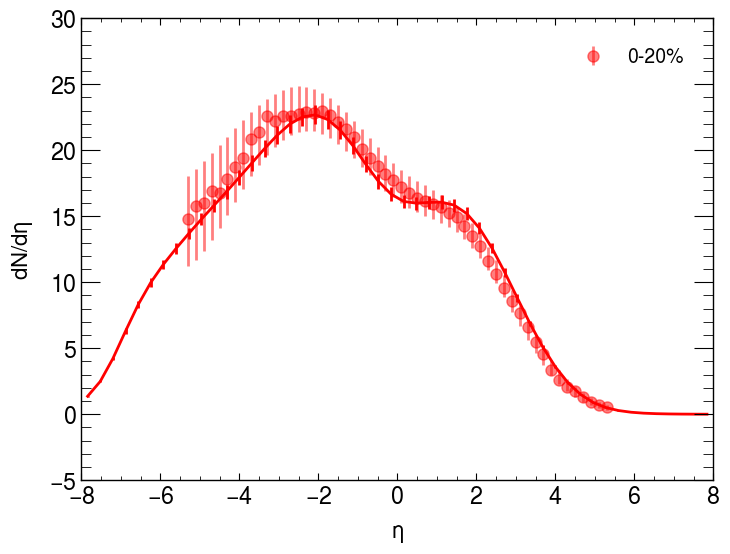

In [28]:
plot_dNdEta(
    m=0, n=20, eta_flat='1p3', eta_gw='1p3', HWF_or_DWF='DWF',  
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35",
    mode_MC_SMOOTH="MC", nsampling=2000, event_range=[0, 1000],plot_errbar=True,
    color='red', coef=1, fontsize=16)
plt.errorbar(data_exp[0][:, 0], data_exp[0][:, 2], yerr=[data_exp[0][:, 4], data_exp[0][:, 3]], 
                     fmt='o', ecolor='red', color='red', alpha=0.5, label='0-20%')
plt.legend()

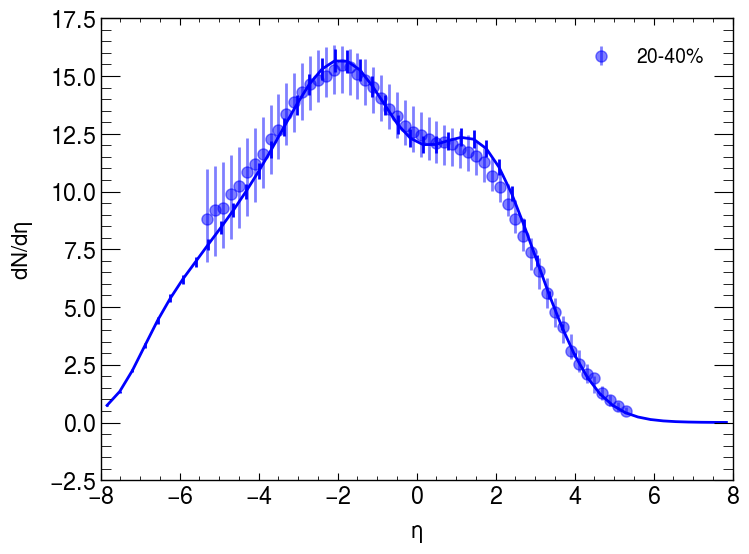

In [26]:
plot_dNdEta(
    m=20, n=40, eta_flat='1p3', eta_gw='1p3', HWF_or_DWF='DWF',  
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35",
    mode_MC_SMOOTH="MC", nsampling=2000, event_range=[0, 1000],plot_errbar=True,
    color='blue', coef=1, fontsize=16)
plt.errorbar(data_exp[1][:, 0], data_exp[1][:, 2], yerr=[data_exp[1][:, 4], data_exp[1][:, 3]], 
                     fmt='o', ecolor='blue', color='blue', alpha=0.5, label='20-40%')
plt.legend()

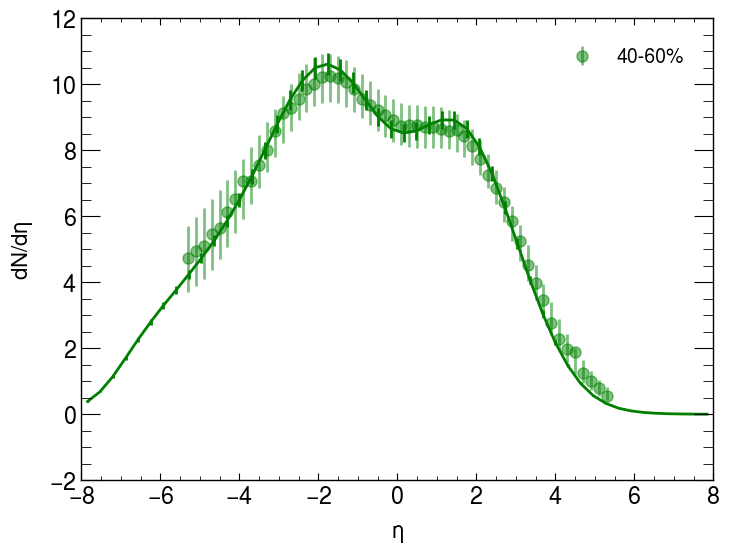

In [27]:
plot_dNdEta(
    m=40, n=60, eta_flat='1p3', eta_gw='1p3', HWF_or_DWF='DWF',  
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35",
    mode_MC_SMOOTH="MC", nsampling=2000, event_range=[0, 1000],plot_errbar=True,
    color='green', coef=1, fontsize=16)
plt.errorbar(data_exp[2][:, 0], data_exp[2][:, 2], yerr=[data_exp[2][:, 4], data_exp[2][:, 3]], 
                     fmt='o', ecolor='green', color='green', alpha=0.5, label='40-60%')
plt.legend()

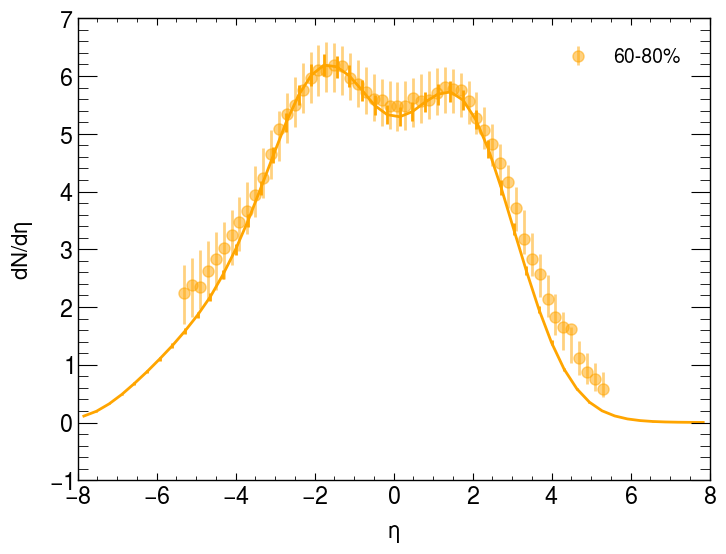

In [28]:
plot_dNdEta(
    m=60, n=80, eta_flat='1p3', eta_gw='1p3', HWF_or_DWF='DWF',  
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35",
    mode_MC_SMOOTH="MC", nsampling=2000, event_range=[0, 1000],plot_errbar=True,
    color='orange', coef=1, fontsize=16)
plt.errorbar(data_exp[3][:, 0], data_exp[3][:, 2], yerr=[data_exp[3][:, 4], data_exp[3][:, 3]], 
                     fmt='o', ecolor='orange', color='orange', alpha=0.5, label='60-80%')
plt.legend()

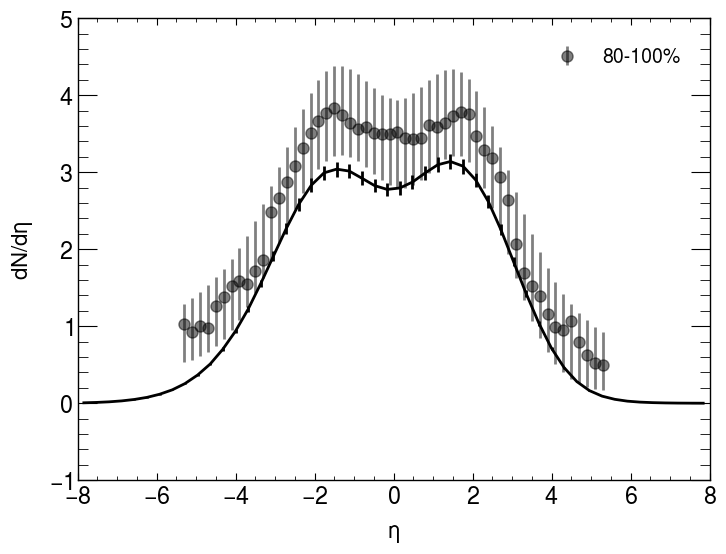

In [32]:
plot_dNdEta(
    m=80, n=100, eta_flat='1p3', eta_gw='1p3', HWF_or_DWF='DWF',  
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35",
    mode_MC_SMOOTH="MC", nsampling=2000, event_range=[0, 1000],plot_errbar=True,
    color='black', coef=1, fontsize=16)
plt.errorbar(data_exp[4][:, 0], data_exp[4][:, 2], yerr=[data_exp[4][:, 4], data_exp[4][:, 3]], 
                     fmt='o', ecolor='black', color='black', alpha=0.5, label='80-100%')
plt.legend()

In [33]:
def plot_hydro_all(
    eta_flat='1p3',eta_gw='1p3',
    para="entropy3D_y0_3p5_sigma_3p0_L_factor_2p5_R_factor_2p5_P_factor_5p0_alpha_1p0_beta_0p5_y_loss_0p0",
    mode='SMOOTH', nsampling=2000, event_range=[0,300],plot_errbar='true',label_para="para 1",
    HWF_or_DWF='HWF',coef=1,fontsize=16, save_fig=False):
    
    # 用P_factor 、beta命名文件
    parts = para.split('_')
    P_factor = parts[13] # 第13部分是 P_factor 的值
    beta = parts[17]     # 第17部分是 beta 的值
    
    
    # 颜色列表，用于每个中心度的线条和散点保持一致
    colors = ['red','blue', 'green', 'orange', 'black', 'purple', 'cyan']
    labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
    markers = ['o', '^', 'v', '*','s', 'D']

    # 绘图
    for idx, m in enumerate([0, 20, 40, 60,80]):
        # 绘制不同中心度范围的模拟数据，并确保颜色一致
        plot_dNdEta(m=m, n=m+20, para=para, eta_flat=eta_flat,eta_gw=eta_gw,HWF_or_DWF=HWF_or_DWF, 
                    event_range=event_range,nsampling=nsampling,plot_errbar=plot_errbar,
                    mode_MC_SMOOTH=mode, coef=coef,fontsize=fontsize, color=colors[idx])
        # 绘制实验结果，确保颜色与模拟数据一致
        plt.errorbar(data_exp[idx][:, 0], data_exp[idx][:, 2], yerr=[data_exp[idx][:, 4], data_exp[idx][:, 3]], 
                     fmt=markers[idx], ecolor=colors[idx], color=colors[idx], alpha=0.5, label=labels[idx])
        plt.legend(fontsize=fontsize)
        

    
    # 创建一个空的图例句柄
    empty_handle = plt.plot([], [], color='none', label=label_para, linestyle='')[0]

    # 绘制图例，包括空的图例句柄
#     plt.legend(handles=[empty_handle], loc='upper left')
    plt.legend(fontsize=fontsize)

    plt.gcf().set_size_inches(8, 6)  # 调整当前图形的大小为宽10英寸，高6英寸
    if save_fig:
        plt.savefig(f'fig/dNdeta_P_factor_{P_factor}_beta_{beta}.pdf', bbox_inches='tight', pad_inches=0.0)


    plt.show()  # 在最后显示所有图像

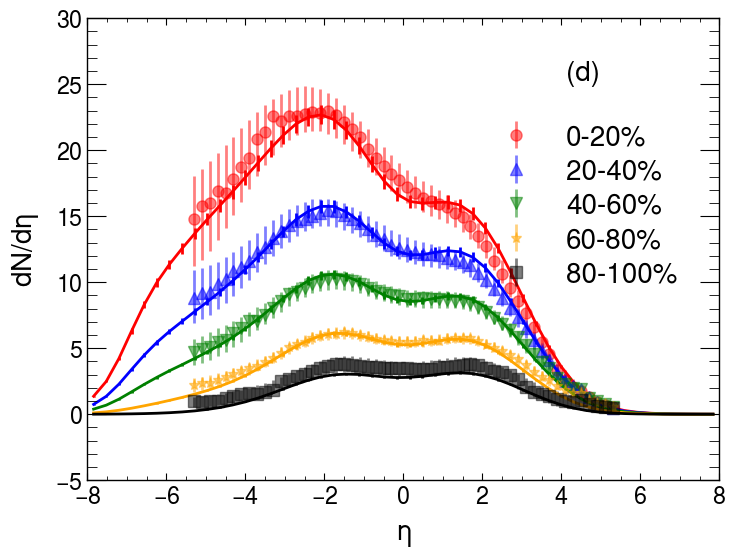

In [34]:
plot_hydro_all(
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35",
    mode='MC',HWF_or_DWF='DWF',event_range=[0,1000],nsampling=2000,plot_errbar=True,label_para="(d)\n",
    eta_flat='1p3',eta_gw='1p3',coef=1,fontsize=20,save_fig=False)

# 验证末态中心度

In [35]:
def convert_label_n_BC(original_label):
    #3#
    #entropy3D_y0_3p5_sigma_3p0_L_factor_2p5_R_factor_2p5_P_factor_5p0_alpha_1p0_beta_0p5_y_loss_0p0
    #
    # 分割字符串
    parts = original_label.split('_')

    # 提取相关部分并转换格式
    eta_0 = (parts[2].replace('p', '.'))  # 第4部分是 eta_0 的值
    sigma = (parts[4].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    L_factor = (parts[7].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    R_factor = (parts[10].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    P_factor = (parts[13].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    alpha = (parts[15].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    beta = (parts[17].replace('p', '.'))  # 第6部分是 sigma 的值，并将 'p' 替换为 '.'
    

    
    # 格式化字符串
    formatted_label = (f'$\\rm \\eta_0$={eta_0}, $\\rm \\sigma$={sigma}, $\\rm g_L$={L_factor}, $\\rm g_R$={R_factor}, '
                 + f'$\\rm g_P$={P_factor}, $\\rm \\alpha$={alpha}, $\\rm \\beta$={beta}')

    return formatted_label

    

In [36]:
def plot_dNdEta_multiple_subplots(
    eta_flat='1p3',
    eta_gw='1p3',
    event_range=[0, 100],
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_0p7_R_factor_0p7_P_factor_6p5_alpha_2p0_beta_0p5_y_loss_0p0",
    mode_MC_SMOOTH="MC",
    nsampling=2000,
    fontsize=12,
    HWF_or_DWF='DWF',save_fig=False):
    
    # 用P_factor 、beta命名文件
    parts = para.split('_')
    P_factor = parts[13] # 第13部分是 P_factor 的值
    beta = parts[17]     # 第17部分是 beta 的值
    
    #设置图标标签等
    centrality_ranges=[[0, 20], [20, 40], [40, 60], [60, 80],[80,100]]
#     labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
    colors=['blue', 'green', 'orange', 'red', 'purple']
    markers = ['o', '^', 'v', '*','s', 'D']

    num_centralities = len(centrality_ranges)
#     fig, axes = plt.subplots(1, num_centralities, figsize=(20, 5), sharey=True)
#     fig, axes = plt.subplots(1, num_centralities, figsize=(25, 5))
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()  # 将 2x4 的数组转换为 1D 数组，便于迭代


    
#     titletext = convert_label(para)
    titletext = r'Distribution of $\rm dN/d\eta$ by Centrality'

    disk_2T='MZ'
    
    # 对中心度循环，
    for i, centrality in enumerate(centrality_ranges):
        m, n = centrality
        color = colors[i % len(colors)]  # 轮换颜色
        label = f"Centrality {m}-{n}%"
        ax = axes[i]
        ax.plot([], [], linestyle=' ', label=f'{m}-{n}%')
        ax.errorbar(data_exp[i][:, 0], data_exp[i][:, 2], yerr=[data_exp[i][:, 4], data_exp[i][:, 3]], 
                     fmt=markers[i], ecolor='black', color='black')
        ax.legend(loc='upper right', fontsize=20)
        
        # 读取流体结果路径
        if mode_MC_SMOOTH == 'MC':
            input_dir = f"/media/mengzhu/west16/d_Au_work/d_Au_{HWF_or_DWF}/hydro_result_n_BC/ebe_mc_nsampling_{nsampling}/plat_{eta_flat}_gw_{eta_gw}/{para}/dAu200/{m}_{n}/"
            input_filename = "dNdEta_mc_charged.dat"
        elif mode_MC_SMOOTH == 'SMOOTH':
            input_dir = f"/media/mengzhu/{disk_2T}/home/mengzhu/d_Au_work/d_Au_{HWF_or_DWF}/hydro_result/ebe_smooth/plat_{eta_flat}_gw_{eta_gw}/{para}/dAu200/{m}_{n}/"
            input_filename = "dNdEta_Charged.dat"

        # 逐事件读取并绘图
        for j in range(event_range[0], event_range[1]):
            input_path = os.path.join(input_dir, f"event{j}", input_filename)
            if os.path.exists(input_path):
                dNdEta = np.loadtxt(input_path)
                ax.plot(dNdEta[:, 0], dNdEta[:, 1], color=color, alpha=0.5)

        # 子图设置
        ax.set_xlim(-8, 8)
        ax.set_ylim(0, 40)
        ax.set_xlabel(r"$\rm \eta$", fontsize=fontsize,ha='center')
#         ax.set_title(label, fontsize=fontsize)
        ax.set_ylabel(r"$\rm dN/d\eta$", fontsize=fontsize,ha='center')
        
#         if i == 0:  # 只在第一个子图添加y轴标签
#             ax.set_ylabel("$dN/d\eta$", fontsize=fontsize,ha='center')
        ax.grid(True)

    # 总体标题
    axes[-1].axis('off')
    fig.suptitle(titletext, fontsize=fontsize + 5)
    fig.tight_layout(rect=[0, 0, 1, 1])
    if save_fig:
            plt.savefig(f'fig/dNdeta_ebe_P_factor_{str(P_factor).replace(".", "p")}_beta_{str(beta).replace(".", "p")}.pdf', bbox_inches='tight', pad_inches=0.0)
    plt.show()


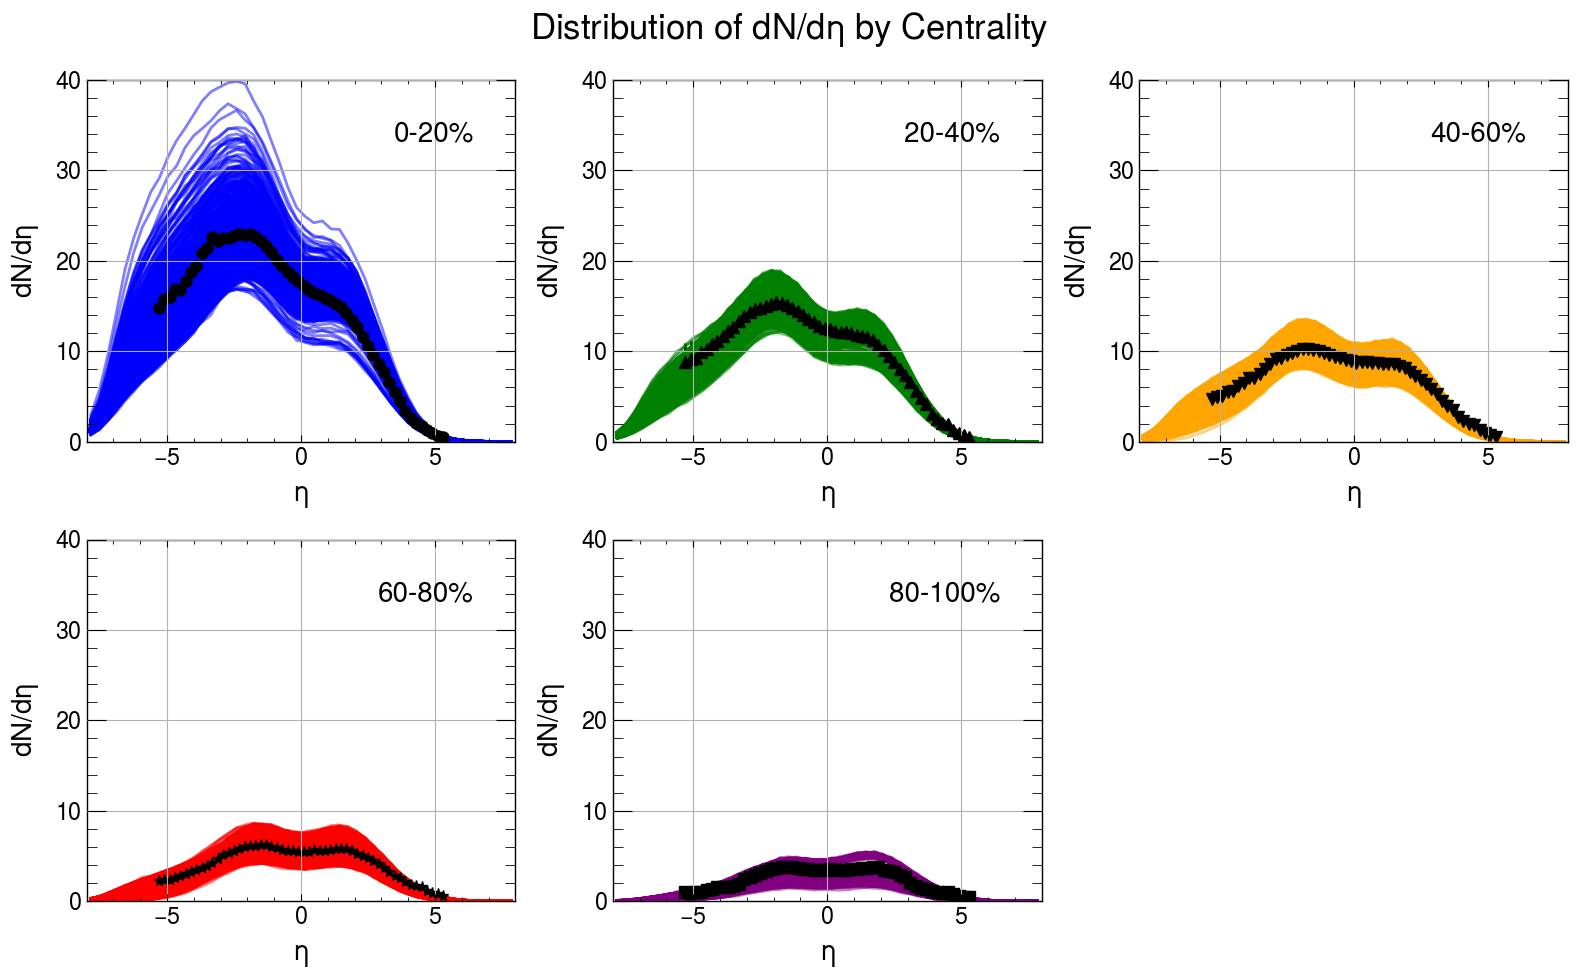

In [37]:
plot_dNdEta_multiple_subplots(
    eta_flat='1p3',
    eta_gw='1p3',
    event_range=[0, 1000],
    para="entropy3D_y0_4p0_sigma_2p5_L_factor_2p0_R_factor_2p0_P_factor_5p5_alpha_1p0_beta_0p35",
    mode_MC_SMOOTH="MC",
    nsampling=2000,
    fontsize=20,
    HWF_or_DWF='DWF',save_fig=False
)